In [ ]:
#white car + shadows

test_images/extra-88-output.jpg


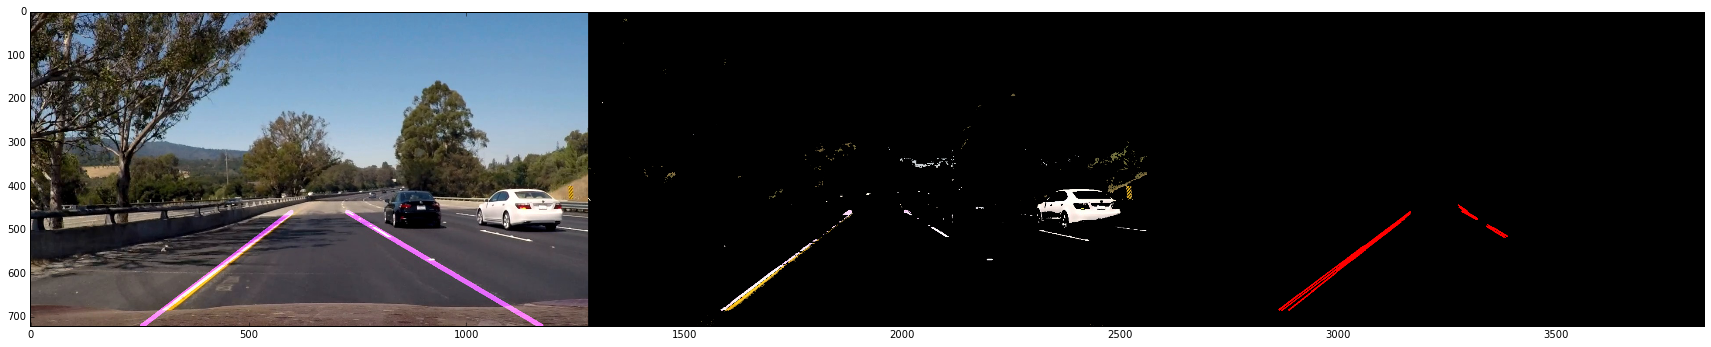

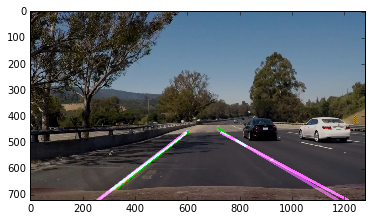

In [100]:
import math
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, color=[255,0,0]):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, color = color)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def lane_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)       
    ymask = cv2.inRange(hsv,  np.array([50, 100, 100]), np.array([100, 255, 255]))  
    wmask = cv2.inRange(image, np.array([200, 200, 200]), np.array([255, 255, 255]))
        
    mask = cv2.bitwise_or(ymask, wmask)
    res = cv2.bitwise_and(image, image, mask = mask)
    return res

def pass1(image):
    return grayscale(lane_mask(image))

def pass2(image):
    blur=7
    return gaussian_blur(image, blur)

def pass3(image):
    canny_threshold_high = 150  
    canny_threshold_low = 50
    return canny(image, canny_threshold_low, canny_threshold_high)

def lines(image, draw=True, color=[255,0,0]):
    rho= 1 #distance in pixels
    theta=np.pi/180.0 #angle resolution of the acc in radians
    threshold = 15
    min_line_len = 20
    max_line_gap = 20
    
    i = pass3(pass2(pass1(image)))
    
    
    shape_y, shape_x, _ = image.shape
    vertices = np.array([[
        (0, shape_y),
        (int(.8*shape_x/2), int(1.2*shape_y/2)), 
        (int(1.2*shape_x/2), int(1.2*shape_y/2)), 
        (shape_x, shape_y)
    ]], dtype=np.int32)
    
    #print('vertices', vertices)
    region = region_of_interest(i, vertices)
                
    if draw:         
        return hough_lines(region, rho, theta, threshold, min_line_len, max_line_gap, color = color)
    else:               
        return cv2.HoughLinesP(region, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
def slope(a):
    x1, y1, x2, y2 = a.reshape((4,))
    if x1 != x2:
        return (y2-y1)/(x2-x1)        
    else:
        return None
    
def bottom_x(a, y):
    s = slope(a)
    x1, y1, x2, y2 = a.reshape((4,))
    if s:
        return x1 + (y-y1)/s # x coordinate for line at given y
    else:
        #vertical line, x1 same as x2
        return x1
    
def length(a):
    x1, y1, x2, y2 = a.reshape((4,))
    return math.hypot(x2-x1, y2-y1)
    

def intersection(lane1_x0, lane1_y0, lane1_slope, lane2_x0, lane2_y0, lane2_slope):
    y1 = 300 #any value could do
    #print('slopes:', lane1_slope, lane2_slope)
    #print(lane1_x0, lane1_y0, lane1_slope, lane2_x0, lane2_y0, lane2_slope)    
    
    lane1_x1 = int(lane1_x0 + (y1 - lane1_y0)/lane1_slope)
    lane2_x1 = int(lane2_x0 + (y1 - lane2_y0)/lane2_slope)
    
    A1 = y1 - lane1_y0
    B1 = lane1_x0 - lane1_x1
    C1 = A1 * lane1_x0 + B1 * lane1_y0
    
    A2 = y1 - lane2_y0
    B2 = lane2_x0 - lane2_x1
    C2 = A2 * lane2_x0 + B2 * lane2_y0
    
    det = A1*B2 - A2*B1
    if det != 0:
        x2 = (B2*C1 - B1*C2)/det
        y2 = (A1*C2 - A2*C1)/det
        return [x2, y2]
    else:
        raise #parallel lines

        
def lane(segments, max_x, max_y, lane_x_range, slope_range):    
    bin_pixels = 40
    num_bins = int(0.5 * max_x/bin_pixels)        

    # currently we use this range only to distinguish between left and right lanes
    # so the left lane is on the left-half of the x-axis
    lane_range = range(lane_x_range[0], lane_x_range[1])    

    # calculate x-coordinate of intersection between extension of segment
    # and bottom line. 
    bottom = np.array([int(bottom_x(x, max_y)) for x in segments])
    slopes = np.array([slope(x) for x in segments])
    #lengths = np.array([length(x) for x in segments])
    weights = np.array([ (abs(max(x[0][1], x[0][3]) - max_y)**1.3 + length(x)**1.5) for x in segments])
        
    idx = [i for i, x in enumerate(segments) 
                if slopes[i] is not None
                and slope_range[0] <= slopes[i] <= slope_range[1]
                and bottom[i] in lane_range] 
        
    if 0 == len(idx):
        raise Exception({
            'error': 'no segments matching criteria',
            'lane_range': lane_range,
            'bottom': bottom,
            'slope_range': slope_range,
            'slopes': slopes,
            'segments': segments
            })                
    
        
    # to find out whether each segments corresponds to a line
    counts, bins = np.histogram(bottom[idx], bins=num_bins, range=lane_x_range, weights=weights[idx])    
    #print(counts, bins)
    
    assert(0 < len(counts))
    
    #TODO: handle empty sequence here, maybe repeat with different parameters.
    if len(counts) == 0:
        # debugging.
        #print('bin:', int(max_x/bin_width))
        #print('bottom:', bottom)        
        raise Exception("oops")
     
    
    in_range = [i for i,v in enumerate(zip(counts, bins)) if v[0] > 0]
    
    if 0 == len(in_range):
        #TODO
        print('#### failed here:')
        print('SEGMENTS', segments)        
        print('LANERANGE ', lane_range)
        print('HIST:', counts, bins)
        print('???', [v for i,v in enumerate(zip(counts, bins))])
    
    # the the x-bin with most occurrences -- all lines reaching this area will be averaged.
    i_left = np.argmax(counts)
    lane_bin = range(int(bins[i_left]), int(bins[i_left+1]))        
    #print('bin:', llane_bin)
    #print('raw slopes:', [(slope(x),bottom_x(x, max_y)) for x in segments])
    
    indices_within = [i for i in idx if bottom[i] in lane_bin]
    
    # all slopes for lines reaching selected bin
    lane_slopes = slopes[indices_within]  
    assert 0 < len(lane_slopes)
    
    # all x positions for lines reaching selected bin
    lane_xs = bottom[indices_within]
    assert 0 < len(lane_xs)
    
    lane_weights = weights[indices_within]
    assert 0 < len(lane_weights)
    
    min_y_segment = min([min(segments[x][0][1], segments[x][0][3]) for x in indices_within])
    
    
    #print('slopes:', llane_slopes)
    #print('xs:', llane_xs)
    
    # 
    # a lane is defined here by the slope and the position
    # on the line defined by y=max_y (bottom of the image)
    if len(lane_slopes)==0:
        #debugging
        print('LEN SLOPES ZERO.,,,,')
        #print('slopes:', slopes)
        #print('bottom:', bottom)
        #print('BIN:', llane_bin)
        #print('HISTT:', counts, bins)
        #print('raw slopes:', [(slope(x),bottom_x(x, max_y)) for x in segments])        

    
    #print('slopes', lane_slopes)    
    #print('xs', lane_xs)
    #print('weights', lane_weights)
    #print('lenghts',[length(segments[x]) for x in indices_within])
    
    #for i in indices_within:
    #    print(segments[i])
    
    
    mean_slope = np.average(lane_slopes.astype(np.float), weights=lane_weights.astype(np.float))    
    assert abs(mean_slope) > 0.1, lane_slopes
    assert ~np.isnan(mean_slope)
    
    mean_xs = int(np.average(lane_xs.astype(np.float), weights=lane_weights.astype(np.float)))
    assert mean_xs > 0, lane_xs
    
    #print('mean slope, xs', mean_slope, mean_xs)
    return mean_slope, mean_xs, min_y_segment
    
def lanes(segments, max_x, max_y):   
    #print('SEGMENTS LEN:', len(segments))
    left_slope, left_x, left_y = lane(segments, max_x, max_y, (0, int(max_x/2)), (-0.9, -0.1))
    right_slope, right_x, right_y = lane(segments, max_x, max_y, (int(max_x/2), max_x), (0.1, 0.9)) 
    
    #print('slopes', left_slope, right_slope)
    
    # in the first version I was drawing lanes that intersect in the horizon,
    # not sure why I thought it was part of the exercise.
    #left lane: x0, y0, slope
    #right lane: x1, y1, slope
    horizon = intersection(left_x, max_y, left_slope, right_x, max_y, right_slope)     
    y = horizon[1] * 1.1 #give some margin to look prettier on curves
    
    left_y1 = y #max(min(y, left_y,), .6 * max_y)    
    left_x1 = int(left_x + (left_y1 - max_y)/left_slope)
    
    right_y1 = y #max(min(y, right_y), .6 * max_y)
    right_x1 = int(right_x + (right_y1 - max_y)/right_slope)

    
    lines = []        
    lines.append([[int(left_x), int(max_y), int(left_x1), int(left_y1)]])    
    lines.append([[int(right_x), int(max_y), int(right_x1), int(right_y1)]])    
    return lines

def lane_overlay(image):
    img2 = np.zeros_like(image)
    max_y, max_x, _ = img2.shape
    color = [200, 50, 255]    
    draw_lines(img2, lanes(lines(image, draw=False),  max_x, max_y), color = color, thickness=10)
    return img2
    
def lane_overlay_averaged(image, previous):
    """ Annotate given image with lanes
    
    Averaging lane from previous frame with current one gives smoother results.
    """
    img2 = np.zeros_like(image)
    max_y = img2.shape[0]
    max_x = img2.shape[1]
    color = [200, 50, 255]
    #color = [255, 0, 0]
    current = lanes(lines(image, draw=False), max_x, max_y)
    if previous is not None:
        for i, (c, p) in enumerate(zip(current, previous)):
            for j in range(4):
                v= c[0][j] #current
                w = p[0][j] #previous
                current[i][0][j] = int(v*.2 + w*.8)    
    draw_lines(img2, current, color = color, thickness=10)
    return img2, current
    
    
def sideBySide(filename):
    image=mpimg.imread(filename)            
    return np.hstack([image, weighted_img(lane_overlay(image), image)])    

def sideBySideDebug(filename):
    image=mpimg.imread(filename)            
    #return pass3(pass2(pass1(image)))
    return np.hstack([image, lane_mask(image), lines(image)])
    #return np.hstack([image, lane_mask(image), weighted_img(lane_overlay(image), image)])    

filenames = ['test_images/' + f for f in os.listdir("test_images") if f.endswith('jpg')]
#filenames = [x for x in filenames if x.startswith('test_images/error')]
#filenames = ['test_images/extra-94.jpg']
for i, f in enumerate(filenames[:1]):
    print(f)
    
    debug = sideBySideDebug(f)
    plt.figure(figsize=(30,30))    
    plt.imshow(debug)

    image=mpimg.imread(f)            
    lines2 = [x for x in lines(image, draw=False)]    
    for row in lines2:
        l = row[0]
        #print(l)        
        cv2.line(image, (l[0], l[1]), (l[2], l[3]), (0, 255, 0), 2) 
    plt.figure()
    #plt.imshow(image)
    plt.figure() #figsize=(30,30))
    for row in lines2:
        l = row[0]
        #print(l)      
        x = int(bottom_x(row, 720))
        #cv2.line(image, (x, 0), (x, 720), (0, 0, 0), 2) 
    plt.imshow(weighted_img(lane_overlay(image), image))
    #print(lanes(lines2, 960, 540))
    #plt.imshow(pass2(pass1(image)))
    #plt.imshow(lane_mask(image))
        
    #image = mpimg.imread('test_images/' + f)
    #mage_with_lanes = weighted_img(image, lane_overlay(image))
    #lt.imshow(image_with_lanes)
    #mpimg.imsave('test_images/output/' + f, image_with_lanes)

    


In [109]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

process_debug = True 
error_count = 0
frame_count = 0

previous_lane = None #lane
previous_output = None

def process_image(image):  
    global error_count, frame_count, previous_lane, previous_output
    frame_count += 1
    try:    
        #print('####' + str(frame_count))
        if frame_count <= 10:
            mpimg.imsave("test_images/extra-{}.jpg".format(frame_count), image)
        overlay, previous_lane = lane_overlay_averaged(image, previous_lane)
        output = weighted_img(image, overlay)                
        previous_output = output
        if frame_count <= 10:
            mpimg.imsave("test_images/extra-{}-output.jpg".format(frame_count), output)
        return output
    except Exception as e:
        print('####' + str(frame_count))
        print(e)
        error_count += 1        
        if process_debug:            
            mpimg.imsave("test_images/error-{}.jpg".format(error_count), image)
        
        #fall back to previous image
        if previous_output is not None:
            return previous_output
        return image




In [102]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:17<00:00, 11.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 19.5 s, sys: 1.43 s, total: 20.9 s
Wall time: 18.6 s


In [110]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)




[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:01<00:00, 11.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 5s, sys: 5.28 s, total: 1min 10s
Wall time: 1min 3s


In [96]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

####1
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.6744186  -0.72727273 -0.72316384 -0.67346939 -0.66666667 -0.73684211
 -0.64646465 -0.6733871  -0.70967742]
xs [204 236 232 202 202 238 203 203 233]
weights [ 5595.09048266  1970.93369157  3326.2587257    611.55678721   866.18582698
   935.12054267  2153.28964537  5279.15692116   760.82827509]
lenghts [311.19125951735856, 122.41323457861898, 218.4330561064419, 59.07622195096772, 25.238858928247925, 47.20169488482379, 117.88553770501282, 298.9866217742861, 76.02631123499285]
[[258 684 516 510]]
[[429 580 528 508]]
[[280 686 457 558]]
[[275 671 324 638]]
[[444 559 465 545]]
[[427 581 465 553]]
[[487 537 586 473]]
[[258 683 506 516]]
[[281 686 343 642]]
mean slope, xs -0.687376629066 213
slopes [ 0.5974026   0.57142857  0.6         0.5890411   0.59722222]
xs [1164 1182 1167 1165 1166]
weights [ 2543.63066426  1301.16324502   467.78453039  1167.62234474   913.06234824]
lenghts [179.38784797192923, 24.1867732

  0%|          | 0/251 [00:00<?, ?it/s]

####2
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.6744186  -0.72727273 -0.72316384 -0.67346939 -0.66666667 -0.73684211
 -0.64646465 -0.6733871  -0.70967742]
xs [204 236 232 202 202 238 203 203 233]
weights [ 5595.09048266  1970.93369157  3326.2587257    611.55678721   866.18582698
   935.12054267  2153.28964537  5279.15692116   760.82827509]
lenghts [311.19125951735856, 122.41323457861898, 218.4330561064419, 59.07622195096772, 25.238858928247925, 47.20169488482379, 117.88553770501282, 298.9866217742861, 76.02631123499285]
[[258 684 516 510]]
[[429 580 528 508]]
[[280 686 457 558]]
[[275 671 324 638]]
[[444 559 465 545]]
[[427 581 465 553]]
[[487 537 586 473]]
[[258 683 506 516]]
[[281 686 343 642]]
mean slope, xs -0.687376629066 213
slopes [ 0.5974026   0.57142857  0.6         0.5890411   0.59722222]
xs [1164 1182 1167 1165 1166]
weights [ 2543.63066426  1301.16324502   467.78453039  1167.62234474   913.06234824]
lenghts [179.38784797192923, 24.1867732

  0%|          | 1/251 [00:00<02:13,  1.87it/s]

####3
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72380952 -0.67400881 -0.72289157 -0.71875    -0.72727273 -0.72592593
 -0.6746988  -0.72727273]
xs [233 203 234 234 239 232 204 237]
weights [ 4275.63374137  4638.56351719  3205.43038499  1151.88096578  1298.63460557
  2256.32486216  5315.20275777  1071.47118259]
lenghts [259.2373429890069, 273.7480593538519, 204.83163818121457, 39.408120990476064, 40.80441152620633, 166.82026255823962, 300.3747659175118, 27.202941017470888]
[[282 685 492 533]]
[[258 683 485 530]]
[[338 645 504 525]]
[[496 532 528 509]]
[[527 511 560 487]]
[[281 685 416 587]]
[[259 683 508 515]]
[[501 528 523 512]]
mean slope, xs -0.702794522035 220
slopes [ 0.6         0.6         0.65        0.63636364  0.64      ]
xs [1148 1146 1132 1141 1136]
weights [ 1788.38315797  1690.0322498   1258.95240784  1282.21782916  1297.56192844]
lenghts [139.9428454762872, 134.1118935814419, 23.853720883753127, 26.076809620810597, 29.68164415931166]
[[ 

  1%|          | 2/251 [00:01<02:22,  1.75it/s]

####4
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70135747 -0.67272727 -0.67484663 -0.6984127  -0.70588235 -0.73913043
 -0.66197183 -0.69230769 -0.69387755 -0.69565217 -0.68965517 -0.6969697
 -0.67857143 -0.6875     -0.7016129 ]
xs [229 203 204 229 228 234 202 211 229 230 212 221 209 226 227]
weights [ 4777.1432323   4426.83723569  2863.02806216  1647.50789353  1666.37970049
   534.31575603  1721.58346596   995.75395819   687.98667557   872.30147554
  1063.86768107  1377.80120965  1177.09064936   771.79382647  2320.25384472]
lenghts [269.937029693964, 265.1490147068248, 196.64434901618708, 76.84399781375251, 104.04326023342406, 57.201398584300364, 85.14693182963201, 31.622776601683793, 59.64059020499378, 84.0535543567314, 35.22782990761707, 40.22437072223753, 33.83784863137726, 58.249463516842795, 151.47607071745688]
[[356 631 577 476]]
[[258 683 478 535]]
[[258 684 421 574]]
[[514 521 577 477]]
[[424 582 509 522]]
[[282 685 328 651]]
[[494 527 565 480

  1%|          | 3/251 [00:01<02:24,  1.71it/s]

####5
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70048309 -0.69655172 -0.66666667 -0.70652174 -0.6984127  -0.69047619
 -0.6875     -0.7        -0.70833333 -0.67123288 -0.66666667 -0.7
 -0.72972973 -0.7037037  -0.70588235]
xs [230 210 205 233 209 206 208 227 218 209 204 231 212 229 234]
weights [ 4405.63172133  2549.51986436  1780.99433285  1297.25011049  2075.42405993
   473.94344391  1066.8462606   1469.58064448   916.85116163  1735.14606101
  1049.41440222   524.31355073   411.68697953  3963.93376302   861.06671581]
lenghts [252.73306075778848, 176.70880000724355, 93.74433316206373, 112.6454615153225, 153.68799562750502, 51.03920062069938, 58.249463516842795, 97.65244492586962, 29.410882339705484, 87.92041856133307, 39.66106403010388, 36.61966684720111, 45.803929962395145, 231.10603626906848, 83.23460818673925]
[[370 622 577 477]]
[[295 661 440 560]]
[[480 537 558 485]]
[[283 685 375 620]]
[[284 668 410 580]]
[[260 683 302 654]]
[[414 579 462 546]]


  2%|▏         | 4/251 [00:02<02:08,  1.93it/s]

####6
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70183486 -0.67164179 -0.70247934 -0.67661692 -0.70588235 -0.70149254
 -0.67857143 -0.69047619 -0.6779661  -0.69230769]
xs [231 205 232 207 235 234 205 231 209 235]
weights [ 4678.64677644  2212.5171699   5336.34504229  3893.8463633   1214.7577933
   838.3186659    924.07404654   587.49379738  1229.83544477   279.52033178]
lenghts [266.33249895572266, 161.4187101918486, 295.7431317883815, 242.68704126920332, 62.42595614005443, 81.8413098624405, 67.67569726275453, 51.03920062069938, 71.28113354878694, 31.622776601683793]
[[355 633 573 480]]
[[280 670 414 580]]
[[332 650 574 480]]
[[264 682 465 546]]
[[459 562 510 526]]
[[283 686 350 639]]
[[344 626 400 588]]
[[324 656 366 627]]
[[419 578 478 538]]
[[286 685 312 667]]
mean slope, xs -0.691591270154 222
slopes [ 0.6         0.62962963  0.66666667  0.65217391]
xs [1159 1134 1123 1132]
weights [ 1318.01149021  1179.63592311  1284.00905395  1495.06540381]
leng

  2%|▏         | 5/251 [00:02<02:12,  1.85it/s]

####7
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67403315 -0.70124481 -0.70093458 -0.7        -0.66911765 -0.67105263
 -0.70149254 -0.70212766 -0.67375887 -0.68965517]
xs [209 233 235 232 209 210 231 233 207 235]
weights [ 3326.5682294   5144.2615669   4326.39799976  1863.23766373  2681.3282345
  3098.91000196  1695.2321559   1523.9610532   2322.35956091   310.78025966]
lenghts [218.27734651126764, 294.35013164597024, 261.3350340080717, 97.65244492586962, 163.63679292872982, 183.05190520723897, 81.8413098624405, 114.85643212288984, 170.01764614298128, 35.22782990761707]
[[261 685 442 563]]
[[281 687 522 518]]
[[285 685 499 535]]
[[500 533 580 477]]
[[411 585 547 494]]
[[421 579 573 477]]
[[511 524 578 477]]
[[346 641 440 575]]
[[261 684 402 589]]
[[286 685 315 665]]
mean slope, xs -0.688330440425 222
slopes [ 0.6         0.60526316  0.62068966  0.61702128]
xs [1158 1158 1144 1154]
weights [ 1279.78185261  1257.21956483  1428.40365362  1659.58831697]
l

  2%|▏         | 6/251 [00:03<02:14,  1.82it/s]

####8
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7020202  -0.67361111 -0.67073171 -0.70175439 -0.70334928 -0.68627451
 -0.70103093 -0.68181818 -0.66666667 -0.66666667 -0.71666667 -0.6969697 ]
xs [236 210 211 232 235 210 231 215 207 207 226 232]
weights [ 3864.44847604  6576.26301265  1993.34720907  2492.16613609  4186.15572174
   595.78357169  2218.91678521  1400.85594592   750.33727298   777.89313066
  1367.64205373  1012.46441248]
lenghts [241.91940806805889, 347.2463102755737, 98.73702446397704, 139.26952286842948, 255.51907952244974, 61.85466837676846, 118.46096403457132, 53.25410782277739, 46.87216658103186, 64.89992295835181, 73.81734213584231, 40.22437072223753]
[[286 685 484 546]]
[[264 684 552 490]]
[[517 515 599 460]]
[[488 541 602 461]]
[[285 685 494 538]]
[[264 683 315 648]]
[[505 528 602 460]]
[[516 515 560 485]]
[[366 614 405 588]]
[[314 649 368 613]]
[[450 560 510 517]]
[[468 556 501 533]]
mean slope, xs -0.690150731308 223
slopes [ 0.5

  3%|▎         | 7/251 [00:04<02:33,  1.59it/s]

####9
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67419355 -0.67487685 -0.67375887 -0.6742671  -0.68493151]
xs [212 211 213 211 225]
weights [ 7334.61682777  4267.31360058  2435.21867311  7237.97756153  1736.79265224]
lenghts [373.8729730804301, 244.90406284910833, 170.01764614298128, 370.2674708909763, 88.48163651289458]
[[266 684 576 475]]
[[370 613 573 476]]
[[307 657 448 562]]
[[268 682 575 475]]
[[500 532 573 482]]
mean slope, xs -0.675107825952 212
slopes [ 0.64912281  0.63333333  0.61290323  0.6         0.65      ]
xs [1128 1143 1155 1159 1126]
weights [ 1347.70047635  1514.95434504  1407.61369073  1447.47393812  1165.82410298]
lenghts [67.95586803212802, 35.510561809129406, 72.71863585079137, 75.8023746329889, 47.70744176750625]
[[811 514 868 551]]
[[720 452 750 471]]
[[818 513 880 551]]
[[813 512 878 551]]
[[814 517 854 543]]
mean slope, xs 0.62806034772 1143


  3%|▎         | 8/251 [00:04<02:30,  1.62it/s]

####10
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69756098 -0.69711538 -0.69565217 -0.703125   -0.70731707 -0.72727273
 -0.70108696]
xs [218 220 221 225 218 219 220]
weights [ 4121.75290724  4297.14279039  1380.64948402  1697.83460353   457.57667631
   266.7971244   3623.65415656]
lenghts [249.94799459087486, 253.5527558517162, 56.0357029044876, 78.2368199762746, 50.21951811795888, 27.202941017470888, 224.71537553091466]
[[293 668 498 525]]
[[324 648 532 503]]
[[505 523 551 491]]
[[516 516 580 471]]
[[268 685 309 656]]
[[276 679 298 663]]
[[322 649 506 520]]
mean slope, xs -0.699458354801 220
slopes [ 0.62666667  0.63888889  0.62337662  0.63934426  0.64705882  0.61538462]
xs [1148 1133 1149 1131 1136 1156]
weights [ 1512.95061478  1470.00688509  1544.56042672  1331.65835528  1547.46245127
   962.24635261]
lenghts [88.50988645343524, 85.44003745317531, 90.7358804442873, 72.40165743959182, 40.496913462633174, 30.528675044947494]
[[833 522 908 569]]
[[82

  4%|▎         | 9/251 [00:05<02:21,  1.71it/s]

####11
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69888476 -0.70063694 -0.6984127  -0.7        -0.71428571 -0.69565217]
xs [221 221 224 223 222 224]
weights [ 6050.82839484  2971.5710063   1698.70863477  1525.02559907   311.15362991
  1522.47112045]
lenghts [328.18439938546743, 191.70028690641024, 76.84399781375251, 73.23933369440222, 34.40930106817051, 56.0357029044876]
[[273 684 542 496]]
[[341 636 498 526]]
[[521 513 584 469]]
[[491 533 551 491]]
[[274 683 302 663]]
[[539 501 585 469]]
mean slope, xs -0.699309209305 221
slopes [ 0.67123288  0.62105263  0.62222222  0.62        0.63265306  0.64102564
  0.65217391  0.65789474]
xs [1121 1152 1152 1151 1134 1137 1129 1129]
weights [ 1429.51543537  1731.35058227  1640.08480776  1160.91239813  1139.39173495
  1571.21299281   692.63731599  1569.44032354]
lenghts [87.92041856133307, 111.83022847155415, 106.0, 58.83026432033091, 57.982756057296896, 46.32493928760188, 27.459060435491963, 45.48626166217664]
[[

  4%|▍         | 10/251 [00:05<02:21,  1.70it/s]

####12
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75113122 -0.74725275 -0.75257732 -0.74545455 -0.75336323 -0.76470588]
xs [252 253 251 254 254 258]
weights [ 4693.161278    2059.4006649   1664.83431223  1580.41582353  4770.73243407
  1116.32932141]
lenghts [276.40007235889067, 113.6001760562016, 121.40016474453401, 68.60029154456998, 279.20064469839605, 42.80186911806539]
[[298 686 519 520]]
[[493 541 584 473]]
[[366 634 463 561]]
[[529 515 584 474]]
[[302 684 525 516]]
[[490 543 524 517]]
mean slope, xs -0.751839491194 253
slopes [ 0.62295082  0.61702128  0.62711864  0.64285714  0.60416667  0.61538462]
xs [1139 1154 1153 1147 1158 1139]
weights [ 2100.77880706  1638.26057823   958.70515642   920.71854474  1065.29218129
   885.58613156]
lenghts [143.7358688706476, 110.45361017187261, 69.6419413859206, 66.57326790837296, 56.08029957123981, 61.05735008989499]
[[863 548 985 624]]
[[874 547 968 605]]
[[ 941  587 1000  624]]
[[942 588 998 624]]
[[870 546 

  4%|▍         | 11/251 [00:06<02:17,  1.74it/s]

####13


  5%|▍         | 12/251 [00:06<02:05,  1.91it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69858156 -0.69827586 -0.69655172 -0.70769231]
xs [223 221 223 222]
weights [ 6489.43880337  4873.02732226  3017.58569509  1108.69589995]
lenghts [343.99563950724723, 282.9628950940388, 176.70880000724355, 79.63039620647382]
[[276 683 558 486]]
[[276 682 508 520]]
[[437 571 582 470]]
[[364 620 429 574]]
mean slope, xs -0.698742074747 222
slopes [ 0.6         0.59677419  0.6         0.6         0.58333333]
xs [1163 1163 1162 1165 1169]
weights [ 3085.62715814  2052.61289596  1314.85246542   420.78597765   325.15274709]
lenghts [204.08331631958552, 144.40221604947757, 23.323807579381203, 34.9857113690718, 27.784887978899608]
[[ 902  563 1077  668]]
[[ 899  562 1023  636]]
[[752 474 772 486]]
[[1032  640 1062  658]]
[[1053  652 1077  666]]
mean slope, xs 0.598327477133 1163
####14


  5%|▌         | 13/251 [00:07<01:53,  2.11it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75179856 -0.75       -0.75581395 -0.75630252]
xs [252 250 254 256]
weights [ 6587.95902298  3364.8197251   3659.43854064  2543.99178735]
lenghts [347.80023001717524, 220.0, 215.60148422494683, 149.20120642943877]
[[299 685 577 476]]
[[297 685 473 553]]
[[411 602 583 472]]
[[465 562 584 472]]
mean slope, xs -0.753042682481 252
slopes [ 0.57692308  0.6         0.57831325  0.57575758  0.54545455]
xs [1171 1162 1170 1174 1195]
weights [ 2566.151304    1294.85426753  1088.02864718  1052.4038931   1287.74187108]
lenghts [180.0999722376436, 23.323807579381203, 95.88013350011565, 76.15773105863909, 25.059928172283335]
[[ 934  583 1090  673]]
[[757 477 777 489]]
[[1006  625 1089  673]]
[[ 938  584 1004  622]]
[[755 480 777 492]]
mean slope, xs 0.575502324542 1173
####15
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75367647 -0.75132275 -0.73394495]
xs [251 253 248]
weights [ 6387.611129

  6%|▌         | 14/251 [00:07<02:01,  1.95it/s]

####16
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69892473 -0.70138889 -0.70053476 -0.71428571]
xs [221 223 220 236]
weights [ 6393.27323474  6707.17887765  3842.91333284  1494.19947894]
lenghts [340.39095170112853, 351.77833929905347, 228.31995094603536, 68.81860213634101]
[[276 682 555 487]]
[[276 683 564 481]]
[[362 621 549 490]]
[[504 529 560 489]]
mean slope, xs -0.70140158311 222
slopes [ 0.56666667  0.56756757  0.56521739  0.59259259]
xs [1185 1178 1177 1160]
weights [ 1312.03864685   443.39543817   533.2788552   1272.28524023]
lenghts [34.48187929913333, 42.5440947723653, 52.839379254491625, 31.38470965295043]
[[767 483 797 500]]
[[1052  648 1089  669]]
[[1048  647 1094  673]]
[[766 486 793 502]]
mean slope, xs 0.575824705701 1173


  6%|▌         | 15/251 [00:08<01:58,  1.99it/s]

####17
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69863014 -0.72571429 -0.72340426 -0.74137931 -0.71875    -0.74242424
 -0.75757576 -0.65217391 -0.71052632 -0.74509804 -0.70909091]
xs [222 229 226 236 228 230 233 224 236 232 225]
weights [ 1769.93004767  3434.59461769  1355.12238577  1376.86125516  1936.58216105
   936.97979754   608.52647361   715.03394992  1480.5614741    900.15082822
   702.8188399 ]
lenghts [89.05054744357274, 216.22673285234646, 116.01724009818541, 72.20110802473879, 118.22436297142819, 82.20097323024831, 41.400483088968905, 27.459060435491963, 46.61544808322666, 63.60031446463138, 67.42403132415029]
[[497 528 570 477]]
[[327 649 502 522]]
[[276 684 370 616]]
[[459 555 517 512]]
[[432 574 528 505]]
[[307 663 373 614]]
[[351 631 384 606]]
[[427 588 450 573]]
[[557 492 595 465]]
[[365 621 416 583]]
[[292 673 347 634]]
mean slope, xs -0.720638054336 229
slopes [ 0.57575758  0.5862069   0.57142857]
xs [1177 1173 1179]
weights [ 1298.

  6%|▋         | 16/251 [00:08<02:05,  1.88it/s]

####18
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7027027  -0.68       -0.66101695 -0.7        -0.7012987 ]
xs [222 212 201 223 220]
weights [ 3517.0226503   2591.93438725  1607.01382873  1264.63892798  3009.13024167]
lenghts [226.10838109190027, 151.16216457830973, 70.7248188403477, 109.85900054160332, 188.09572031282372]
[[278 681 463 551]]
[[448 560 573 475]]
[[512 515 571 476]]
[[278 682 368 619]]
[[372 614 526 506]]
mean slope, xs -0.691570162383 216
slopes [ 0.77272727]
xs [1072]
weights [ 1497.77632009]
lenghts [27.80287754891569]
[[719 447 741 464]]
mean slope, xs 0.772727272727 1072


  7%|▋         | 17/251 [00:09<01:56,  2.01it/s]

####19
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]


  7%|▋         | 18/251 [00:09<01:50,  2.11it/s]

slopes [-0.75276753 -0.75581395 -0.75824176 -0.7540107 ]
xs [252 251 254 251]
weights [ 6348.88339603  3621.71010205  1322.10910503  3977.05899806]
lenghts [339.2005306599623, 215.60148422494683, 114.20157617125956, 234.2007685726074]
[[299 685 570 481]]
[[398 609 570 479]]
[[301 685 392 616]]
[[383 621 570 480]]
mean slope, xs -0.754287849496 251
slopes [ 0.675       0.69230769  0.66666667  0.74418605  0.70731707]
xs [1113 1102 1116 1083 1101]
weights [ 1271.14577266  1406.82273768  1128.80261739  1628.13254976  1598.32196625]
lenghts [48.25971404805462, 31.622776601683793, 28.844410203711913, 53.600373133029585, 50.21951811795888]
[[788 500 828 527]]
[[733 464 759 482]]
[[794 505 818 521]]
[[719 449 762 481]]
[[721 451 762 480]]
mean slope, xs 0.700484652125 1101
####20


  8%|▊         | 19/251 [00:10<01:43,  2.25it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70588235 -0.70114943 -0.71014493 -0.7        -0.70535714 -0.71052632
 -0.6984127 ]
xs [223 220 226 221 224 236 229]
weights [ 1737.20220266  3537.88431012   887.84128108  4217.76462306  1721.62239593
  1592.19008891  1596.92107976]
lenghts [124.85191228010886, 212.5088233462319, 84.62860036654276, 244.13111231467406, 137.05838172107534, 93.23089616645332, 76.84399781375251]
[[350 631 452 559]]
[[375 612 549 490]]
[[279 683 348 634]]
[[366 619 566 479]]
[[280 681 392 602]]
[[452 567 528 513]]
[[503 529 566 485]]
mean slope, xs -0.703056649728 224
slopes [ 0.62        0.60784314  0.6         0.61290323  0.625     ]
xs [1139 1155 1158 1150 1135]
weights [ 1312.19171939  1328.22094783  1374.64493451  1428.13591413  1286.82084145]
lenghts [58.83026432033091, 59.682493245507096, 64.1404708432983, 36.359317925395686, 56.60388679233962]
[[798 508 848 539]]
[[805 507 856 538]]
[[802 506 857 539]]
[[736 466 767 485]]
[

  8%|▊         | 20/251 [00:10<01:39,  2.32it/s]

[ 1411.52317409  1343.98040076  1449.60441141]
lenghts [74.43117626371358, 69.1158447825099, 42.190046219457976]
[[809 516 873 554]]
[[811 518 870 554]]
[[737 468 773 490]]
mean slope, xs 0.604982581472 1147
####22


  8%|▊         | 21/251 [00:10<01:35,  2.40it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75254237 -0.75641026 -0.75462963 -0.76923077 -0.77419355 -0.79310345]
xs [251 253 251 254 261 269]
weights [ 7195.72856605  1068.88669602  4818.71691529  1323.72453488  1335.40155349
  1427.3962726 ]
lenghts [369.2004875403065, 97.8008179924892, 270.60118255469615, 32.802438933713454, 39.20459156782532, 37.013511046643494]
[[298 685 593 463]]
[[300 685 378 626]]
[[376 626 592 463]]
[[546 496 572 476]]
[[542 503 573 479]]
[[565 486 594 463]]
mean slope, xs -0.759711496493 253
slopes [ 0.6         0.58974359  0.6097561   0.64864865]
xs [1158 1151 1152 1126]
weights [ 1563.86904845  1524.44401762  1132.41103521  1491.12520716]
lenghts [93.29523031752481, 90.55385138137417, 48.02082881417188, 88.20430828479978]
[[832 524 912 572]]
[[823 526 901 572]]
[[831 524 872 549]]
[[824 524 898 572]]
mean slope, xs 0.611896990258 1146
####23
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75362

  9%|▉         | 22/251 [00:11<01:47,  2.13it/s]

####24
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75432526 -0.75347222 -0.76470588 -0.75362319]
xs [250 251 258 249]
weights [ 6989.2515376   6953.11405349  1429.07866408  1216.80778923]
lenghts [362.0013812128346, 360.6008874087805, 42.80186911806539, 86.40023148117139]
[[297 685 586 467]]
[[299 684 587 467]]
[[554 494 588 468]]
[[386 617 455 565]]
mean slope, xs -0.754810493005 251
slopes [ 0.57446809  0.57462687]
xs [1168 1170]
weights [ 2425.75084518  2278.50494305]
lenghts [162.60996279441184, 154.5477272560163]
[[ 869  548 1010  629]]
[[ 876  551 1010  628]]
mean slope, xs 0.574544990428 1168


  9%|▉         | 23/251 [00:11<01:41,  2.26it/s]

####25
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69957082 -0.70065789 -0.70588235 -0.69565217]
xs [219 221 223 217]
weights [ 5045.43616837  7264.73771933  1170.56847269   848.90164044]
lenghts [284.35541141325234, 371.1940193483726, 104.04326023342406, 56.0357029044876]
[[320 650 553 487]]
[[276 682 580 469]]
[[276 683 361 623]]
[[370 614 416 582]]
mean slope, xs -0.700405371526 220
slopes [ 0.57368421  0.57591623]
xs [1169 1166]
weights [ 3386.9901225   3413.26141632]
lenghts [219.04565734111233, 220.41097976280582]
[[ 899  565 1089  674]]
[[ 897  565 1088  675]]
mean slope, xs 0.574804531908 1167


 10%|▉         | 24/251 [00:12<01:49,  2.07it/s]

####26
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70106762 -0.6984127  -0.71428571 -0.69565217 -0.7       ]
xs [219 219 223 227 220]
weights [ 6478.31839342  1711.60276337   391.39481347  1103.14881936  3142.58104357]
lenghts [343.17633951075356, 76.84399781375251, 43.01162633521314, 28.0178514522438, 207.51144546747295]
[[277 680 558 483]]
[[519 511 582 467]]
[[275 683 310 658]]
[[509 524 532 508]]
[[289 672 459 553]]
mean slope, xs -0.700389378794 220
slopes [ 0.61904762  0.59863946  0.65        0.59090909  0.61904762  0.63934426]
xs [1141 1143 1131 1147 1142 1135]
weights [ 1271.79858907  2379.46253449  1285.42581998  1028.43337149  1271.79858907
   794.7544356 ]
lenghts [24.698178070456937, 171.32717239247253, 23.853720883753127, 76.66159403508382, 24.698178070456937, 72.40165743959182]
[[755 481 776 494]]
[[ 923  588 1070  676]]
[[759 478 779 491]]
[[926 589 992 628]]
[[756 481 777 494]]
[[ 990  627 1051  666]]
mean slope, xs 0.616360604347 1140


 10%|▉         | 25/251 [00:12<01:55,  1.96it/s]

####27
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75706215 -0.75483871 -0.74358974 -0.75454545 -0.74074074]
xs [251 249 248 252 246]
weights [ 3409.46822987  3288.72623737  1514.37663978  1723.10585267  1094.07204549]
lenghts [222.00225224082752, 194.20092687729377, 48.60041152089147, 137.80058055030102, 67.20119046564577]
[[298 685 475 551]]
[[427 586 582 469]]
[[558 490 597 461]]
[[300 684 410 601]]
[[418 593 472 553]]
mean slope, xs -0.752537303158 249
slopes [ 0.57971014  0.57731959  0.6         0.65217391  0.58333333]
xs [1148 1148 1159 1122 1145]
weights [  935.12995023  1322.29426151  1286.68773407  1260.00690121   405.98725629]
lenghts [79.75587752636166, 112.0044641967453, 29.154759474226502, 27.459060435491963, 41.677331968349414]
[[ 969  616 1038  656]]
[[ 975  620 1072  676]]
[[763 482 788 497]]
[[761 484 784 499]]
[[1034  655 1070  676]]
mean slope, xs 0.601921113647 1144


 10%|█         | 26/251 [00:13<01:53,  1.99it/s]

####28
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77894737 -0.78125    -0.77777778 -0.8125     -0.79166667 -0.8       ]
xs [254 253 256 267 259 267]
weights [ 3929.31218973  2171.85985504  1674.20772819  1434.89434453  1206.48759796
  1367.3965402 ]
lenghts [240.84019598065436, 162.43152403397562, 79.81227975693966, 61.84658438426491, 61.220911460055866, 38.41874542459709]
[[328 663 518 515]]
[[298 685 426 585]]
[[510 523 573 474]]
[[507 525 555 486]]
[[460 561 508 523]]
[[546 497 576 473]]
mean slope, xs -0.787036220064 257
slopes [ 0.62962963  0.64285714  0.62962963  0.60714286  0.6         0.625     ]
xs [1141 1136 1134 1156 1145 1140]
weights [ 1270.15086617   337.11833165  1257.10991864  1283.93941363   397.69597839
   368.73698   ]
lenghts [31.906112267087632, 33.28663395418648, 31.906112267087632, 32.7566787083184, 40.8166632639171, 37.73592452822641]
[[770 486 797 503]]
[[1037  656 1065  674]]
[[766 488 793 505]]
[[769 485 797 502]]
[[1037  65

 11%|█         | 27/251 [00:14<01:57,  1.90it/s]

####29
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75547445 -0.75423729 -0.75806452 -0.75362319]
xs [249 248 250 246]
weights [ 6465.31496367  5318.82117166   787.93551396  2893.80269123]
lenghts [343.4020966738555, 295.6010825419961, 77.80102827083971, 172.80046296234278]
[[296 685 570 478]]
[[337 653 573 475]]
[[297 685 359 638]]
[[434 579 572 475]]
mean slope, xs -0.754834550394 248
slopes [ 0.66666667  0.63333333  0.63333333]
xs [1123 1131 1139]
weights [ 1235.76481063  1243.1411842   1262.52409673]
lenghts [32.449961479175904, 35.510561809129406, 35.510561809129406]
[[780 491 807 509]]
[[773 493 803 512]]
[[776 490 806 509]]
mean slope, xs 0.644343070077 1131


 11%|█         | 28/251 [00:14<01:58,  1.88it/s]

####30
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75090253 -0.75428571 -0.75       -0.74509804]
xs [247 246 246 245]
weights [ 6548.82990505  3567.65123247   590.08938799   839.39245335]
lenghts [346.4000577367157, 219.2008211663451, 50.0, 63.60031446463138]
[[294 685 571 477]]
[[359 635 534 503]]
[[336 653 376 623]]
[[362 633 413 595]]
mean slope, xs -0.751479803919 246
slopes [ 0.64864865  0.65714286  0.64516129  0.64      ]
xs [1131 1120 1135 1141]
weights [ 1279.51125966  1251.28785008  1223.48776374  1506.02684198]
lenghts [44.10215414239989, 41.88078318274385, 36.89173349139343, 29.68164415931166]
[[785 495 822 519]]
[[781 497 816 520]]
[[790 497 821 517]]
[[718 449 743 465]]
mean slope, xs 0.647381968042 1132


 12%|█▏        | 29/251 [00:15<01:54,  1.94it/s]

####31
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75213675 -0.75102041 -0.74418605]
xs [245 246 246]
weights [ 5111.91723843  5465.00708674   505.58723575]
lenghts [292.80027322391624, 306.4000652741445, 53.600373133029585]
[[292 685 526 509]]
[[293 685 538 501]]
[[298 682 341 650]]
mean slope, xs -0.751223547314 245
slopes [ 0.68292683  0.7037037   0.69230769  0.74074074]
xs [1115 1104 1109 1082]
weights [ 1260.58698942  1513.49600879  1501.62283919  1504.92226577]
lenghts [49.64876634922564, 33.015148038438355, 31.622776601683793, 33.60059523282288]
[[798 503 839 531]]
[[719 449 746 468]]
[[719 450 745 468]]
[[718 450 745 470]]
mean slope, xs 0.705854731739 1101


 12%|█▏        | 30/251 [00:15<02:04,  1.78it/s]

####32
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75105485 -0.75172414 -0.75308642 -0.78125    -0.75454545 -0.79411765]
xs [245 246 244 260 246 263]
weights [ 5204.59696836  3048.30663102  3200.50502996  1693.09775481  1726.93082554
  1247.26040621]
lenghts [296.40006747637557, 181.40011025354974, 202.8003944769339, 81.21576201698781, 137.80058055030102, 43.41658669218482]
[[292 685 529 507]]
[[430 582 575 473]]
[[355 637 517 515]]
[[513 523 577 473]]
[[296 683 406 600]]
[[512 523 546 496]]
mean slope, xs -0.758461734862 248
slopes [ 0.7173913   0.68965517  0.71153846]
xs [1094 1103 1099]
weights [ 1268.41578899  1404.6239768   1705.37834088]
lenghts [56.61271941887264, 35.22782990761707, 63.8200595424354]
[[800 509 846 542]]
[[737 467 766 487]]
[[720 450 772 487]]
mean slope, xs 0.706213717807 1098


 12%|█▏        | 31/251 [00:16<02:02,  1.80it/s]

####33
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.6978022  -0.6969697  -0.69827586 -0.6875     -0.6875     -0.67592593
 -0.7       ]
xs [212 213 214 212 214 215 217]
weights [ 3565.90100019  4837.93970786  2293.69328669  1431.19895607   553.87827929
  2343.12114608  1321.43179248]
lenghts [221.93016919743022, 281.57059505566275, 141.4814475470194, 58.249463516842795, 58.249463516842795, 130.3572015655445, 48.82622246293481]
[[316 648 498 521]]
[[268 682 499 521]]
[[414 581 530 500]]
[[505 519 553 486]]
[[268 683 316 650]]
[[482 540 590 467]]
[[503 520 543 492]]
mean slope, xs -0.693413282672 213
slopes [ 0.66129032  0.66071429  0.66666667  0.67741935]
xs [1117 1116 1117 1117]
weights [ 1386.2053076   1307.23466681  1446.88852817  1525.66272704]
lenghts [74.33034373659252, 67.11929677819934, 43.266615305567875, 37.44329045369811]
[[811 517 873 558]]
[[812 519 868 556]]
[[739 468 775 492]]
[[720 451 751 472]]
mean slope, xs 0.66687335603 1116


 13%|█▎        | 32/251 [00:16<02:04,  1.76it/s]

####34
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70135747 -0.72682927 -0.72727273 -0.7012987  -0.7        -0.7027027
 -0.72972973 -0.7173913  -0.72277228]
xs [213 237 239 214 217 212 235 236 233]
weights [ 4544.31133545  4376.58151384  1240.53243918  4844.68805321  1412.6986317
  1212.30292541   984.39625833   733.54210483  1939.91284938]
lenghts [269.937029693964, 253.4284909002932, 108.81176406988355, 282.14358046923553, 61.032778078668514, 90.44335243676011, 45.803929962395145, 56.61271941887264, 124.61942063739504]
[[266 683 487 528]]
[[360 631 565 482]]
[[289 684 377 620]]
[[266 684 497 522]]
[[493 527 543 492]]
[[342 629 416 577]]
[[441 570 478 543]]
[[351 638 397 605]]
[[411 592 512 519]]
mean slope, xs -0.711892994173 223
slopes [ 0.60465116  0.6         0.6031746 ]
xs [1152 1144 1141]
weights [ 1635.51264951  1235.21627568  1259.09341737]
lenghts [100.4987562112089, 64.1404708432983, 73.57309290766564]
[[832 526 918 578]]
[[826 529 881 562]]

 13%|█▎        | 33/251 [00:17<02:06,  1.72it/s]

####35
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67464115 -0.7027027  -0.67567568 -0.70050761 -0.7        -0.68518519
 -0.70175439 -0.68571429 -0.72222222 -0.71428571 -0.67948718 -0.70967742
 -0.7        -0.67857143 -0.71428571]
xs [206 228 204 228 226 212 236 209 236 236 210 234 232 209 238]
weights [ 4375.54250744  3932.05671369  2870.00403985  4218.55489943  2696.83675031
   638.92905749   682.77668603   982.44920839   648.09517407   780.27523664
  1028.93629924  1429.90549557   543.88927973  1286.76342086  1410.73703601]
lenghts [252.1150531007619, 226.10838109190027, 178.61690849412886, 240.52650581588716, 158.68522300453813, 65.45991139621256, 69.63476143421474, 84.87638069569178, 44.40720662234904, 68.81860213634101, 94.30270409696638, 38.01315561749642, 36.61966684720111, 33.83784863137726, 34.40930106817051]
[[347 625 556 484]]
[[406 595 591 465]]
[[376 604 524 504]]
[[396 603 593 465]]
[[446 566 576 475]]
[[266 683 320 646]]
[[286 685 343 6

 14%|█▎        | 34/251 [00:18<02:03,  1.75it/s]

####36
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67539267 -0.65517241 -0.67948718 -0.68       -0.67605634 -0.6746988
 -0.67391304 -0.66666667 -0.67816092 -0.68      ]
xs [206 207 209 208 204 204 215 215 208 209]
weights [ 3861.36185469  1990.33347245  1025.08018377  2041.51753377  1432.94821563
  3221.51635268  1393.39329395  1098.02255011  1218.74521542  1102.11943502]
lenghts [230.4821034267086, 104.0096149401583, 94.30270409696638, 151.16216457830973, 85.70297544426332, 200.24984394500785, 55.47071299343465, 50.47771785649585, 105.11898020814318, 30.23243291566195]
[[344 627 535 498]]
[[501 528 588 471]]
[[264 683 342 630]]
[[289 665 414 580]]
[[417 576 488 528]]
[[350 622 516 510]]
[[512 520 558 489]]
[[457 559 499 531]]
[[275 675 362 616]]
[[493 527 518 510]]
mean slope, xs -0.673700116256 207
slopes [ 0.62043796  0.59722222  0.60784314  0.63461538  0.6       ]
xs [1131 1155 1154 1129 1156]
weights [ 2345.03766195  2474.9158554    803.21627879  

 14%|█▍        | 35/251 [00:18<02:09,  1.67it/s]

####37
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.675      -0.72619048 -0.7254902  -0.72072072 -0.67901235 -0.67597765
 -0.72093023]
xs [207 237 235 236 208 205 237]
weights [ 6318.3465697   5590.31219159  2773.21627294  2369.84654592  1074.27209597
  3558.51677531  1469.35144746]
lenghts [337.8179983363823, 311.4369920224635, 189.02380802428036, 136.82470537150812, 97.9081201943945, 216.06017680266763, 53.009433122794285]
[[262 683 542 494]]
[[283 687 535 504]]
[[309 667 462 556]]
[[467 554 578 474]]
[[262 684 343 629]]
[[349 623 528 502]]
[[537 504 580 473]]
mean slope, xs -0.701337682794 222
slopes [ 0.62195122  0.62295082  0.62135922  0.6         0.57894737]
xs [1131 1133 1130 1153 1159]
weights [ 2829.06704299  1856.14292784  1642.94119651  1274.93383497   675.51003028]
lenghts [193.13207915827965, 143.7358688706476, 121.26417442921878, 23.323807579381203, 65.86349520030045]
[[ 894  572 1058  674]]
[[ 942  601 1064  677]]
[[896 574 999 638]]
[[75

 14%|█▍        | 36/251 [00:19<02:06,  1.70it/s]

####38
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67272727 -0.72661871 -0.72258065 -0.67676768 -0.70833333 -0.72222222
 -0.67676768 -0.72131148 -0.68965517 -0.71052632 -0.69444444]
xs [205 235 233 206 223 235 204 236 213 233 207]
weights [ 6143.23751123  6471.91083836  2746.13906221  1412.48135648  1210.41454617
  3373.62118152  3947.13823661  1677.3770751   1221.31976796  1467.32474106
   652.43154698]
lenghts [331.436268383531, 343.63934582640564, 191.23022773609824, 119.54078801814885, 29.410882339705484, 199.83242980057065, 239.0815760362977, 75.21303078589507, 35.22782990761707, 46.61544808322666, 43.829214001622255]
[[260 683 535 498]]
[[284 685 562 483]]
[[282 685 437 573]]
[[260 684 359 617]]
[[521 509 545 492]]
[[413 592 575 475]]
[[308 650 506 516]]
[[523 513 584 469]]
[[511 515 540 495]]
[[552 494 590 467]]
[[341 627 377 602]]
mean slope, xs -0.702051693381 221
slopes [ 0.60447761  0.60240964  0.61904762  0.60526316  0.59090909]
xs [1137 11

 15%|█▍        | 37/251 [00:19<02:08,  1.66it/s]

####39
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72457627 -0.6733871  -0.67557252 -0.71794872 -0.72340426 -0.65333333
 -0.725      -0.72222222]
xs [234 203 206 233 233 206 236 231]
weights [ 5077.03151601  5279.15692116  5723.96686306  1864.21138282  2397.42172468
  1715.10520483  2314.5631148    397.61638686]
lenghts [291.4395306062649, 298.9866217742861, 316.18507238641104, 96.02083107326243, 174.0258601472781, 89.58794561770016, 148.2194319244275, 44.40720662234904]
[[283 685 519 514]]
[[258 683 506 516]]
[[258 685 520 508]]
[[500 529 578 473]]
[[282 685 423 583]]
[[485 538 560 489]]
[[403 599 523 512]]
[[280 685 316 659]]
mean slope, xs -0.69679804526 218
slopes [ 0.62195122  0.63461538  0.625       0.60869565]
xs [1133 1132 1137 1145]
weights [ 1081.83046819   620.24943874  1253.56978947  1242.72303341]
lenghts [96.56603957913983, 61.587336360651285, 28.30194339616981, 26.92582403567252]
[[ 982  626 1064  677]]
[[1011  643 1063  676]]
[[763 486 

 15%|█▌        | 38/251 [00:20<02:06,  1.69it/s]

####40
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7264574  -0.67193676 -0.67657993 -0.7254902  -0.7265625  -0.67741935]
xs [234 202 205 239 236 219]
weights [ 4677.7813339   5430.92421328  5958.68112291  1596.6031242   2297.72473254
  1751.05091793]
lenghts [275.6320010448714, 304.809776746088, 324.7845439672276, 63.00793600809346, 158.21820375671064, 74.88658090739622]
[[283 685 506 523]]
[[258 683 511 513]]
[[259 684 528 502]]
[[540 502 591 465]]
[[349 638 477 545]]
[[543 501 605 459]]
mean slope, xs -0.695117665565 217
slopes [ 0.60714286  0.65517241  0.65384615  0.62962963]
xs [1147 1126 1128 1133]
weights [ 1251.35983273  1274.51991487  1250.02589315  1244.10531416]
lenghts [32.7566787083184, 34.66987164671943, 31.064449134018133, 31.906112267087632]
[[769 490 797 507]]
[[771 487 800 506]]
[[774 488 800 505]]
[[768 490 795 507]]
mean slope, xs 0.636539380597 1133


 16%|█▌        | 39/251 [00:20<02:02,  1.74it/s]

####41
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72532189 -0.725      -0.65671642 -0.67741935 -0.65346535 -0.65217391
 -0.72300469 -0.66666667 -0.70967742]
xs [235 233 206 205 201 206 233 208 209]
weights [ 4985.05962122  1459.67450249  1762.08086135   566.2722957   1434.57920075
  2445.03738051  4362.95031102  1425.39380418   336.06177842]
lenghts [287.8367592924851, 98.812954616285, 80.15609770940699, 37.44329045369811, 120.65239326262865, 137.2953021774598, 262.8402556687236, 36.05551275463989, 38.01315561749642]
[[284 685 517 516]]
[[392 605 472 547]]
[[526 510 593 466]]
[[335 632 366 611]]
[[258 683 359 617]]
[[478 543 593 468]]
[[282 685 495 531]]
[[561 485 591 465]]
[[259 685 290 663]]
mean slope, xs -0.697128430734 221
slopes [ 0.65517241  0.75        0.67741935]
xs [1119 1080 1110]
weights [ 1222.79573511  1476.17610063  1241.350849  ]
lenghts [34.66987164671943, 25.0, 37.44329045369811]
[[776 495 805 514]]
[[719 449 739 464]]
[[777 494 808 

 16%|█▌        | 40/251 [00:21<02:00,  1.75it/s]

####42
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72307692 -0.7173913  -0.71428571 -0.65671642 -0.71794872 -0.66666667
 -0.66666667 -0.72881356 -0.65333333 -0.70967742 -0.70175439 -0.66666667
 -0.72222222 -0.66071429 -0.66666667]
xs [234 234 209 200 236 204 205 234 201 236 234 207 237 204 209]
weights [ 3834.56074861  1231.68742786   676.38394481  1001.06190587  1876.79957326
  1225.77959394  1313.47746917  2067.08560641  1026.6528371   1383.42479515
   690.39488598  1392.22379313  1392.25864841   659.19460758  1317.20679217]
lenghts [240.63665556186572, 56.61271941887264, 68.81860213634101, 80.15609770940699, 96.02083107326243, 50.47771785649585, 50.47771785649585, 146.01369798755184, 89.58794561770016, 38.01315561749642, 69.63476143421474, 39.66106403010388, 66.61080993352356, 67.11929677819934, 28.844410203711913]
[[283 685 478 544]]
[[474 548 520 515]]
[[260 684 316 644]]
[[318 643 385 599]]
[[505 527 583 471]]
[[477 538 519 510]]
[[499 524 541 49

 16%|█▋        | 41/251 [00:22<02:03,  1.70it/s]

####43
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70188679 -0.70422535 -0.65671642 -0.6875     -0.67605634 -0.66071429
 -0.6744186  -0.6557377  -0.69874477]
xs [230 228 201 225 227 203 229 200 227]
weights [ 6030.46626749  2739.46669247   922.56283814  1501.96114674   887.60675652
   663.05072305   475.212691     864.14563594  5271.57797588]
lenghts [323.76071410842917, 173.67786272291585, 80.15609770940699, 58.249463516842795, 85.70297544426332, 67.11929677819934, 51.86520991955976, 72.94518489934754, 291.56474409640134]
[[316 660 581 474]]
[[385 610 527 510]]
[[293 660 360 616]]
[[534 508 582 475]]
[[276 687 347 639]]
[[261 682 317 645]]
[[281 685 324 656]]
[[304 652 365 612]]
[[341 641 580 474]]
mean slope, xs -0.692763163066 224
slopes [ 0.57446809  0.5862069   0.59090909]
xs [1173 1166 1164]
weights [ 1309.81303719  1410.48441069  1276.11991547]
lenghts [54.20332093147061, 33.61547262794322, 51.10772935672255]
[[797 504 844 531]]
[[735 467 764 48

 17%|█▋        | 42/251 [00:22<02:05,  1.66it/s]

####44
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.64944649 -0.69966997 -0.70135747 -0.65671642 -0.7        -0.69230769
 -0.68181818 -0.71111111 -0.68181818]
xs [200 230 229 203 233 230 230 210 229]
weights [ 6059.0888328   7209.29125044  4792.21121125   826.94763533  1521.25310602
  1326.8833485    490.31643762   543.21074449   364.79772797]
lenghts [323.1361941968123, 369.80129799664036, 269.937029693964, 80.15609770940699, 61.032778078668514, 31.622776601683793, 53.25410782277739, 55.21775076911409, 26.627053911388696]
[[308 650 579 474]]
[[279 686 582 474]]
[[361 628 582 473]]
[[260 683 327 639]]
[[533 510 583 475]]
[[557 494 583 476]]
[[282 685 326 655]]
[[271 677 316 645]]
[[325 655 347 640]]
mean slope, xs -0.684538163636 220
slopes [ 0.61818182  0.61111111  0.625       0.6       ]
xs [1138 1140 1139 1144]
weights [ 1331.7686066   1315.26518659  1420.6802068    299.9876988 ]
lenghts [64.66065264130884, 63.28506932918696, 37.73592452822641, 23.32

 17%|█▋        | 43/251 [00:23<02:04,  1.68it/s]

####45
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70260223 -0.6971831  -0.65591398 -0.69565217 -0.67857143 -0.67213115
 -0.70186335 -0.66153846 -0.66666667 -0.70038911]
xs [231 231 202 231 231 228 230 205 226 231]
weights [ 6157.03425492  2934.43227435  1309.87079756  1310.59592805   291.03954643
   724.31310071  3209.28555191   797.33855593   400.67047522  5740.87984736]
lenghts [328.7582698579611, 173.1040149736568, 111.22050170719426, 28.0178514522438, 33.83784863137726, 73.49829930005184, 196.69773765857096, 77.93587107359485, 28.844410203711913, 313.765836253726]
[[314 662 583 473]]
[[442 573 584 474]]
[[270 676 363 615]]
[[559 492 582 476]]
[[280 687 308 668]]
[[278 687 339 646]]
[[387 610 548 497]]
[[261 683 326 640]]
[[330 651 354 635]]
[[310 665 567 485]]
mean slope, xs -0.694845119447 228
slopes [ 0.64615385  0.63333333  0.64516129]
xs [1126 1132 1125]
weights [ 1402.32372488   927.20877081  1072.68665103]
lenghts [77.38862965578342, 35.5105

 18%|█▊        | 44/251 [00:23<02:01,  1.70it/s]

####46
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.68181818 -0.67195767 -0.66929134 -0.71818182 -0.67400881 -0.67346939
 -0.67088608 -0.67105263 -0.7016129  -0.68493151 -0.67647059 -0.66666667]
xs 

 18%|█▊        | 45/251 [00:24<01:50,  1.86it/s]

[225 206 208 237 209 230 205 210 232 231 211 231]
weights [ 1293.06875007  3545.37717122  2610.69933789  2058.87134817  4630.94531723
   551.99763242  2737.57515911  1805.21176922  5523.43572458   993.98141658
  1050.50038079   294.16136686]
lenghts [26.627053911388696, 227.705950734714, 152.8201557386983, 135.4289481610191, 273.7480593538519, 59.07622195096772, 190.26297590440447, 91.52595260361949, 302.95214143491376, 88.48163651289458, 41.048751503547585, 32.449961479175904]
[[558 493 580 478]]
[[262 683 451 556]]
[[445 562 572 477]]
[[399 604 509 525]]
[[261 685 488 532]]
[[281 686 330 653]]
[[262 682 420 576]]
[[497 528 573 477]]
[[332 650 580 476]]
[[304 670 377 620]]
[[461 551 495 528]]
[[287 683 314 665]]
mean slope, xs -0.682535080999 217
slopes [ 0.57303371  0.57608696]
xs [1172 1168]
weights [ 1649.72837169  1693.4586075 ]
lenghts [102.57680049601859, 106.17438485811914]
[[841 530 930 581]]
[[839 530 931 583]]
mean slope, xs 0.574580301056 1169
####47
vertices [[[   0  720]


 18%|█▊        | 46/251 [00:24<01:38,  2.09it/s]

####48
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67375887 -0.67333333 -0.67475728 -0.66666667 -0.7        -0.68      ]
xs [211 212 210 211 226 225]
weights [ 6379.57698342  6983.54258816  4034.60424574  1566.65914339  1249.89044951
  1599.43588327]
lenghts [340.03529228596256, 361.66835637086086, 248.50955716028307, 54.08326913195984, 24.413111231467404, 60.4648658313239]
[[266 683 548 493]]
[[266 684 566 482]]
[[268 681 474 542]]
[[555 491 600 461]]
[[545 497 565 483]]
[[553 497 603 463]]
mean slope, xs -0.67525912707 213
slopes [ 0.6038961   0.6         0.66666667  0.61904762]
xs [1145 1144 1121 1139]
weights [ 2663.39262947  2568.67106714   856.0450014    531.23204723]
lenghts [179.90275150758535, 174.92855684535903, 36.05551275463989, 24.698178070456937]
[[ 876  557 1030  650]]
[[ 876  559 1026  649]]
[[875 556 905 576]]
[[954 605 975 618]]
mean slope, xs 0.611717968572 1141


 19%|█▊        | 47/251 [00:25<01:27,  2.34it/s]

####49
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72575251 -0.72340426 -0.72575251 -0.7260274  -0.72413793]
xs [242 245 243 244 241]
weights [ 7202.79233774  1531.74092568  7202.79233774  1830.70533952   707.6761883 ]
lenghts [369.4455304913026, 58.008620049092706, 369.4455304913026, 90.21086409075129, 71.61005515987263]
[[291 685 590 468]]
[[545 503 592 469]]
[[292 685 591 468]]
[[519 521 592 468]]
[[290 685 348 643]]
mean slope, xs -0.725523219565 242
slopes [ 0.5739645   0.57746479  0.56756757  0.6       ]
xs [1171 1170 1174 1160]
weights [ 2869.25800677  2318.10094122   934.0669028   1288.20544778]
lenghts [194.85892332659543, 163.97560794215707, 85.0881895447306, 23.323807579381203]
[[ 921  576 1090  673]]
[[ 919  575 1061  657]]
[[1018  631 1092  673]]
[[757 478 777 490]]
mean slope, xs 0.578779574158 1169


 19%|█▉        | 48/251 [00:25<01:21,  2.50it/s]

####50
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.725      -0.725      -0.72413793 -0.72556391 -0.72340426]
xs [243 242 244 242 245]
weights [ 6533.34967412  1686.01800624  2080.79400699  6059.45090437  1610.73691664]
lenghts [345.8453411569975, 98.812954616285, 107.41508273980894, 328.64114167279786, 58.008620049092706]
[[292 685 572 482]]
[[456 565 536 507]]
[[518 522 605 459]]
[[291 685 557 492]]
[[562 491 609 457]]
mean slope, xs -0.724947294892 242
slopes [ 0.5952381   0.5862069   0.5984252   0.63636364  0.6         0.59090909
  0.61904762]
xs [1145 1148 1145 1137 1142 1158 1149]
weights [ 1908.49043847   327.7937581   1933.45446557  1275.61260986   953.00214746
  1258.44308871  1271.79858907]
lenghts [146.63219291819925, 33.61547262794322, 148.00337833982033, 26.076809620810597, 75.8023746329889, 25.553864678361276, 24.698178070456937]
[[ 947  602 1073  677]]
[[1046  660 1075  677]]
[[ 947  601 1074  677]]
[[762 481 784 495]]
[[ 946  602 1011  6

 20%|█▉        | 49/251 [00:25<01:18,  2.56it/s]

mean slope, xs 0.604761790946 1146
####51


 20%|█▉        | 50/251 [00:26<01:14,  2.71it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72483221 -0.7260274  -0.72727273 -0.72649573 -0.7826087  -0.75609756
 -0.80555556]
xs [243 245 243 242 272 258 275]
weights [ 7162.56381862  2540.49888907   920.24313531  2315.88904204  1420.50311291
  1504.36405211  1410.76815933]
lenghts [368.0489097932502, 180.42172818150257, 81.60882305241266, 144.61673485458036, 29.206163733020468, 51.40038910358559, 46.22769732530488]
[[292 685 590 469]]
[[299 681 445 575]]
[[319 665 385 617]]
[[426 587 543 502]]
[[583 477 606 459]]
[[555 496 596 465]]
[[546 502 582 473]]
mean slope, xs -0.739427020212 249
slopes [ 0.57333333  0.57692308  0.58928571  0.58333333  0.55714286]
xs [1168 1174 1168 1170 1174]
weights [  940.7579347   1274.01034015   669.11928236  1262.57555623   862.37446379]
lenghts [86.45229898620394, 30.01666203960727, 65.0, 27.784887978899608, 80.1311425102625]
[[1017  633 1092  676]]
[[767 485 793 500]]
[[1034  641 1090  674]]
[[768 485 792 499]]
[[1022 

 20%|██        | 51/251 [00:26<01:14,  2.67it/s]

####53
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69747899 -0.69318182 -0.6954023  -0.68888889 -0.71111111 -0.69897959]
xs [220 220 217 220 226 219]
weights [ 5048.41116135  1956.58804118  3198.54241908  1448.3842738   1234.35785686
  3807.26535324]
lenghts [290.17236257093816, 107.07474025184464, 211.9363111880548, 54.644304369257, 55.21775076911409, 239.13385373049965]
[[272 684 510 518]]
[[479 541 567 480]]
[[272 682 446 561]]
[[525 510 570 479]]
[[473 545 518 513]]
[[272 683 468 546]]
mean slope, xs -0.69718235842 219
slopes [ 0.64705882  0.58823529  0.6         0.625       0.64705882]
xs [1131 1157 1149 1145 1130]
weights [ 1263.52852813  1247.1589762   1163.23912338  1244.04207255  1263.52852813]
lenghts [40.496913462633174, 39.44616584663204, 29.154759474226502, 37.73592452822641, 40.496913462633174]
[[782 494 816 516]]
[[778 497 812 517]]
[[784 501 809 516]]
[[785 495 817 515]]
[[781 494 815 516]]
mean slope, xs 0.621895815905 1142


 21%|██        | 52/251 [00:26<01:24,  2.36it/s]

####54


 21%|██        | 53/251 [00:27<01:23,  2.36it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72815534 -0.72803347 -0.72727273 -0.7260274 ]
xs [245 244 246 243]
weights [ 4169.53508085  5356.91892091  1030.7140865   3057.22304707]
lenghts [254.82543044209697, 295.62983611266304, 95.2102935611481, 180.42172818150257]
[[294 685 500 535]]
[[348 645 587 471]]
[[295 685 372 629]]
[[440 577 586 471]]
mean slope, xs -0.727562720736 244
slopes [ 0.58536585  0.61538462  0.61538462]
xs [1156 1138 1149]
weights [ 1263.34211297  1110.87750978  1397.67415268]
lenghts [47.50789408087881, 30.528675044947494, 30.528675044947494]
[[786 503 827 527]]
[[797 510 823 526]]
[[737 466 763 482]]
mean slope, xs 0.605330258575 1148
####55
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67403315 -0.67839196 -0.67647059 -0.703125   -0.66666667 -0.68965517
 -0.74193548]
xs [210 214 214 233 215 229 229]
weights [ 3696.91312683  3849.96991876  1483.62316308  2720.67927157   329.66651354
   895.20247433

 22%|██▏       | 54/251 [00:27<01:13,  2.67it/s]

####56
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.675      -0.71232877 -0.67777778 -0.70526316 -0.71212121 -0.6744186
 -0.67368421 -0.68888889 -0.66666667 -0.70535714]
xs [212 237 214 233 239 215 209 231 217 234]
weights [ 4161.98357464  1534.627263    3347.51866732  2145.39898923  1283.66106201
  1169.64165501  2031.68216125  1055.05697436  1412.03591526  2422.49502494]
lenghts [241.29857024027308, 89.62700485902673, 217.4488445588985, 116.2497311824849, 81.02468759581859, 103.73041983911952, 114.54693361238441, 54.644304369257, 36.05551275463989, 137.05838172107534]
[[365 617 565 482]]
[[451 568 524 516]]
[[281 675 461 553]]
[[497 534 592 467]]
[[421 591 487 544]]
[[272 682 358 624]]
[[465 548 560 484]]
[[443 574 488 543]]
[[567 487 597 467]]
[[481 546 593 467]]
mean slope, xs -0.687265809556 221
slopes [ 0.60416667  0.64285714  0.62295082  0.59322034  0.65625   ]
xs [1143 1137 1144 1150 1123]
weights [ 1207.4712158   1146.37766491  1396.76401476  1

 22%|██▏       | 55/251 [00:28<01:12,  2.70it/s]

####57
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.6996337  -0.6875     -0.7        -0.65217391 -0.64705882 -0.70124481
 -0.72727273]
xs [220 217 219 203 200 220 236]
weights [ 6183.3445499   1620.34607485   229.93485982   783.43449723   991.13641088
  5159.36842268  1251.43751393]
lenghts [333.1816321467917, 77.6659513557904, 24.413111231467404, 27.459060435491963, 40.496913462633174, 294.35013164597024, 27.202941017470888]
[[271 685 544 494]]
[[498 527 562 483]]
[[272 683 292 669]]
[[424 576 447 561]]
[[448 560 482 538]]
[[273 683 514 514]]
[[539 500 561 484]]
mean slope, xs -0.695566480876 218
slopes [ 0.63934426  0.60526316  0.64788732  0.60606061]
xs [1127 1154 1125 1152]
weights [ 1331.65835528  1523.4323741   1464.23762407  1082.15527419]
lenghts [72.40165743959182, 88.83692925805124, 84.59905436823747, 38.58756276314948]
[[821 524 882 563]]
[[827 522 903 568]]
[[820 522 891 568]]
[[826 522 859 542]]
mean slope, xs 0.62537971573 1139


 22%|██▏       | 56/251 [00:28<01:14,  2.60it/s]

####58
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75111111 -0.75289575 -0.75862069 -0.74545455 -0.75862069 -0.74418605]
xs [248 250 256 249 258 248]
weights [ 4822.17393697  5974.34263514  1362.06514219  1586.8395466   1401.8275271
   505.58723575]
lenghts [281.40007107319644, 324.20055521235616, 36.40054944640259, 68.60029154456998, 36.40054944640259, 53.600373133029585]
[[295 685 520 516]]
[[309 676 568 481]]
[[553 495 582 473]]
[[526 514 581 473]]
[[563 489 592 467]]
[[300 682 343 650]]
mean slope, xs -0.752321143862 250


 23%|██▎       | 57/251 [00:28<01:12,  2.68it/s]

slopes [ 0.6         0.62637363  0.61842105  0.60465116]
xs [1158 1135 1136 1154]
weights [ 1731.63632735  1672.60483866  1455.53561619  1101.567638  ]
lenghts [110.78808600206071, 107.37783756436893, 89.35882720806042, 50.24937810560445]
[[845 532 940 589]]
[[837 533 928 590]]
[[836 534 912 581]]
[[844 532 887 558]]
mean slope, xs 0.612756975328 1145
####59
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75107296 -0.75185185 -0.75       -0.74358974 -0.74193548 -0.76923077]
xs [249 251 252 254 255 262]
weights [ 5076.02103171  6321.71301141  1465.28437496  1501.10502698  1442.03314696
  1336.92617237]
lenghts [291.40006863417176, 337.80023682644156, 55.0, 48.60041152089147, 38.600518131237564, 32.802438933713454]
[[296 685 529 510]]
[[302 682 572 479]]
[[535 508 579 475]]
[[561 492 600 463]]
[[571 486 602 463]]
[[556 494 582 474]]
mean slope, xs -0.751260660159 251
slopes [ 0.576       0.58        0.58333333]
xs [1167 1165 1166]
weights [ 2146.26323026  16

 23%|██▎       | 58/251 [00:29<01:19,  2.42it/s]

####60
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75233645 -0.75       -0.7761194  -0.73684211 -0.72413793 -0.76923077
 -0.72       -0.725      -0.71794872 -0.74358974 -0.72727273 -0.76923077]
xs [248 250 257 248 241 254 247 244 244 254 244 263]
weights [ 4484.13851412  2191.10948254  1642.0150293   1022.7222338   1631.07250453
  1513.8329192    280.29230197   699.44802879   611.31111858  1554.39864636
   690.08695512  1356.79436521]
lenghts [267.8002987302292, 125.0, 84.81155581640984, 94.40338976964757, 71.61005515987263, 98.40731680114035, 30.805843601498726, 49.4064773081425, 48.010415536631214, 48.60041152089147, 40.80441152620633, 32.802438933713454]
[[295 685 509 524]]
[[477 550 577 475]]
[[491 539 558 487]]
[[297 684 373 628]]
[[527 513 585 471]]
[[418 594 496 534]]
[[299 683 324 665]]
[[370 629 410 600]]
[[350 644 389 616]]
[[572 484 611 455]]
[[390 614 423 590]]
[[561 491 587 471]]
mean slope, xs -0.748970077882 250
slopes [ 0.57714286  0.57

 24%|██▎       | 59/251 [00:29<01:11,  2.69it/s]

####61
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]


 24%|██▍       | 60/251 [00:29<01:10,  2.71it/s]

slopes [-0.69960474 -0.7        -0.70081967]
xs [220 218 219]
weights [ 5531.10754746  2621.78030931  5252.41509262]
lenghts [308.76852171165376, 170.89177862027185, 297.9546945426435]
[[272 684 525 507]]
[[358 622 498 524]]
[[272 683 516 512]]
mean slope, xs -0.700158075484 219
slopes [ 0.57763975  0.57575758]
xs [1167 1166]
weights [ 2680.34438063  2768.11272949]
lenghts [185.930094390338, 190.3943276465977]
[[ 927  581 1088  674]]
[[ 923  580 1088  675]]
mean slope, xs 0.576683503816 1166
####62
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75233645 -0.75115207 -0.75124378]
xs [247 248 246]
weights [ 4484.13851412  4572.79814081  4087.79171568]
lenghts [267.8002987302292, 271.4000736919576, 251.40007955448223]
[[294 685 508 524]]
[[295 685 512 522]]
[[293 685 494 534]]
mean slope, xs -0.751584625961 247
slopes [ 0.62162162  0.63636364  0.66666667  0.65384615  0.61904762]
xs [1138 1142 1127 1128 1144]
weights [ 1627.07895787  1275.61260986   740.877421

 24%|██▍       | 61/251 [00:30<01:17,  2.45it/s]

####63
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69811321 -0.69747899 -0.67777778]
xs [214 215 219]
weights [ 4274.40075752  5056.09224969  2000.8276212 ]
lenghts [258.549801779077, 290.17236257093816, 108.72442227944924]
[[270 681 482 533]]
[[270 682 508 516]]
[[488 538 578 477]]
mean slope, xs -0.694239489261 215
slopes [ 0.59259259  0.59183673  0.59259259  0.57407407]
xs [1170 1168 1163 1169]
weights 

 25%|██▍       | 62/251 [00:30<01:15,  2.52it/s]

[ 1285.38026323   578.83070238  1265.75121134   640.51408681]
lenghts [31.38470965295043, 56.938563381947034, 31.38470965295043, 62.26556030423239]
[[772 484 799 500]]
[[1040  644 1089  673]]
[[770 487 797 503]]
[[1034  642 1088  673]]
mean slope, xs 0.589330700758 1167
####64
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72815534 -0.73529412 -0.72727273 -0.72916667 -0.74137931 -0.71111111
 -0.71428571 -0.74509804]
xs [241 244 240 247 250 240 240 250]
weights [ 4250.85128907   375.8485073   2713.48923275  1587.13254803  1683.8815347
   512.00802793   672.19896839  1525.86689175]
lenghts [254.82543044209697, 42.20189569201838, 176.81911661356077, 59.405386961116584, 72.20110802473879, 55.21775076911409, 60.21627686929839, 63.60031446463138]
[[317 665 523 515]]
[[292 685 326 660]]
[[368 627 511 523]]
[[553 497 601 462]]
[[539 506 597 463]]
[[290 685 335 653]]
[[324 660 373 625]]
[[527 514 578 476]]
mean slope, xs -0.730554751151 243
slopes [ 0.61290323  0.

 25%|██▌       | 63/251 [00:31<01:14,  2.53it/s]

####65
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72649573 -0.7195122  -0.72580645 -0.72043011 -0.7265625  -0.71052632]
xs [239 217 217 218 238 238]
weights [ 5020.64707058  1185.47511872   779.84810806  1468.28373913  2357.48309059
  1513.80544148]
lenghts [289.2334697091607, 101.01980003939822, 76.60939890117922, 114.62111498323509, 158.21820375671064, 46.61544808322666]
[[288 685 522 515]]
[[290 668 372 609]]
[[268 683 330 638]]
[[313 652 406 585]]
[[368 626 496 533]]
[[566 487 604 460]]
mean slope, xs -0.723109299871 232
slopes [ 0.67741935  0.7         0.75        0.68181818]
xs [1115 1106 1088 1115]
weights [ 1228.53161625  1233.83283148  1515.49286788  1130.41657076]
lenghts [37.44329045369811, 36.61966684720111, 30.0, 26.627053911388696]
[[785 496 816 517]]
[[784 494 814 515]]
[[723 446 747 464]]
[[797 503 819 518]]
mean slope, xs 0.70537962117 1104


 25%|██▌       | 64/251 [00:31<01:16,  2.44it/s]

####66
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72566372 -0.72222222 -0.72222222 -0.72727273 -0.75      ]
xs [240 240 243 244 252]
weights [ 4767.79199959  1921.09506181  1620.53375664  1788.1485708   1282.12401484]
lenghts [279.23466833471804, 111.01801655587259, 66.61080993352356, 81.60882305241266, 45.0]
[[289 685 515 521]]
[[466 557 556 492]]
[[541 505 595 466]]
[[535 509 601 461]]
[[519 520 555 493]]
mean slope, xs -0.727587387835 242
slopes [ 0.64285714  0.65        0.67857143  0.66666667]
xs [1142 1129 1122 1129]
weights [ 1288.70001073  1259.10836807  1527.46387152  1288.22276724]
lenghts [49.92995093127971, 47.70744176750625, 33.83784863137726, 50.47771785649585]
[[800 500 842 527]]
[[794 502 834 528]]
[[722 448 750 467]]
[[799 500 841 528]]
mean slope, xs 0.66042365176 1130


 26%|██▌       | 65/251 [00:31<01:11,  2.60it/s]

####67
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70046083 -0.69832402 -0.71232877 -0.6969697  -0.70769231 -0.69918699]
xs [234 216 238 214 239 235]
weights [ 4736.5890622   3327.63421736  1066.85738761  2146.39571804   812.28112017
  5522.77029593]
lenghts [264.9396157617807, 218.32544515012444, 89.62700485902673, 160.89748288895012, 79.63039620647382, 300.1666203960727]
[[384 615 601 463]]
[[267 685 446 560]]
[[327 657 400 605]]
[[266 684 398 592]]
[[289 685 354 639]]
[[357 635 603 463]]
mean slope, xs -0.700284614758 228
slopes [ 0.61538462  0.63829787  0.64705882  0.62745098  0.63157895  0.625       0.64      ]
xs [1155 1134 1131 1150 1148 1147 1136]
weights [ 1338.0556257   1271.13649668  1322.05681552  1682.76228089  1168.45714388
  1434.02094447  1357.24426635]
lenghts [61.05735008989499, 55.758407437802596, 60.74537019394976, 60.207972893961475, 44.94441010848846, 37.73592452822641, 29.68164415931166]
[[809 507 861 539]]
[[805 510 852 540]]
[[

 26%|██▋       | 66/251 [00:32<01:13,  2.53it/s]

####68
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.725      -0.7254902  -0.76923077 -0.75862069 -0.78571429 -0.73913043
 -0.725      -0.72527473]
xs [241 243 261 260 269 254 242 240]
weights [ 5205.59889458  1209.82052447  1575.82258405  1388.53855433  1381.41406204
  1381.95025432  3354.99074331  3480.45985829]
lenghts [296.438863848855, 63.00793600809346, 65.60487786742691, 36.40054944640259, 35.608987629529715, 28.600699292150182, 197.62590923257, 224.8288237748888]
[[290 685 530 511]]
[[459 564 510 527]]
[[534 510 586 470]]
[[562 491 591 469]]
[[561 491 589 469]]
[[576 482 599 465]]
[[426 587 586 471]]


 27%|██▋       | 67/251 [00:32<01:11,  2.56it/s]

[[292 683 474 551]]
mean slope, xs -0.736662180941 247
slopes [ 0.59375     0.63934426  0.62857143  0.63043478]
xs [1157 1136 1145 1138]
weights [ 1405.50336646  1385.4389767   1441.3647145   1170.37390153]
lenghts [74.43117626371358, 72.40165743959182, 41.340053217188775, 54.378304497290095]
[[816 517 880 555]]
[[816 515 877 554]]
[[745 468 780 490]]
[[829 525 875 554]]
mean slope, xs 0.622678852153 1144
####69
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72818792 -0.72556391 -0.72222222 -0.71621622 -0.73076923 -0.72611465]
xs [243 244 247 242 252 242]
weights [ 7179.48470306  6158.25539191  1478.13656919  1723.17895194  1405.02622289
  2804.28432382]
lenghts [368.6366775023885, 328.64114167279786, 44.40720662234904, 91.02197536858887, 32.202484376209235, 194.02319448973105]
[[292 685 590 468]]
[[326 661 592 468]]
[[567 489 603 463]]
[[494 540 568 487]]
[[577 483 603 464]]
[[291 685 448 571]]
mean slope, xs -0.72588441028 243
slopes [ 0.64864865  0.652

 27%|██▋       | 68/251 [00:33<01:14,  2.46it/s]

####70
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72697368 -0.72727273 -0.72340426 -0.72661871 -0.70833333 -0.75862069
 -0.76      ]
xs [245 244 245 243 242 262 264]
weights [ 7387.99969457  5999.56868126  1422.06815418  2729.63956883  1375.0862716
  1421.82572498  1391.54322075]
lenghts [375.84172200542076, 326.43529220965064, 58.008620049092706, 171.81967291320282, 29.410882339705484, 36.40054944640259, 31.400636936215164]
[[294 685 598 464]]
[[293 685 557 493]]
[[522 520 569 486]]
[[402 605 541 504]]
[[576 484 600 467]]
[[571 486 600 464]]
[[575 484 600 465]]
mean slope, xs -0.729784432091 246
slopes [ 0.62        0.63265306  0.64705882]
xs [1147 1140 1136]
weights [ 1797.32736811  1127.63247129   840.13090189]
lenghts [117.66052864066182, 57.982756057296896, 40.496913462633174]
[[849 535 949 597]]
[[851 537 900 568]]
[[895 564 929 586]]
mean slope, xs 0.62982737444 1142


 27%|██▋       | 69/251 [00:33<01:14,  2.43it/s]

####71
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72692308 -0.71111111 -0.72781065 -0.72847682 -0.75757576 -0.74603175]
xs [247 242 248 246 265 256]
weights [ 5864.59726135  1552.76582535  3123.63723563  3020.11764744  1455.25401936
  1683.4758499 ]
lenghts [321.43584118763107, 55.21775076911409, 209.02152999152983, 186.81809334215998, 41.400483088968905, 78.60025445251433]
[[296 685 556 496]]
[[559 495 604 463]]
[[297 685 466 562]]
[[402 607 553 497]]
[[572 488 605 463]]
[[526 519 589 472]]
mean slope, xs -0.730497306443 249
slopes [ 0.59398496  0.6         0.59375     0.6       ]
xs [1171 1168 1172 1167]
weights [ 2271.15714198  1632.77169087   999.35431062   898.92447922]
lenghts [154.69324484281788, 110.78808600206071, 74.43117626371358, 34.9857113690718]
[[ 887  551 1020  630]]
[[885 550 980 607]]
[[ 954  590 1018  628]]
[[882 549 912 567]]
mean slope, xs 0.596569054173 1169


 28%|██▊       | 70/251 [00:33<01:10,  2.58it/s]

####72
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72607261 -0.71875    -0.73109244 -0.7        -0.71212121 -0.72649573]
xs [249 249 249 249 249 249]
weights [ 7347.41858912  1422.95173183  2377.83658828   442.86934538   895.23133794
  5211.98679413]
lenghts [374.44492251865296, 39.408120990476064, 147.41099009232656, 48.82622246293481, 81.02468759581859, 289.2334697091607]
[[298 685 601 465]]
[[569 490 601 467]]
[[434 585 553 498]]
[[299 685 339 657]]
[[321 669 387 622]]
[[358 641 592 471]]
mean slope, xs -0.724924780569 248
slopes [ 0.59776536  0.6         0.6097561 ]
xs [1155 1154 1155]
weights [ 3148.49052063  2450.54169225   469.69704444]
lenghts [208.54256160314134, 174.92855684535903, 48.02082881417188]
[[ 903  569 1082  676]]
[[ 931  586 1081  676]]
[[1042  651 1083  676]]
mean slope, xs 0.599595743571 1154


 28%|██▊       | 71/251 [00:34<01:13,  2.45it/s]

####73
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]


 29%|██▊       | 72/251 [00:34<01:10,  2.53it/s]

slopes [-0.75       -0.73913043 -0.75462963 -0.75       -0.77419355 -0.75       -0.8
 -0.74074074]
xs [256 250 256 258 271 257 278 259]
weights [ 5047.83263685  1355.16622863  4553.07100785  1776.6785002   1407.76608466
  3504.69001218  1482.74327088  1376.98185204]
lenghts [290.0, 28.600699292150182, 270.60118255469615, 85.0, 39.20459156782532, 215.0, 51.22499389946279, 33.60059523282288]
[[306 683 538 509]]
[[567 486 590 469]]
[[303 685 519 522]]
[[528 518 596 467]]
[[566 492 597 468]]
[[379 629 551 500]]
[[555 499 595 467]]
[[571 489 598 469]]
mean slope, xs -0.754964423445 258
slopes [ 0.59090909  0.55263158  0.59589041  0.55737705  0.6         0.57142857
  0.55        0.55882353]
xs [1175 1189 1160 1190 1162 1184 1192 1186]
weights [ 1291.46904883  2446.1097166   2356.65201668   976.53859576  1261.69710193
   665.96780662   685.97282708   840.84339225]
lenghts [25.553864678361276, 173.6663467687393, 169.95587662684687, 69.83552104767315, 23.323807579381203, 32.2490309931942, 45.65

 29%|██▉       | 73/251 [00:35<01:10,  2.51it/s]

####75


 29%|██▉       | 74/251 [00:35<01:08,  2.57it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7544484  -0.74725275 -0.75471698 -0.75757576]
xs [260 259 259 264]
weights [ 6705.8377557   2059.4006649   4430.26852994  1389.07143316]
lenghts [352.00142045167945, 113.6001760562016, 265.60120481654445, 41.400483088968905]
[[307 685 588 473]]
[[499 541 590 473]]
[[306 685 518 525]]
[[558 498 591 473]]
mean slope, xs -0.753811787014 259
slopes [ 0.56666667  0.55555556  0.5862069   0.47368421  0.55        0.59090909
  0.48648649  0.57142857  0.59090909]
xs [1192 1193 1171 1187 1195 1166 1182 1188 1180]
weights [ 1292.40959496   329.14760289  1265.27845267   413.63997881   283.45553763
  1206.06357014   404.9184976   1273.06414924  1500.97341726]
lenghts [34.48187929913333, 30.886890422961002, 33.61547262794322, 42.04759208325728, 22.825424421026653, 25.553864678361276, 41.14608122288197, 32.2490309931942, 25.553864678361276]
[[780 486 810 503]]
[[1078  656 1105  671]]
[[777 489 806 506]]
[[1054  657 1092  675

 30%|██▉       | 75/251 [00:35<01:04,  2.74it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77697842 -0.72619048 -0.7755102  -0.73684211 -0.72727273 -0.70731707
 -0.76190476 -0.79411765]
xs [265 253 264 255 246 243 259 272]
weights [ 2452.46602251  3529.33029801  1490.3855519   1620.85136502  1317.44460601
  1374.53990769  1238.65615989   948.81287054]
lenghts [176.02556632489498, 207.62466134830902, 124.01612798341996, 70.80254232723568, 27.202941017470888, 50.21951811795888, 26.40075756488817, 43.41658669218482]
[[316 681 455 573]]
[[427 594 595 472]]
[[312 683 410 607]]
[[536 513 593 471]]
[[563 490 585 474]]
[[535 514 576 485]]
[[547 501 568 485]]
[[459 572 493 545]]
mean slope, xs -0.747625262718 256
slopes [ 0.55882353  0.60606061  0.58139535  0.6         0.6         0.61538462]
xs [1187 1166 1183 1168 1166 1161]
weights [ 1261.73000153  1271.23277184  1620.21627611  1285.85787887  1607.5475329
  1512.99803955]
lenghts [38.948684188300895, 38.58756276314948, 49.73932046178355, 40.8166632639171

 30%|███       | 76/251 [00:36<01:02,  2.81it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75       -0.75490196 -0.8        -0.72463768 -0.73809524 -0.73529412
 -0.75319149 -0.75       -0.74774775]
xs [263 262 268 260 243 263 263 265 241]
weights [ 2692.42041154  4433.58224981   475.93626358   888.28041058   948.30399792
   375.8485073   5287.34617646  1293.92360034  1756.6358469 ]
lenghts [160.0, 255.60125195311545, 51.22499389946279, 85.21150157109074, 52.20153254455275, 42.20189569201838, 294.20061182805176, 25.0, 138.6001443000692]
[[462 571 590 475]]
[[382 630 586 476]]
[[315 683 355 651]]
[[309 685 378 635]]
[[422 588 464 557]]
[[311 685 345 660]]
[[354 652 589 475]]
[[571 491 591 476]]
[[296 679 407 596]]
mean slope, xs -0.75105236455 259
slopes [ 0.55813953  0.56818182  0.57142857  0.57142857]
xs [1195 1187 1191 1185]
weights [ 1319.45619469  1327.53456672  1673.13877646  1418.84856007]
lenghts [49.24428900898052, 50.60632371551998, 56.43580423808985, 32.2490309931942]
[[796 497 839 521]]
[

 31%|███       | 77/251 [00:36<01:07,  2.57it/s]

####79
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75276753 -0.75581395 -0.75247525 -0.72108844 -0.72222222 -0.71428571
 -0.76086957 -0.74418605 -0.74242424]
xs [265 265 266 241 242 246 268 245 244]
weights [ 6348.88339603  3616.37734591  1522.78187705  2827.57478904  1826.6623795
  1273.55108783   556.50125104   897.00702129  1014.42733447]
lenghts [339.2005306599623, 215.60148422494683, 126.40015822774906, 181.23189564753773, 111.01801655587259, 25.80697580112788, 57.8013840664737, 53.600373133029585, 82.20097323024831]
[[312 685 583 481]]
[[411 610 583 480]]
[[313 685 414 609]]
[[377 622 524 516]]
[[446 573 536 508]]
[[561 495 582 480]]
[[320 681 366 646]]
[[407 600 450 568]]
[[344 646 410 597]]
mean slope, xs -0.74283535822 256
slopes [ 0.58333333  0.58823529  0.60606061  0.58333333  0.55555556]
xs [1171 1175 1164 1176 1195]
weights [  970.5001779   1537.49780275  1536.24542699  1451.27302287  1236.49401172]
lenghts [27.784887978899608, 39.44616584

 31%|███       | 78/251 [00:37<01:07,  2.55it/s]

####80
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77981651 -0.78125    -0.72131148 -0.78082192 -0.72769953 -0.7278481
 -0.78106509]
xs [271 271 242 273 242 241 272]
weights [ 4717.41779246  3006.31369052  2410.4762541   3154.84534299  4381.03021999
  2841.14087205  3559.16676462]
lenghts [276.4489102890442, 203.03940504246953, 150.42606157179014, 185.23498589629335, 263.4274093559742, 195.420060382756, 214.44113411377026]
[[323 680 541 510]]
[[320 682 480 557]]
[[424 589 546 501]]
[[457 577 603 463]]
[[292 684 505 529]]
[[292 683 450 568]]
[[406 616 575 484]]
mean slope, xs -0.758833249461 259
slopes [ 0.57894737  0.58823529  0.55223881  0.59259259]
xs [1183 1167 1197 1163]
weights [ 1567.1496616   1434.15783539  1432.9542502   1049.16976519]
lenghts [43.9089968002003, 78.89233169326408, 76.53757247260981, 31.38470965295043]
[[722 453 760 475]]
[[827 520 895 560]]
[[832 518 899 555]]
[[828 521 855 537]]
mean slope, xs 0.577007772749 1178


 31%|███▏      | 79/251 [00:37<01:10,  2.45it/s]

####81
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78148148 -0.72357724 -0.77934272 -0.72727273 -0.72727273 -0.72043011
 -0.70526316 -0.71666667 -0.7260274 ]
xs [272 241 270 241 243 241 245 243 244]
weights [ 6468.12979897  5404.29376714  4543.1793734   3331.36730309  1695.58674705
  1895.71070689  2189.28427906  1737.2212664   1748.82142634]
lenghts [342.6674773012461, 303.6445290137795, 270.04629232781554, 217.6235281397671, 136.01470508735443, 114.62111498323509, 116.2497311824849, 73.81734213584231, 90.21086409075129]
[[325 679 595 468]]
[[294 682 540 504]]
[[317 684 530 518]]
[[296 680 472 552]]


 32%|███▏      | 80/251 [00:37<01:05,  2.60it/s]

[[294 683 404 603]]
[[448 571 541 504]]
[[519 527 614 460]]
[[549 501 609 458]]
[[501 534 574 481]]
mean slope, xs -0.744004928412 253
slopes [ 0.55555556  0.55882353  0.57471264]
xs [1185 1184 1187]
weights [ 1666.94923543  1379.50664088  1627.44912138]
lenghts [102.95630140987001, 77.89736837660179, 100.34440691936945]
[[842 529 932 579]]
[[843 529 911 567]]
[[855 529 942 579]]
mean slope, xs 0.563190579778 1185
####82
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77854671 -0.77972028 -0.72689076 -0.77941176 -0.71153846 -0.77972028]
xs [271 273 243 275 243 272]
weights [ 7111.13195318  7015.78223138  5156.3517966   1825.61038973   619.15282369
  7015.78223138]
lenghts [366.2594708673074, 362.6637561157718, 294.2329009475317, 86.21484790916237, 63.8200595424354, 362.6637561157718]
[[316 685 605 460]]
[[321 683 607 460]]
[[294 683 532 510]]
[[541 513 609 460]]
[[295 683 347 646]]
[[320 683 606 460]]
mean slope, xs -0.768464598076 266
slopes [ 0.52941176 

 32%|███▏      | 81/251 [00:38<01:10,  2.41it/s]

####83
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]


 33%|███▎      | 82/251 [00:38<01:09,  2.44it/s]

slopes [-0.7265625  -0.7804878  -0.78169014 -0.78039216 -0.7253886  -0.77777778
 -0.78333333 -0.71428571 -0.775     ]
xs [243 272 273 270 242 274 277 240 266]
weights [ 5742.14621914  7048.29591145  6953.26561425  6026.78749012  3899.99153223
  1757.46851621  1716.30367091  1560.77559774  1385.09258898]
lenghts [316.4364075134213, 364.06730147048364, 360.4719129141687, 323.45942558534296, 238.4302833114955, 79.81227975693966, 76.21679604916491, 77.42092740338364, 50.60632371551998]
[[296 682 552 496]]
[[317 685 604 461]]
[[321 683 605 461]]
[[349 659 604 460]]
[[329 657 522 517]]
[[544 510 607 461]]
[[547 509 607 462]]
[[498 536 561 491]]
[[534 513 574 482]]
mean slope, xs -0.763099214858 262
slopes [ 0.55555556  0.55263158  0.5483871   0.57142857  0.58333333]
xs [1185 1185 1183 1187 1175]
weights [ 2618.2552488   2591.33163829   512.93672214  1334.53643184   726.71076385]
lenghts [175.025712396779, 173.6663467687393, 35.35533905932738, 24.186773244895647, 55.569775957799216]
[[ 887  5

 33%|███▎      | 83/251 [00:39<01:07,  2.47it/s]

####85
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78169014 -0.7244898  -0.78095238 -0.72631579 -0.76666667 -0.78
 -0.7311828  -0.72682927 -0.76190476]
xs [274 245 272 243 271 274 248 244 273]
weights [ 6945.6474143   7034.54934689  4711.62676041  3803.44395693  1414.6329342
  2270.67506446  2141.08609277  4151.49241444   575.38707647]
lenghts [360.4719129141687, 363.0495833904785, 266.4507459175147, 234.82759633399138, 37.8021163428716, 126.82271089990152, 115.20850663036997, 253.4284909002932, 52.80151512977634]
[[319 685 603 463]]
[[299 681 593 468]]
[[392 627 602 463]]
[[326 660 516 522]]
[[573 489 603 466]]
[[503 542 603 464]]
[[506 532 599 464]]
[[298 681 503 532]]
[[348 663 390 631]]
mean slope, xs -0.751769373012 258
slopes [ 0.56521739  0.55319149  0.53968254  0.56818182  0.56521739  0.57142857]
xs [1185 1182 1189 1180 1186 1186]
weights [ 1271.65120504  2194.6469034    957.88907003   547.34988635  1271.65120504
  1274.62007255]
lenghts [26.41

 33%|███▎      | 84/251 [00:39<01:09,  2.39it/s]

####86
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.728      -0.72566372 -0.78139535 -0.7826087  -0.74074074 -0.78431373
 -0.75471698 -0.73333333 -0.75324675 -0.77777778 -0.75806452 -0.72932331]
xs [246 244 273 275 250 277 258 244 259 276 262 245]
weights [ 2039.61464568  4836.23879327  4834.29456348  6666.69115067  1374.93293132
  1585.69459673  2354.42499015  1004.93538315  1907.67504031   421.16442594
  1704.89874534  2236.96011251]
lenghts [154.6156525064652, 279.23466833471804, 272.85344051340087, 350.4739647962456, 67.20119046564577, 64.81512169239521, 132.80060240827223, 55.80322571321482, 96.40020746865642, 45.60701700396552, 77.80102827083971, 164.61470165206995]
[[300 681 425 590]]
[[316 668 542 504]]
[[384 634 599 466]]
[[321 684 597 468]]
[[487 545 541 505]]
[[549 507 600 467]]
[[490 545 596 465]]
[[429 585 474 552]]
[[521 523 598 465]]
[[325 682 361 654]]
[[534 514 596 467]]
[[302 679 435 582]]
mean slope, xs -0.757363357572 260
slopes [ 0.

 34%|███▍      | 85/251 [00:40<01:13,  2.26it/s]

####87
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7044335  -0.78231293 -0.78455285 -0.7        -0.70212766 -0.67924528
 -0.78787879 -0.71428571 -0.78       -0.71428571]
xs [240 277 276 243 246 244 279 246 273 244]
weights [ 4352.83805178  2651.47121863  5729.38183612   722.56511287  1162.6710654
   633.81360428   875.68563826   972.25954617  1960.30889173   702.99052434]
lenghts [248.31028975860022, 186.63868837944614, 312.6739515853535, 61.032778078668514, 57.42821606144492, 64.07027391856539, 84.02380615040002, 86.02325267042627, 126.82271089990152, 51.61395160225576]
[[394 612 597 469]]
[[322 685 469 570]]
[[352 661 598 468]]
[[342 651 392 616]]
[[473 561 520 528]]
[[303 680 356 644]]
[[325 684 391 632]]
[[321 667 391 617]]
[[434 595 534 517]]
[[366 633 408 603]]
mean slope, xs -0.749029300318 261
slopes [ 0.55882353  0.56410256]
xs [1194 1188]
weights [ 1326.47698688  1363.51239435]
lenghts [38.948684188300895, 44.77722635447622]
[[774 485 808 504

 34%|███▍      | 86/251 [00:40<01:12,  2.27it/s]

####88
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72677596 -0.72692308 -0.71428571 -0.72611465 -0.72727273 -0.6969697
 -0.75       -0.73015873 -0.80952381 -0.73913043 -0.78787879 -0.73913043
 -0.78899083 -0.75       -0.8       ]
xs [249 247 240 246 251 253 251 250 279 252 274 248 278 265 274]
weights [ 3519.66580477  5985.76581478  1444.37636329  3069.93023126  2033.29033231
   831.88969934   985.95835979   806.01565479  1270.57167988   266.12216383
  1655.97467015  1001.56701126  1749.15271622  1702.1730203   1034.11473701]
lenghts [226.22555116520326, 321.43584118763107, 43.01162633521314, 194.02319448973105, 108.81176406988355, 40.22437072223753, 25.0, 78.00640999302557, 54.037024344425184, 28.600699292150182, 84.02380615040002, 28.600699292150182, 138.84163640637487, 80.0, 25.612496949731394]
[[303 681 486 548]]
[[336 656 596 467]]
[[560 492 595 467]]
[[376 626 533 512]]
[[509 533 597 469]]
[[444 587 477 564]]
[[493 539 513 524]]
[[304 681 367 635

 35%|███▍      | 87/251 [00:40<01:07,  2.42it/s]

[1173 1194 1164 1175]
weights [ 1384.02309344  1434.32194497  1368.43363927  1374.07793682]
lenghts [51.10772935672255, 30.886890422961002, 50.24937810560445, 51.97114584074513]
[[781 488 825 514]]
[[730 462 757 477]]
[[782 489 825 515]]
[[779 491 824 517]]
mean slope, xs 0.581927257844 1176
####89


 35%|███▌      | 88/251 [00:41<01:03,  2.58it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75480769 -0.75206612 -0.74747475 -0.75531915 -0.76       -0.75892857
 -0.74193548 -0.75396825 -0.80882353 -0.74193548]
xs [255 256 257 263 269 268 255 254 279 266]
weights [ 4320.0909024   2297.60858655  2204.30125042  2183.05468862  1404.9522575
  2442.6131916   1063.86459567  2099.32239719  1753.79553374   862.10094801]
lenghts [260.6012279326404, 151.40013210033868, 123.60016181219181, 117.80067911519016, 31.400636936215164, 140.60227594174995, 38.600518131237564, 157.8005069700348, 87.45856161634491, 38.600518131237564]
[[306 682 514 525]]
[[399 613 520 522]]
[[493 544 592 470]]
[[512 532 606 461]]
[[583 482 608 463]]
[[489 553 601 468]]
[[491 545 522 522]]
[[306 681 432 586]]
[[518 527 586 472]]
[[457 579 488 556]]
mean slope, xs -0.757919076498 261
slopes [ 0.62962963  0.62162162  0.61904762]
xs [1144 1145 1148]
weights [ 1504.01815498  1229.75396988  1173.65721607]
lenghts [31.906112267087632, 43.56604

 35%|███▌      | 89/251 [00:41<01:02,  2.61it/s]

####91


 36%|███▌      | 90/251 [00:41<01:00,  2.64it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75159236 -0.77631579 -0.75460123 -0.75       -0.75       -0.75
 -0.70833333 -0.75       -0.78947368 -0.78431373 -0.78205128 -0.72413793
 -0.77777778 -0.78571429 -0.76785714 -0.7755102 ]
xs [260 262 263 267 264 263 257 267 261 265 263 246 261 266 275 267]
weights [ 3346.15226638  2782.46857979  3489.15224718   678.60797286  2051.93324398
  1643.05547675   467.08045183  1968.68713268   457.84463823  1138.35990489
  2936.1454272   1631.07250453   854.61589542  1209.61844523  1147.59295125
   702.13370651]
lenghts [196.4001018329675, 192.4266093865399, 204.20088148683394, 60.0, 110.0, 70.0, 29.410882339705484, 125.0, 48.41487374764082, 64.81512169239521, 198.04039991880444, 71.61005515987263, 57.0087712549569, 106.82696288858914, 70.60453243241541, 62.00806399170998]
[[441 584 598 466]]
[[311 682 463 564]]
[[438 588 601 465]]
[[350 658 398 622]]
[[514 533 602 467]]
[[546 508 602 466]]
[[373 638 397 621]]
[[443 58

 36%|███▋      | 91/251 [00:42<01:09,  2.31it/s]

####93
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75892857 -0.75097276 -0.75838926 -0.79069767 -0.75510204 -0.75126904
 -0.77333333 -0.77647059 -0.79220779 -0.7804878  -0.77777778 -0.78431373
 -0.80808081]
xs [266 260 260 278 257 262 271 262 266 261 273 274 274]
weights [ 2112.50496151  5882.91278147  3168.06981229  1463.26009919  1545.00493981
  3977.08619539  1395.21122588  1229.54027655  1183.01035739   492.13472231
   512.92351329  1572.72657385  1902.66787451]
lenghts [140.60227594174995, 321.4000622277475, 187.00267377767625, 54.817880294662984, 61.40032573203501, 246.4000811688178, 94.81033698917012, 107.61505470890214, 98.2344135219425, 52.009614495783374, 45.60701700396552, 64.81512169239521, 127.283148923964]
[[410 611 522 526]]
[[314 680 571 487]]
[[444 581 593 468]]
[[547 508 590 474]]
[[540 507 589 470]]
[[312 683 509 535]]
[[419 606 494 548]]
[[311 682 396 616]]
[[343 659 420 598]]
[[311 681 352 649]]
[[351 660 387 632]]
[[544 509 595 46

 37%|███▋      | 92/251 [00:42<01:08,  2.33it/s]

slopes [ 0.58139535  0.55555556  0.57407407  0.54285714  0.55102041  0.55        0.55      ]
xs [1170 1195 1173 1199 1199 1197 1197]
weights [ 1649.10989289  2136.5167633   1972.10646153   839.39679481  1151.88959807
   951.50428283   959.55835783]
lenghts [99.4786409235671, 133.843191832831, 124.53112060846478, 39.824615503479755, 55.94640292279746, 22.825424421026653, 45.65084884205331]
[[832 523 918 573]]
[[835 520 952 585]]
[[832 524 940 586]]
[[916 566 951 585]]
[[860 533 909 560]]
[[854 531 874 542]]
[[892 552 932 574]]
mean slope, xs 0.561004074237 1187
####94
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.84090909 -0.83870968 -0.8372093  -0.86597938 -0.83846154 -0.86614173
 -0.86153846 -0.86842105 -0.83870968 -0.83823529 -0.86842105 -0.88888889
 -0.83823529]
xs [292 291 289 291 282 293 293 290 291 281 294 291 288]
weights [ 1662.32308821  1727.32906445  2061.19309663  4236.09440543  2460.0761635
  2339.49993868  1661.84605922  3102.13842676  1740.

 37%|███▋      | 93/251 [00:43<01:08,  2.30it/s]

####95
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75547445 -0.75531915 -0.75       -0.7540107  -0.75193798 -0.72670807
 -0.75342466 -0.67532468 -0.75348837 -0.72789116 -0.76       -0.6969697
 -0.74285714 -0.74193548]
xs [262 255 254 259 264 264 258 266 260 263 255 266 267 262]
weights [ 6492.51401342  2139.52006111  1347.28603493  3921.27278522  2171.45130446
  2924.77232936  2932.82974736  1012.66827896  4749.04695669  2638.99014215
  1837.60293833   838.624074     404.95002243   372.7174833 ]
lenghts [343.4020966738555, 117.80067911519016, 25.0, 234.2007685726074, 161.40012391568973, 199.0226117806718, 182.80043763623763, 92.91393867445294, 269.20066864701505, 181.81859090863068, 94.2019108086455, 80.44874144447506, 43.60045871318328, 38.600518131237564]
[[318 678 592 471]]
[[495 539 589 468]]
[[570 483 590 468]]
[[376 632 563 491]]
[[318 680 447 583]]
[[318 681 479 564]]
[[407 608 553 498]]
[[324 681 401 629]]
[[376 633 591 471]]
[[340 664 487 557]

 37%|███▋      | 94/251 [00:43<01:08,  2.30it/s]

####96


 38%|███▊      | 95/251 [00:44<01:07,  2.30it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.84375    -0.83969466 -0.84137931 -0.84081633 -0.84782609 -0.83333333
 -0.82758621 -0.89473684 -0.82608696 -0.83928571 -0.875     ]
xs [291 291 283 288 286 283 287 288 284 293 302]
weights [ 1584.19532485  2346.57272939  2717.88051802  5836.20192548  1512.00004721
  2139.62719361   763.0424616   1051.56013888   624.24552348   750.03251245
  1432.9368068 ]
lenghts [83.73768566183328, 171.05846953600397, 189.49670181826386, 320.09529830973776, 120.61509026651682, 156.20499351813308, 37.64306044943742, 76.48529270389177, 29.832867780352597, 73.10950690573696, 42.5205832509386]
[[498 546 562 492]]
[[336 683 467 573]]
[[327 683 472 561]]
[[333 683 578 477]]
[[353 664 445 586]]
[[351 664 471 564]]
[[439 595 468 571]]
[[397 623 454 572]]
[[420 608 443 589]]
[[342 679 398 632]]
[[562 493 594 465]]
mean slope, xs -0.844833000795 288
slopes [ 0.53982301  0.53125     0.53043478  0.54285714  0.53061224]
xs [1204 1208 1210

 38%|███▊      | 96/251 [00:44<01:05,  2.37it/s]

####98
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7962963  -0.75652174 -0.81012658 -0.78481013 -0.78378378 -0.8046875
 -0.775      -0.8372093  -0.81395349 -0.7804878  -0.8        -0.84745763
 -0.77777778 -0.74193548 -0.81538462 -0.80952381 -0.71794872 -0.80246914
 -0.74418605 -0.81578947]
xs [268 261 269 266 263 272 270 278 276 269 271 274 272 249 268 278 264 274
 266 276]
weights [ 1253.77048597  2400.18644309  1711.2846018   1242.90424783   572.72119633
  2803.77688243  1028.56659101  1268.57886443  1528.95391733  2617.54249207
   754.41325548   968.33111538   976.56042878  1094.60218815  1009.20745787
  1505.15989816   725.60156097  1981.69013846   780.20811218   731.21606488]
lenghts [69.02897942168927, 144.20124826089406, 101.67103815738285, 100.42410069301094, 47.01063709417264, 164.2954655491137, 50.60632371551998, 56.08029957123981, 55.44366510251645, 156.02884348735012, 51.22499389946279, 77.33692520394123, 45.60701700396552, 38.6005181312375

 39%|███▊      | 97/251 [00:45<01:06,  2.31it/s]

####99


 39%|███▉      | 98/251 [00:45<01:05,  2.34it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.81481481 -0.80864198 -0.79661017 -0.81538462 -0.80864198 -0.78       -0.808
 -0.8        -0.69662921 -0.80555556 -0.80769231 -0.75510204 -0.80327869
 -0.84615385 -0.80555556 -0.70238095 -0.72881356 -0.78431373]
xs [270 279 279 276 272 262 270 265 259 276 275 262 268 275 265 259 269 265]
weights [ 1350.73323519  3517.20778645   825.2793103   1289.11841083  3181.55300045
  1555.86656718  2498.54309424   838.66296106  1238.96069991  2148.73101619
  1109.45799022  2035.22268061   797.58744208   826.45760398   427.47322726
  1160.98061229   798.20493132  1585.69459673]
lenghts [69.65629906907199, 208.33866659840174, 75.43208866258443, 83.86894538504703, 208.33866659840174, 63.41135544995076, 160.70469812671936, 51.22499389946279, 108.4665847162157, 138.68309197591464, 100.26464980241042, 122.80065146407001, 78.24321056807422, 51.088159097779204, 46.22769732530488, 102.6498904042279, 73.00684899377592, 64.815121692

 39%|███▉      | 99/251 [00:45<01:04,  2.36it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77777778 -0.75590551 -0.78787879 -0.80882353 -0.81132075 -0.82608696
 -0.81132075 -0.7029703  -0.80769231 -0.75       -0.8125     -0.8125
 -0.66666667 -0.7625     -0.54285714 -0.86956522 -0.76388889 -0.88461538
 -0.70731707 -0.70833333]
xs [259 261 263 265 271 276 272 243 272 265 267 277 252 262 245 274 272 277
 258 257]
weights [ 1696.41238123  2557.46717097   923.42334595  1492.30786089  1112.57987358
  1498.86244959  1621.22531894  1801.20571317  1610.37539696   779.54260778
  1255.75694592   796.83789187   606.98407146  1820.88169361   356.80581241
   561.21153108  1094.37456453   592.30970234   713.09475207   680.54720591]
lenghts [102.61578825892242, 159.20113064925135, 42.01190307520001, 87.45856161634491, 68.24954212300622, 59.665735560705194, 68.24954212300622, 123.45849504995596, 66.84309986827361, 40.0, 61.84658438426491, 41.23105625617661, 39.66106403010388, 100.60318086422517, 39.824615503479755,

 40%|███▉      | 100/251 [00:46<01:01,  2.45it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.76923077 -0.82191781 -0.76363636 -0.77941176 -0.73333333 -0.78125
 -0.77906977 -0.81818182 -0.81481481 -0.77777778 -0.82051282 -0.79310345
 -0.82142857 -0.7826087  -0.76923077 -0.71428571 -0.78181818 -0.75609756]
xs [255 279 255 255 252 257 265 278 276 257 269 265 271 266 262 245 269 249]
weights [ 1735.64162476  1270.7197307   1085.74296059  1457.44175981  2643.48901249
  1247.46115137  3702.37540225  1065.92068677  1381.10339766   841.91614
   929.46034866   358.08060894   600.77288875  1150.20423197  1441.60227191
   442.97878045  1395.1501243   1162.0772787 ]
lenghts [82.00609733428362, 94.49338601193207, 69.20260110718382, 86.21484790916237, 167.40967713964446, 81.21576201698781, 218.03669415949233, 42.638011210655684, 34.828149534535996, 79.81227975693966, 50.44799302251776, 37.013511046643494, 36.235341863986875, 58.412327466040935, 49.20365840057018, 34.40930106817051, 69.81403870282824, 51.4003891035

 40%|████      | 101/251 [00:46<01:04,  2.32it/s]

####103
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.80842912 -0.8045977  -0.78313253 -0.78571429 -0.81118881 -0.80263158
 -0.8        -0.77419355 -0.80645161 -0.81521739 -0.79104478 -0.80555556
 -0.77142857 -0.83606557 -0.80769231 -0.78125    -0.80612245 -0.7755102
 -0.8630137  -0.7826087  -0.81333333 -0.75555556 -0.76923077 -0.75555556]
xs [274 270 251 256 272 263 270 253 261 269 254 275 257 270 258 272 260 259
 274 253 276 248 254 247]
weights [ 6257.89677224  1588.46634532  1533.05744071  1295.89306919  2685.95219427
  1822.9910472   1469.00452725   562.84189798   902.54756452  1480.52942138
  1111.88062873  1126.12687188  1442.95123445   896.33724335   861.77728218
   523.20640878  1603.98142087   734.03955878  1169.7348676    656.96505855
  1683.96312203  1253.73653535  1073.64541462  1259.87368401]
lenghts [335.62181097181394, 111.66467659918243, 105.4229576515476, 35.608987629529715, 184.13310403075272, 97.45255255764212, 57.62811813689564, 39.2

 41%|████      | 102/251 [00:47<01:09,  2.15it/s]

####104


 41%|████      | 103/251 [00:47<01:04,  2.28it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77966102 -0.75       -0.75362319 -0.8        -0.73529412 -0.78571429
 -0.78571429 -0.78888889 -0.7826087  -0.77777778 -0.76470588 -0.75510204
 -0.77777778 -0.75555556 -0.65853659 -0.76595745 -0.76190476 -0.70731707
 -0.71428571 -0.79310345]
xs [267 245 245 274 243 265 267 254 262 268 248 243 264 248 242 268 252 242
 249 269]
weights [ 3567.31793724  3173.29701697  1253.72508266   992.06702286  1043.53544652
  1594.03100695  1046.31558222  1329.0505427   1497.34752485  1605.07707824
   760.19139464   963.9541492   1092.05443979   688.00309491   666.25218193
   647.23569497   953.57751192   597.02002681   296.99892964  1341.30309964]
lenghts [224.43930137121706, 190.0, 86.40023148117139, 44.82186966202994, 42.20189569201838, 71.21797525905943, 71.21797525905943, 114.63420083029322, 58.412327466040935, 125.41929676090518, 64.20280367709809, 61.40032573203501, 34.20526275297414, 56.4003546088143, 49.0917508345343

 41%|████▏     | 104/251 [00:48<01:00,  2.43it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.80769231 -0.78688525 -0.78142077 -0.78481013 -0.77876106 -0.79487179
 -0.6744186  -0.76470588 -0.78431373 -0.66666667 -0.76923077 -0.7826087
 -0.78947368 -0.78571429 -0.70967742 -0.6875     -0.7        -0.78787879
 -0.6       ]
xs [272 257 267 248 253 270 241 246 262 242 269 247 252 253 249 242 251 255
 246]
weights [ 1871.11952898  2579.57565613  3644.81620415  1247.50399171  2365.16019692
  1145.20947544   889.06672552   938.61156755  1540.4681615    426.38770569
   474.03207417  1079.88674983   438.56694319   314.18285248   336.06177842
   971.12808353   222.31665987  1252.56166653   331.85227806]
lenghts [100.26464980241042, 155.24174696260025, 232.24555969921147, 100.42410069301094, 143.22360140703069, 49.8196748283246, 51.86520991955976, 64.20280367709809, 64.81512169239521, 46.87216658103186, 49.20365840057018, 87.6184911990614, 48.41487374764082, 35.608987629529715, 38.01315561749642, 58.2494635168427

 42%|████▏     | 105/251 [00:48<01:03,  2.29it/s]

####107
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7804878  -0.75       -0.80451128 -0.80991736 -0.72340426 -0.80434783
 -0.79411765 -0.8        -0.75       -0.76923077 -0.79166667]
xs [251 242 258 260 262 257 269 267 243 256 244]
weights [  702.30747204   574.06859227  2696.86660212  2453.03210924  1351.32915869
  2739.51234817   399.24408369  1111.99157065   334.37690969  1710.15508818
   286.41098919]
lenghts [52.009614495783374, 60.0, 170.6985647274165, 155.7080601638849, 116.01724009818541, 177.1016657177453, 43.41658669218482, 51.22499389946279, 25.0, 82.00609733428362, 30.610455730027933]
[[362 634 403 602]]
[[292 683 340 647]]
[[399 607 532 500]]
[[410 599 531 501]]
[[311 685 405 617]]
[[378 623 516 512]]
[[317 682 351 655]]
[[470 558 510 526]]
[[325 659 345 644]]
[[514 522 579 472]]
[[294 681 318 662]]
mean slope, xs -0.788050772747 257
slopes [ 0.528       0.52941176  0.52941176  0.58536585  0.57446809]
xs [1182 1184 1197 1160 1160]
weights 

 42%|████▏     | 106/251 [00:48<00:59,  2.46it/s]

####108
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.84337349 -0.781893   -0.78378378 -0.83898305 -0.83892617 -0.75862069
 -0.78125    -0.83870968 -0.82       -0.81132075 -0.7826087  -0.85714286
 -0.78378378]
xs [277 249 248 274 276 242 247 278 273 250 250 279 269]
weights [ 3603.31050495  5523.03864894  3008.03645533  2505.37948764  2825.49849312
  1251.14607595  1342.74315321  1458.23789893   629.25884651   673.14245149
  1481.04932358   274.35227556  1094.68182106]
lenghts [217.1543230055529, 308.4623153644542, 188.04254837669055, 154.02921800749363, 194.48907424325924, 36.40054944640259, 81.21576201698781, 121.37956994486346, 64.66065264130884, 68.24954212300622, 116.82465493208187, 27.65863337187866, 94.02127418834527]
[[397 619 563 479]]
[[296 684 539 494]]
[[384 614 532 498]]
[[437 584 555 485]]
[[322 682 471 557]]
[[517 512 546 490]]
[[425 581 489 531]]
[[326 680 419 602]]
[[319 683 369 642]]
[[296 683 349 640]]
[[331 657 423 585]]
[[328 678 349

 43%|████▎     | 107/251 [00:49<01:01,  2.33it/s]

####109
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78145695 -0.86466165 -0.78172589 -0.86363636 -0.86861314 -0.82978723]
xs [246 277 245 276 279 272]
weights [ 2762.2134838   2595.83338109  4086.92797738   916.06735465  2879.23042337
  1489.52111721]
lenghts [191.637678967368, 175.82377541163197, 250.04999500099976, 87.20665112249179, 181.46625030566977, 61.07372593840988]
[[294 683 445 565]]
[[362 647 495 532]]
[[301 677 498 523]]
[[317 685 383 628]]
[[403 613 540 494]]
[[520 515 567 476]]
mean slope, xs -0.823229313404 262
slopes [ 0.50847458  0.50837989  0.5       ]
xs [1202 1200 1203]
weights [ 1723.58465712  3002.97732417   803.65624799]
lenghts [132.3782459469833, 200.8033864256278, 44.721359549995796]
[[ 968  601 1086  661]]
[[ 925  580 1104  671]]
[[923 580 963 600]]
mean slope, xs 0.507191626521 1201


 43%|████▎     | 108/251 [00:49<00:59,  2.39it/s]

####110
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78191489 -0.83854167 -0.78313253 -0.78947368 -0.83838384 -0.83333333
 -0.83018868 -0.75       -0.78205128]
xs [242 269 240 244 267 269 270 258 242]
weights [ 3803.75046094  4071.84373899  3214.92056178  1062.13571241  1876.88168647
  1500.08595997  1545.59977436   567.40336191  1098.5057649 ]
lenghts [238.64827675891564, 250.56935167733502, 210.8459153030952, 96.82974749528164, 129.18978287774928, 70.2922470831599, 68.8839603971781, 50.0, 99.02019995940222]
[[292 681 480 534]]
[[312 684 504 523]]
[[302 672 468 542]]
[[291 683 367 623]]
[[389 618 488 535]]
[[496 531 550 486]]
[[510 521 563 477]]
[[341 658 381 628]]
[[291 682 369 621]]
mean slope, xs -0.80764916255 255
slopes [ 0.51648352  0.55        0.54347826  0.58333333  0.56410256  0.51546392
  0.55769231  0.54385965  0.5       ]
xs [1175 1184 1189 1161 1176 1173 1185 1184 1177]
weights [ 1250.37935047   392.47551978   532.14424464   287.44404872  

 43%|████▎     | 109/251 [00:50<00:57,  2.47it/s]

mean slope, xs 0.535586375185 1178
####111
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75362319 -0.74       -0.75301205 -0.72       -0.72972973 -0.75384615
 -0.72932331 -0.76363636]
xs [231 229 232 232 234 230 236 235]
weights [ 2508.06011658  1326.87387478  3204.87827407   284.14841744  2374.13865578
  1217.24125308  2774.77933382   712.61010201]
lenghts [172.80046296234278, 62.20128616033595, 207.80038498520642, 30.805843601498726, 137.41178988718545, 81.40024569987489, 164.61470165206995, 69.20260110718382]
[[320 653 458 549]]
[[469 543 519 506]]
[[314 659 480 534]]
[[285 682 310 664]]
[[461 555 572 474]]
[[384 604 449 555]]
[[439 572 572 475]]
[[293 676 348 634]]
mean slope, xs -0.74346295109 232
slopes [ 0.62068966  0.6         0.61904762  0.59375     0.64      ]
xs [1146 1159 1146 1152 1140]
weights [  696.90852722  1301.51172775  1304.95575468   376.21783982   375.55812975]
lenghts [68.26419266350405, 23.323807579381203, 24.698178070456937, 37.2

 44%|████▍     | 110/251 [00:50<01:01,  2.30it/s]

####112
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.66666667 -0.7037037  -0.71666667 -0.7173913  -0.6746988  -0.67391304
 -0.67515924 -0.65789474 -0.69230769 -0.71153846 -0.67741935 -0.65714286
 -0.71428571 -0.69230769]
xs [201 222 218 219 210 213 202 203 212 219 202 202 224 216]
weights [  935.40837414   302.86781679  1452.14261844   704.6112809   1918.8962593
  1111.01232517  3212.38404629  1217.527729     735.17965376   728.18696302
  1647.45891909   695.20900871  1473.81400575  1442.80838614]
lenghts [50.47771785649585, 33.015148038438355, 73.81734213584231, 56.61271941887264, 100.12492197250393, 55.47071299343465, 189.4333655932872, 45.48626166217664, 47.43416490252569, 63.8200595424354, 74.88658090739622, 41.88078318274385, 51.61395160225576, 47.43416490252569]
[[401 587 443 559]]
[[276 682 303 663]]
[[461 546 521 503]]
[[325 644 371 611]]
[[492 530 575 474]]
[[442 566 488 535]]
[[407 582 564 476]]
[[491 531 529 506]]
[[360 618 399 591]]
[[308 65

 44%|████▍     | 111/251 [00:50<00:56,  2.50it/s]

####113
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7791411  -0.70348837 -0.77333333 -0.76923077 -0.70454545 -0.69387755
 -0.78947368 -0.77083333 -0.80597015 -0.71875    -0.69565217]
xs [238 218 218 215 217 208 218 239 220 227 205]
weights [ 3075.82210224  3643.40203332  1097.57881678   454.45122436  2809.18952306
  1550.51590641   442.36017027   584.97513611   899.95134195  1442.9240864
   736.83440917]
lenghts [206.63494380186523, 210.2974084481309, 94.81033698917012, 49.20365840057018, 161.47135968957468, 59.64059020499378, 48.41487374764082, 60.60528029800704, 86.05230967266364, 39.408120990476064, 56.0357029044876]
[[285 684 448 557]]
[[412 584 584 463]]
[[287 667 362 609]]
[[264 683 303 653]]
[[450 556 582 463]]
[[521 503 570 469]]
[[264 684 302 654]]
[[289 682 337 645]]
[[264 685 331 631]]
[[552 487 584 464]]
[[326 636 372 604]]
mean slope, xs -0.734149543383 221
slopes [ 0.71428571  0.69565217]
xs [1095 1106]
weights [ 1266.95466964  1284.15755

 45%|████▍     | 112/251 [00:51<00:59,  2.34it/s]

####114
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7254902  -0.71621622 -0.7037037  -0.7173913  -0.72727273 -0.7027027
 -0.72847682 -0.74       -0.69642857 -0.71428571 -0.72727273 -0.74074074]
xs [221 219 207 211 225 219 221 223 200 221 216 231]
weights [ 7452.24102919  1874.21670948  1358.62471093  1438.19406375   670.14390421
   961.8241382   2905.62732128  1296.29307312  1518.58610574  1410.73703601
  1419.95527431  1390.30538685]
lenghts [378.0476160485607, 91.02197536858887, 33.015148038438355, 56.61271941887264, 68.00735254367721, 90.44335243676011, 186.81809334215998, 62.20128616033595, 68.24221567329127, 34.40930106817051, 54.405882034941776, 33.60059523282288]
[[270 685 576 463]]
[[504 516 578 463]]
[[533 491 560 472]]
[[497 515 543 482]]
[[276 683 331 643]]
[[269 685 343 633]]
[[346 629 497 519]]
[[456 548 506 511]]
[[482 524 538 485]]
[[550 485 578 465]]
[[500 514 544 482]]
[[546 487 573 467]]
mean slope, xs -0.721773650292 218
slopes [ 0.6

 45%|████▌     | 113/251 [00:51<00:56,  2.45it/s]

####115
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72818792 -0.71764706 -0.72516556 -0.72972973 -0.73333333 -0.71794872
 -0.7       ]
xs [215 214 216 218 222 217 214]
weights [ 7175.72385413  1845.55245458  7303.15605625  1150.68928948  1757.91367941
  1554.94803728   452.80545284]
lenghts [368.6366775023885, 104.62313319720452, 373.048254251377, 91.60785992479029, 74.4043009509531, 48.010415536631214, 24.413111231467404]
[[262 686 560 469]]
[[447 553 532 492]]
[[263 686 565 467]]
[[321 645 395 591]]
[[524 499 584 455]]
[[548 483 587 455]]
[[339 633 359 619]]
mean slope, xs -0.72539178109 216
slopes [ 0.65625     0.63333333  0.63636364]
xs [1136 1151 1142]
weights [ 1313.68476463  1295.01266973  1315.01479139]
lenghts [38.27531841800928, 35.510561809129406, 39.11521443121589]
[[777 484 809 505]]
[[780 485 810 504]]
[[773 485 806 506]]
mean slope, xs 0.642021577323 1142


 45%|████▌     | 114/251 [00:52<00:53,  2.57it/s]

####116
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.64974619 -0.65048544 -0.65882353 -0.63636364 -0.6097561  -0.65454545
 -0.65384615 -0.72727273 -0.64102564 -0.73913043 -0.69852941 -0.67391304
 -0.65      ]
xs [176 183 182 169 166 188 182 193 180 192 191 198 179]
weights [ 4155.24383671  2304.23722476  1209.96322433  1585.53420225   741.25910358
  1302.33145691   400.53760984   506.78527002  1163.9103321    541.93395599
  2410.61485597  1134.66815702   865.0993491 ]
lenghts [234.93190502781866, 122.87391912037315, 101.78899744078434, 52.15361924162119, 48.02082881417188, 65.73431371817918, 31.064449134018133, 54.405882034941776, 46.32493928760188, 57.201398584300364, 165.89454481688057, 55.47071299343465, 71.56116265125938]
[[375 591 572 463]]
[[482 526 585 459]]
[[266 665 351 609]]
[[539 485 583 457]]
[[334 618 375 593]]
[[442 554 497 518]]
[[282 655 308 638]]
[[243 684 287 652]]
[[460 541 499 516]]
[[243 683 289 649]]
[[299 645 435 550]]
[[433 562 4

 46%|████▌     | 115/251 [00:52<01:00,  2.27it/s]

####117
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]


 46%|████▌     | 116/251 [00:53<00:57,  2.36it/s]

slopes [-0.72131148 -0.72727273 -0.71014493 -0.69480519 -0.7254902  -0.73239437
 -0.725      -0.6952381  -0.71794872 -0.70138889 -0.73170732 -0.72307692
 -0.7       ]
xs [226 227 201 201 225 232 223 203 229 201 226 227 214]
weights [ 2572.42207897  6357.15714083   872.7344253   2658.43839863  1572.10444166
  1774.10985132   735.06443345  1798.33667249  1429.12364062  2426.90243848
  1265.33863116   827.70144114  1259.583768  ]
lenghts [150.42606157179014, 340.03676271838606, 84.62860036654276, 187.52333188166213, 126.01587201618692, 88.0056816347672, 49.4064773081425, 127.88275880665071, 48.010415536631214, 175.88916964952674, 101.6070863670443, 80.2122185206219, 36.61966684720111]
[[447 561 569 473]]
[[270 689 545 489]]
[[248 687 317 638]]
[[248 688 402 581]]
[[293 671 395 597]]
[[499 525 570 473]]
[[359 622 399 593]]
[[334 629 439 556]]
[[533 502 572 474]]
[[249 687 393 586]]
[[319 652 401 592]]
[[279 683 344 636]]
[[513 511 543 490]]
mean slope, xs -0.716393715772 218
slopes [ 0.565

 47%|████▋     | 117/251 [00:53<01:09,  1.94it/s]

####119
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70032573 -0.7037037  -0.66891892 -0.71428571 -0.66666667 -0.67164179
 -0.7254902  -0.71428571 -0.72727273]
xs [223 222 200 227 200 205 236 233 224]
weights [ 7353.92632582  3228.0237297   2800.17261455   985.20067144  1553.63760837
  1724.49248199  1557.53494411  1326.63700755   239.81239451]
lenghts [374.79861259081525, 198.09088823063013, 178.05897899291685, 86.02325267042627, 68.5054742338158, 80.7093550959243, 63.00793600809346, 25.80697580112788, 27.202941017470888]
[[272 686 579 471]]
[[376 612 538 498]]
[[357 615 505 516]]
[[306 664 376 614]]
[[502 519 559 481]]
[[508 517 575 472]]
[[529 508 580 471]]
[[560 487 581 472]]
[[271 686 293 670]]
mean slope, xs -0.69546909692 218
slopes [ 0.6969697   0.71698113]
xs [1100 1092]
weights [ 1424.03736286  1702.21308459]
lenghts [40.22437072223753, 65.21502894272147]
[[739 468 772 491]]
[[719 452 772 490]]
mean slope, xs 0.707865729534 1095


 47%|████▋     | 118/251 [00:54<01:07,  1.97it/s]

####120


 47%|████▋     | 119/251 [00:54<01:02,  2.10it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70168067 -0.70186335 -0.71111111 -0.68421053 -0.6504065 ]
xs [221 223 230 214 200]
weights [ 5123.47780597  2856.59706525  1513.32030231  1179.09127772  2564.83317572]
lenghts [290.7455932598119, 196.69773765857096, 55.21775076911409, 69.06518659932803, 146.72763884149435]
[[294 669 532 502]]
[[272 686 433 573]]
[[538 501 583 469]]
[[416 582 473 543]]
[[460 551 583 471]]
mean slope, xs -0.691307313803 217
slopes [ 0.61627907  0.63636364  0.62121212  0.6         0.60869565]
xs [1142 1131 1139 1154 1146]
weights [ 1637.6145063   1050.36025266  1318.65975058  1454.4525939    761.99694029]
lenghts [101.01980003939822, 39.11521443121589, 77.69813382572325, 46.647615158762406, 26.92582403567252]
[[828 526 914 579]]
[[828 527 861 548]]
[[843 536 909 577]]
[[741 472 781 496]]
[[892 565 915 579]]
mean slope, xs 0.615981045603 1142
####121
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67

 48%|████▊     | 120/251 [00:55<01:04,  2.04it/s]

####122


 48%|████▊     | 121/251 [00:55<01:01,  2.11it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.65189873 -0.62436548 -0.64968153 -0.63157895 -0.65432099 -0.62721893
 -0.65034965 -0.62068966]
xs [187 175 196 179 195 174 196 175]
weights [ 2695.72778614  4110.47523303  3236.19384383  1204.40451889  1938.99904532
  3486.21728906  2896.4712307    725.96925191]
lenghts [188.60805921274945, 232.24555969921147, 187.22446421341417, 89.88882021697692, 96.79876032264049, 199.49185447030163, 170.5813588877753, 34.132096331752024]
[[243 684 401 581]]
[[387 588 584 465]]
[[427 570 584 468]]
[[324 629 400 581]]
[[503 519 584 466]]
[[412 571 581 465]]
[[426 571 569 478]]
[[375 596 404 578]]
mean slope, xs -0.639417030956 184
slopes [ 0.60264901  0.6097561   0.6097561 ]
xs [1144 1145 1140]
weights [ 2614.78601683   606.66242403   892.69072461]
lenghts [176.30087918101827, 48.02082881417188, 48.02082881417188]
[[ 869  554 1020  645]]
[[ 981  620 1022  645]]
[[886 565 927 590]]
mean slope, xs 0.605239108403 1143
####123


 49%|████▊     | 122/251 [00:56<00:56,  2.26it/s]

####124
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]


 49%|████▉     | 123/251 [00:56<00:55,  2.32it/s]

slopes [-0.67204301 -0.62755102 -0.625      -0.62280702 -0.62121212 -0.67460317
 -0.66153846 -0.6        -0.62820513]
xs [197 167 169 164 161 198 194 167 168]
weights [ 3937.19972607  3817.83515553  1487.07207384  4858.13710357  1703.53782655
  5642.04740915  1764.91462705   339.83111366  1139.13072398]
lenghts [224.10042391749283, 231.39792566053828, 122.64175471673585, 268.6037974415105, 77.69813382572325, 303.98026251715754, 77.93587107359485, 34.9857113690718, 92.11405973031478]
[[397 586 583 461]]
[[295 640 491 517]]
[[237 678 341 613]]
[[343 609 571 467]]
[[493 514 559 473]]
[[330 631 582 461]]
[[519 505 584 462]]
[[239 677 269 659]]
[[282 649 360 600]]
mean slope, xs -0.645954340866 179
slopes [ 0.5971223  0.6      ]
xs [1145 1145]
weights [ 2192.81468744  2219.04848229]
lenghts [161.89502771858065, 163.2666530556684]
[[ 934  594 1073  677]]
[[ 934  593 1074  677]]
mean slope, xs 0.598569706754 1145
####125
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slope

 49%|████▉     | 124/251 [00:57<01:04,  1.98it/s]

####126
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67584098 -0.64851485 -0.64804469 -0.6754386  -0.64885496 -0.64285714
 -0.66666667 -0.65714286 -0.63636364 -0.65384615 -0.67647059 -0.64957265]
xs [197 175 174 196 171 175 195 175 188 170 199 172]
weights [ 7938.77647396  4273.34832807  3603.45744203  2346.95497534  2060.75159869
  1810.04172489  1431.98617803   679.52187786   689.93678608   298.05550303
  1688.85812222  1753.42338159]
lenghts [394.6770831958704, 240.75921581530375, 213.30025785263365, 137.56816492197603, 156.16017418023074, 83.21658488546619, 39.66106403010388, 41.88078318274385, 39.11521443121589, 31.064449134018133, 123.14625451064275, 139.51702405083043]
[[248 686 575 465]]
[[370 594 572 463]]
[[355 603 534 487]]
[[433 560 547 483]]
[[229 683 360 598]]
[[504 509 574 464]]
[[542 489 575 467]]
[[331 618 366 595]]
[[360 611 393 590]]
[[233 679 259 662]]
[[325 635 427 566]]
[[228 684 345 608]]
mean slope, xs -0.660519017437 184


 50%|████▉     | 125/251 [00:57<00:57,  2.20it/s]

slopes [ 0.63333333  0.6         0.62068966]
xs [1137 1150 1146]
weights [ 1288.49672409  1227.80135556  1282.81146443]
lenghts [35.510561809129406, 29.154759474226502, 34.132096331752024]
[[768 486 798 505]]
[[769 491 794 506]]
[[769 486 798 504]]
mean slope, xs 0.618291343497 1144
####127


 50%|█████     | 126/251 [00:57<00:54,  2.30it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.64516129 -0.64768683 -0.6440678  -0.64444444 -0.64556962 -0.66911765
 -0.67283951 -0.66666667 -0.67142857]
xs [173 175 175 172 175 182 184 197 195]
weights [ 1894.2931701   6399.66127618  1684.36328427  1213.3896247   1924.05981244
  2512.1834471   3152.57190296  1443.76558043  1448.60740742]
lenghts [147.56693396557372, 334.79097956784915, 70.178344238091, 107.07007051459338, 94.03190947758107, 163.63679292872982, 195.25624189766637, 25.238858928247925, 84.31488599292535]
[[228 685 352 605]]
[[291 645 572 463]]
[[514 502 573 464]]
[[228 684 318 626]]
[[493 515 572 464]]
[[338 616 474 525]]
[[341 615 503 506]]
[[574 469 595 455]]
[[419 570 489 523]]
mean slope, xs -0.655809458757 179
slopes [ 0.62857143  0.61764706]
xs [1140 1147]
weights [ 1290.88966815  1284.15749509]
lenghts [41.340053217188775, 39.96248240537617]
[[776 491 811 513]]
[[777 491 811 512]]
mean slope, xs 0.623123523969 1143
####128
vertices [

 51%|█████     | 127/251 [00:58<00:55,  2.24it/s]

####129
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.62592593 -0.67457627 -0.67320261 -0.62371134 -0.66964286 -0.66101695
 -0.67400881 -0.66666667 -0.6744186  -0.66666667 -0.67592593 -0.68965517]
xs [166 198 198 163 178 198 196 198 177 178 196 185]
weights [ 6047.18616582  6930.96633026  3232.32115133  4073.81493786  1670.42769844
   756.4636813   4812.67778773   736.02809335  1161.96056667  1431.0239223
  2145.26141099  1074.22106657]
lenghts [318.5294334908471, 355.8454720802275, 184.43969204051496, 228.64164100180878, 134.79243302203577, 70.7248188403477, 273.7480593538519, 57.688820407423826, 103.73041983911952, 115.37764081484765, 130.3572015655445, 70.45565981523414]
[[315 627 585 458]]
[[292 657 587 458]]
[[435 561 588 458]]
[[388 580 582 459]]
[[232 684 344 609]]
[[274 670 333 631]]
[[311 643 538 490]]
[[318 640 366 608]]
[[231 684 317 626]]
[[264 663 360 599]]
[[414 573 522 500]]
[[354 604 412 564]]
mean slope, xs -0.659158743209 184
slopes [ 0

 51%|█████     | 128/251 [00:58<00:51,  2.40it/s]

####130
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67647059 -0.64963504 -0.67619048 -0.64678899 -0.64285714 -0.67391304
 -0.64285714 -0.64948454 -0.67378049 -0.66666667]
xs [199 174 198 174 174 195 177 172 198 188]
weights [ 3963.17456102  6011.66215281  4535.3561425   4633.92074327  2886.52746347
  1837.09472445  1454.71084164  3635.39809801  7959.76327219  1461.63710248]
lenghts [246.2925090212855, 326.7414880299103, 253.50345165302977, 259.6247291765559, 166.43316977093238, 110.9414259868693, 33.28663395418648, 231.32660893204655, 395.50600501130197, 50.47771785649585]
[[250 686 454 548]]
[[230 684 504 506]]
[[374 601 584 459]]
[[345 610 563 469]]
[[425 559 565 469]]
[[417 571 509 509]]
[[555 477 583 459]]
[[233 681 427 555]]
[[247 687 575 466]]
[[517 501 559 473]]
mean slope, xs -0.661238171433 185
slopes [ 0.59375     0.6         0.61111111]
xs [1158 1155 1147]
weights [ 1441.78464138  1067.48672628  1067.60765467]
lenghts [74.43117626371358, 23.

 51%|█████▏    | 129/251 [00:58<00:47,  2.58it/s]

####131
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67462687 -0.62068966 -0.6741573  -0.628      -0.62804878 -0.67391304
 -0.67464115 -0.62406015 -0.61538462 -0.66666667]
xs [196 160 198 165 167 195 195 163 167 195]
weights [ 8221.40251833  1699.8671899   3243.23553253  5304.16190051  2827.94542065
   677.57393181  4502.24289639  5919.40785569   419.19435499  1516.43819575]
lenghts [404.1051843270512, 68.26419266350405, 214.67184258770408, 295.2100946783494, 193.6620768245554, 55.47071299343465, 252.1150531007619, 313.5474445757771, 45.79301256742124, 46.87216658103186]
[[247 686 582 460]]
[[521 496 579 460]]
[[249 686 427 566]]
[[271 654 521 497]]
[[236 677 400 574]]
[[304 647 350 616]]
[[372 601 581 460]]
[[314 626 580 460]]
[[228 683 267 659]]
[[545 487 584 461]]
mean slope, xs -0.651065530567 180
slopes [ 0.6025641  0.6        0.6      ]
xs [1154 1154 1157]
weights [ 1566.90182795  1593.1220283   1043.1962034 ]
lenghts [91.0659101969557, 93.2952303

 52%|█████▏    | 130/251 [00:59<00:54,  2.21it/s]

####132
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.625      -0.67371601 -0.625      -0.67515924 -0.62195122 -0.625
 -0.62666667 -0.62962963 -0.625     ]
xs [166 199 168 197 164 170 175 170 165]
weights [ 7517.82733429  8067.56393902  2151.9979753   3015.75109342  1415.596865
   645.51290855  1851.35391714  1041.95313025  2281.48178529]
lenghts [377.35924528226417, 399.1115132390946, 160.37767924496225, 189.4333655932872, 96.56603957913983, 37.73592452822641, 88.50988645343524, 95.71833680126291, 122.64175471673585]
[[256 664 576 464]]
[[248 687 579 464]]
[[232 680 368 595]]
[[349 618 506 512]]
[[346 607 428 556]]
[[335 617 367 597]]
[[504 514 579 467]]
[[228 684 309 633]]
[[471 529 575 464]]
mean slope, xs -0.644574838422 179
slopes [ 0.59574468  0.60606061  0.63953488  0.64285714  0.63888889]
xs [1156 1149 1124 1122 1125]
weights [ 1715.66898174  1799.85406282  1596.93782477  1569.04391088   833.54815837]
lenghts [109.41663493271945, 115.762688289448

 52%|█████▏    | 131/251 [00:59<00:48,  2.46it/s]

####133


 53%|█████▎    | 132/251 [01:00<00:47,  2.49it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.62573099 -0.67278287 -0.62637363 -0.67484663 -0.67       -0.66101695]
xs [166 195 164 197 197 174]
weights [ 8224.24850259  7922.12193007  3757.97502952  7897.43938894  2212.62690855
   907.2470319 ]
lenghts [403.43524883182926, 394.11800263372896, 214.75567512873786, 393.28869803237416, 120.37026210821342, 70.7248188403477]
[[230 680 572 466]]
[[246 686 573 466]]
[[386 581 568 467]]
[[248 686 574 466]]
[[475 534 575 467]]
[[300 637 359 598]]
mean slope, xs -0.654610988307 183
slopes [ 0.59689922  0.64516129  0.6         0.65217391  0.64864865  0.65384615
  0.65217391  0.6         0.65178571]
xs [1156 1125 1154 1120 1122 1124 1126 1156 1122]
weights [ 2234.3418079   1567.61866913  2259.61670187   825.91222093  1930.33794647
   566.07878992   536.82886179   555.5287242   1954.27031651]
lenghts [150.23315213360866, 110.6752004741803, 151.6047492659778, 54.91812087098393, 132.30646242719968, 31.064449134018133, 

 53%|█████▎    | 133/251 [01:00<00:56,  2.08it/s]

####135
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.62463343 -0.61904762 -0.62622951 -0.62389381 -0.61290323]
xs [158 152 156 158 152]
weights [ 8167.28119786  1180.13663975  6936.11432346  4792.87030432  1394.80567064]
lenghts [402.0572098594925, 24.698178070456937, 359.86942076258714, 266.3775516067373, 36.359317925395686]
[[216 684 557 471]]
[[495 508 516 495]]
[[216 683 521 492]]
[[333 611 559 470]]
[[528 490 559 471]]
mean slope, xs -0.623946875414 156
slopes [ 0.59748428  0.64900662  0.66666667  0.59848485  0.64102564  0.66666667
  0.61904762  0.66666667  0.65789474]
xs [1158 1128 1121 1156 1131 1123 1143 1120 1125]
weights [ 2661.72324343  2548.12802614   995.00528172  2121.85661069   448.19388581
  1309.0082873   1291.66678191   738.02289476   590.20014609]
lenghts [185.21878954360974, 180.01388835309348, 72.11102550927978, 153.83432646844463, 46.32493928760188, 25.238858928247925, 24.698178070456937, 39.66106403010388, 45.48626166217664]
[[ 92

 53%|█████▎    | 134/251 [01:01<00:51,  2.28it/s]

####136
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67315175 -0.67307692 -0.67073171 -0.66666667 -0.67901235 -0.67400881
 -0.67647059]
xs [187 189 184 187 193 186 193]
weights [ 5554.60794199  5673.30049449  1082.80770076   854.26767968  1904.67582054
  4630.94531723  1398.85024581]
lenghts [309.8031633150314, 313.40867888429636, 98.73702446397704, 25.238858928247925, 97.9081201943945, 273.7480593538519, 41.048751503547585]
[[239 685 496 512]]
[[250 679 510 504]]
[[237 685 319 630]]
[[426 561 447 547]]
[[478 527 559 472]]
[[238 685 465 532]]
[[525 496 559 473]]
mean slope, xs -0.673682054927 188
slopes [ 0.62616822  0.6         0.59821429  0.60869565  0.61904762  0.61111111]
xs [1134 1159 1158 1150 1150 1139]
weights [ 1555.41382904  1597.99757028  1636.04065689  1282.16855645  1278.41258222
   786.86969704]
lenghts [126.24579200908045, 128.2809416865966, 130.51053597315428, 26.92582403567252, 24.698178070456937, 63.28506932918696]
[[ 957  609 1064  67

 54%|█████▍    | 135/251 [01:01<00:51,  2.27it/s]

####137
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.62152778 -0.62633452 -0.625      -0.62264151]
xs [157 158 156 159]
weights [ 6453.63567519  6142.99628681  4402.49508352  3185.66014576]
lenghts [339.09438214160963, 331.5674893592555, 264.1514716975849, 187.3018953454556]
[[256 659 544 480]]
[[216 684 497 508]]
[[216 683 440 543]]
[[386 579 545 480]]
mean slope, xs -0.623923750961 157
slopes [ 0.59090909  0.63636364  0.62068966  0.62962963  0.62962963  0.61764706
  0.61538462  0.66666667]
xs [1158 1130 1144 1132 1141 1134 1143 1124]
weights [  506.35356181   505.53164595  1289.33646632  1257.10991864  1276.68489506
   381.51781366  1252.0819635    333.60944052]
lenghts [51.10772935672255, 52.15361924162119, 34.132096331752024, 31.906112267087632, 31.906112267087632, 39.96248240537617, 30.528675044947494, 28.844410203711913]
[[1038  649 1082  675]]
[[1020  650 1064  678]]
[[766 485 795 503]]
[[764 488 791 505]]
[[768 485 795 502]]
[[1032  657 1066  67

 54%|█████▍    | 136/251 [01:02<00:54,  2.13it/s]

####138
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.64981949 -0.64912281 -0.62068966 -0.65       -0.65432099 -0.65957447
 -0.62068966 -0.65116279]
xs [184 182 180 181 182 188 183 185]
weights [ 6249.95556804  4884.86287977  1696.9632463   1325.39621648  1697.73367562
   754.64979459   669.49903774   680.03348234]
lenghts [330.34678748248785, 271.8234721285121, 136.5283853270081, 23.853720883753127, 96.79876032264049, 56.302753041036986, 68.26419266350405, 51.31276644267]
[[291 651 568 471]]
[[338 619 566 471]]
[[237 685 353 613]]
[[543 485 563 472]]
[[430 558 511 505]]
[[320 633 367 602]]
[[241 684 299 648]]
[[313 637 356 609]]
mean slope, xs -0.646691205529 182
slopes [ 0.60606061  0.61764706  0.62068966]
xs [1151 1143 1135]
weights [ 1277.68448547  1284.15749509  1218.06447909]
lenghts [38.58756276314948, 39.96248240537617, 34.132096331752024]
[[774 491 807 511]]
[[773 491 807 512]]
[[775 496 804 514]]
mean slope, xs 0.614711072836 1143


 55%|█████▍    | 137/251 [01:02<00:50,  2.26it/s]

####139
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.62222222 -0.65       -0.62666667 -0.61904762 -0.62430939 -0.63636364
 -0.65168539 -0.65       -0.65454545 -0.65048544 -0.65714286 -0.61538462]
xs [160 185 173 160 174 180 187 171 192 189 176 172]
weights [ 5776.2379489   2734.07584701  3035.47876406  1573.68162273  3682.42878725
   843.30170956  1269.30920732  1297.35176377   642.26271764  1490.93051151
  1058.53691719   830.9304585 ]
lenghts [318.0, 190.829767070025, 177.0197729068705, 74.09453421137081, 213.37759957408838, 52.15361924162119, 106.23088063270491, 71.56116265125938, 65.73431371817918, 122.87391912037315, 41.88078318274385, 45.79301256742124]
[[218 684 488 516]]
[[238 686 398 582]]
[[414 569 564 475]]
[[472 527 535 488]]
[[384 589 565 476]]
[[358 607 402 579]]
[[269 667 358 609]]
[[407 567 467 528]]
[[249 683 304 647]]
[[254 678 357 611]]
[[434 551 469 528]]
[[372 597 411 573]]
mean slope, xs -0.63343227061 173
slopes [ 0.58536585  0.57

 55%|█████▍    | 138/251 [01:03<00:54,  2.09it/s]

####140
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.65       -0.62403101 -0.65236052 -0.62389381 -0.625      -0.64948454
 -0.63888889 -0.65408805 -0.64444444 -0.64864865 -0.65909091]
xs [186 161 185 160 164 187 175 184 176 188 190]
weights [ 4344.53938291  5405.08129526  4909.24271762  4453.05412558  2976.56409748
  1338.12643638  1369.14801367  3022.09633787  1365.59118383   922.59344906
  1337.3894856 ]
lenghts [262.3909297212844, 304.11346566701053, 278.19597409020855, 266.3775516067373, 179.24564150907548, 115.66330446602328, 42.720018726587654, 189.992105099133, 53.53503525729669, 88.20430828479978, 52.69724850502159]
[[237 687 457 544]]
[[218 685 476 524]]
[[299 646 532 494]]
[[218 684 444 543]]
[[377 587 529 492]]
[[238 687 335 624]]
[[515 503 551 480]]
[[339 619 498 515]]
[[485 521 530 492]]
[[239 687 313 639]]
[[488 524 532 495]]
mean slope, xs -0.639833618092 174
slopes [ 0.62962963  0.59183673  0.62222222  0.59259259]
xs [1133 1154 1131 1152

 55%|█████▌    | 139/251 [01:03<00:51,  2.18it/s]

####141
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.68181818 -0.64367816 -0.65068493 -0.65       -0.64963504 -0.65048544
 -0.62068966 -0.67857143 -0.59375    -0.61764706 -0.65517241 -0.58064516]
xs [193 183 183 184 185 182 160 197 168 162 187 163]
weights [  676.84329669  1150.35374941  2717.84418665   946.06540368  2189.84113015
  1921.95955767  1192.42607827  1082.61046124   449.89307753  1362.1830344
  1162.4355333    442.02191454]
lenghts [53.25410782277739, 103.46496991735899, 174.1866814656046, 47.70744176750625, 163.37074401495514, 122.87391912037315, 34.132096331752024, 33.83784863137726, 37.21558813185679, 39.96248240537617, 104.0096149401583, 35.84689665786984]
[[308 642 352 612]]
[[236 686 323 630]]
[[343 616 489 521]]
[[400 580 440 554]]
[[239 685 376 596]]
[[382 590 485 523]]
[[486 518 515 500]]
[[470 535 498 516]]
[[276 656 308 637]]
[[519 500 553 479]]
[[241 685 328 628]]
[[275 655 306 637]]
mean slope, xs -0.644652927516 180
slopes [ 0.

 56%|█████▌    | 140/251 [01:04<00:52,  2.11it/s]

####142
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.60077519 -0.60176991 -0.59722222 -0.6        -0.58823529 -0.54545455
 -0.56451613 -0.58139535]
xs [151 152 154 149 152 143 147 150]
weights [ 5505.06092474  1663.72614205   873.47543738  3242.0553101    580.05530537
   773.64720502  1177.52308581   533.80067249]
lenghts [300.98006578509484, 131.88252348207476, 83.86298349093002, 198.25236442474022, 59.16924876994806, 37.589892258425, 71.19691004531025, 49.73932046178355]
[[280 643 538 488]]
[[231 673 344 605]]
[[215 684 287 641]]
[[333 610 503 508]]
[[222 679 273 649]]
[[376 593 409 575]]
[[383 587 445 552]]
[[245 665 288 640]]
mean slope, xs -0.593313174872 150
slopes [ 0.60273973  0.59210526  0.59259259]
xs [1146 1150 1153]
weights [ 1496.59202758  1533.83690056  1049.16976519]
lenghts [85.23496934944014, 88.32326986700618, 31.38470965295043]
[[815 520 888 564]]
[[813 520 889 565]]
[[818 521 845 537]]
mean slope, xs 0.596131821869 1149


 56%|█████▌    | 141/251 [01:04<00:50,  2.18it/s]

####143
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.59731544 -0.60287081 -0.57142857 -0.60526316 -0.62       -0.58823529
 -0.59259259 -0.6        -0.64285714 -0.58064516 -0.62295082 -0.60526316]
xs [149 149 152 156 157 147 155 150 159 145 155 152]
weights [ 2926.00121933  4144.59127157   733.36833305  1301.85410584  1385.5912646
   700.89485724  1061.59825172   241.53313495  1423.39482496  1214.03620232
   714.74572763   918.31510815]
lenghts [173.55690709389816, 244.0430289928397, 40.311288741492746, 44.41846462902562, 117.66052864066182, 59.16924876994806, 31.38470965295043, 23.323807579381203, 116.50321883965266, 35.84689665786984, 71.8679344353238, 44.41846462902562]
[[391 576 540 487]]
[[294 633 503 507]]
[[354 605 389 585]]
[[494 516 532 493]]
[[217 683 317 621]]
[[265 651 316 621]]
[[468 535 495 519]]
[[220 678 240 666]]
[[239 669 337 606]]
[[495 517 526 499]]
[[213 684 274 646]]
[[385 579 423 556]]
mean slope, xs -0.603595775806 151
slopes [ 0.

 57%|█████▋    | 142/251 [01:04<00:44,  2.44it/s]

####144
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.64761905 -0.64882943 -0.65714286 -0.64       -0.65740741 -0.6440678 ]
xs [177 181 178 177 185 175]
weights [ 4055.33142314  6830.64813433  1159.53668203  1225.59021581  1990.42918336
   975.68922864]
lenghts [250.1919263285688, 356.42250209547655, 83.7615663654877, 29.68164415931166, 129.24782396620841, 70.178344238091]
[[230 686 440 550]]
[[235 685 534 491]]
[[329 621 399 575]]
[[510 507 535 491]]
[[373 597 481 526]]
[[328 622 387 584]]
mean slope, xs -0.649219764619 179
slopes [ 0.64545455  0.59504132  0.5982906   0.64583333  0.60714286]
xs [1121 1151 1152 1122 1146]
weights [ 1927.48796968  2105.45322892  2031.99435933   861.36421037   616.91296051]
lenghts [130.92364186807515, 140.80127840328723, 136.34148304899725, 57.14017850864661, 32.7566787083184]
[[847 543 957 614]]
[[851 541 972 613]]
[[855 542 972 612]]
[[910 583 958 614]]
[[944 597 972 614]]
mean slope, xs 0.615588191571 1139


 57%|█████▋    | 143/251 [01:05<00:50,  2.15it/s]

####145
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.64684015 -0.64724919 -0.65044248 -0.67307692 -0.64       -0.64814815
 -0.63636364 -0.64516129 -0.64      ]
xs [181 180 184 195 181 178 171 183 171]
weights [ 5828.47141249  7155.89611784  4520.93946604  1476.51740937  1450.39696294
  1414.45649378  1249.98636864   939.67380599  1110.22488705]
lenghts [320.3700984798675, 368.0774375046642, 269.60155785900054, 62.68173577685928, 59.36328831862332, 64.35060217278468, 52.15361924162119, 36.89173349139343, 29.68164415931166]
[[233 687 502 513]]
[[231 687 540 487]]
[[235 687 461 540]]
[[493 520 545 485]]
[[497 518 547 486]]
[[467 533 521 498]]
[[459 537 503 509]]
[[427 563 458 543]]
[[476 525 501 509]]
mean slope, xs -0.647938272024 181
slopes [ 0.59627329  0.5952381   0.6         0.64        0.63636364]
xs [1151 1152 1147 1123 1125]
weights [ 2793.79342874  2007.55213512  2892.05468396  1067.65861776   472.03336802]
lenghts [187.44865963777923, 146.6321929

 57%|█████▋    | 144/251 [01:05<00:43,  2.45it/s]

####146
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]


 58%|█████▊    | 145/251 [01:06<00:43,  2.43it/s]

slopes [-0.67241379 -0.62650602 -0.63291139 -0.625      -0.63492063 -0.64583333
 -0.67088608 -0.62809917 -0.61818182 -0.65625    -0.6097561  -0.625
 -0.60273973 -0.64705882 -0.65625    -0.64444444 -0.64583333 -0.63157895
 -0.62025316 -0.62105263 -0.64285714 -0.55555556]
xs [189 161 178 178 180 169 192 174 181 175 177 173 170 179 177 188 187 185
 168 163 167 162]
weights [ 1347.67639357  2843.33491028  1359.95780054  1005.22027969  1561.68509479
  1720.80675526  1352.04450334  2411.79465421   621.64064656  1280.59460413
   564.72704191  1371.25689103  1226.91117112  1334.40362169   970.22355526
  1371.95805595  1405.81699099   418.36337544  1605.99410457  1799.14993498
   685.72702616   616.45427407]
lenghts [69.8927750200262, 195.88772294352702, 93.49331526906082, 84.90583018850944, 74.62573282722254, 114.28035701729323, 95.13148795220224, 142.88806808127822, 64.66065264130884, 76.55063683601855, 48.02082881417188, 75.47184905645283, 85.23496934944014, 60.74537019394976, 38.27531841800

 58%|█████▊    | 146/251 [01:06<00:45,  2.28it/s]

####148
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.62745098 -0.62820513 -0.6        -0.6        -0.6        -0.60465116
 -0.6        -0.625      -0.6        -0.59633028 -0.62857143]
xs [185 183 160 160 167 168 169 187 165 161 184]
weights [ 1419.30628579  1139.13072398   214.3340852   4820.29109598  2945.80077176
  1273.22358482  2436.69899349  1306.2133853   1496.98107353  1859.1215362
  1479.07385008]
lenghts [120.41594578792295, 92.11405973031478, 23.323807579381203, 274.05473905772914, 180.75950874020432, 50.24937810560445, 157.4357011608231, 113.20777358467925, 99.12618221237011, 126.90941651429968, 124.02015965156633]
[[240 686 342 622]]


 59%|█████▊    | 147/251 [01:07<00:44,  2.34it/s]

[[297 649 375 600]]
[[219 685 239 673]]
[[289 643 524 502]]
[[371 598 526 505]]
[[483 530 526 504]]
[[356 608 491 527]]
[[243 685 339 625]]
[[367 599 452 548]]
[[339 614 448 549]]
[[239 686 344 620]]
mean slope, xs -0.607116406195 169
slopes [ 0.57894737  0.5862069   0.62        0.65217391]
xs [1151 1149 1126 1120]
weights [ 675.51003028  688.18343692  580.12480012  276.78441051]
lenghts [65.86349520030045, 67.23094525588644, 58.83026432033091, 27.459060435491963]
[[1017  642 1074  675]]
[[1016  642 1074  676]]
[[1009  647 1059  678]]
[[1032  662 1055  677]]
mean slope, xs 0.601049252376 1139
####149
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72327044 -0.6        -0.59627329 -0.72727273 -0.68       -0.59090909
 -0.6        -0.6        -0.6        -0.72826087 -0.61538462 -0.58695652
 -0.58139535 -0.70833333]
xs [197 162 161 199 197 166 165 164 168 196 168 161 165 178]
weights [ 2850.51240878  1092.89653231  2913.5435256   1691.76177418   271.71571045
 

 59%|█████▉    | 148/251 [01:07<00:46,  2.20it/s]

####150
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]


 59%|█████▉    | 149/251 [01:07<00:44,  2.30it/s]

slopes [-0.51351351 -0.57988166 -0.58333333 -0.53293413 -0.57446809 -0.50793651
 -0.53614458 -0.5862069  -0.59701493 -0.52747253 -0.51162791 -0.54929577
 -0.53846154 -0.47826087 -0.54545455]
xs [133 154 155 148 150 132 150 153 154 153 129 159 152 127 142]
weights [ 1771.38233456  3149.47437236  1395.62971177  2708.65987437  1616.96309553
   966.40570985  2686.69012033  1086.90270335   814.21817959  1137.76547144
  1410.76953719   823.28706669  1148.65742404   560.19825053   843.07471048]
lenghts [124.77980605851253, 195.35864454894235, 27.784887978899608, 189.2353032602532, 108.40664186294121, 70.66116330771806, 188.35339126227592, 33.61547262794322, 78.03204469959762, 102.88342918079665, 96.60227740586657, 81.00617260431454, 103.3537614216338, 50.99019513592785, 50.11985634456667]
[[320 624 431 567]]
[[334 616 503 518]]
[[569 479 593 465]]
[[216 684 383 595]]
[[354 603 448 549]]
[[320 625 383 593]]
[[216 685 382 596]]
[[471 534 500 517]]
[[223 679 290 639]]
[[216 687 307 639]]
[[348 6

 60%|█████▉    | 150/251 [01:08<00:39,  2.55it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.62566845 -0.62121212 -0.61904762 -0.61333333 -0.6        -0.62637363
 -0.625      -0.6259542  -0.6        -0.62790698 -0.64583333 -0.61538462
 -0.62857143 -0.59259259 -0.68421053 -0.62790698 -0.61764706 -0.60465116
 -0.61538462 -0.68181818]
xs [170 182 180 177 169 170 185 174 166 175 184 174 181 160 185 186 165 175
 181 190]
weights [ 3385.47501895  1130.184001    2077.84117169  1099.16549741  1066.49443505
  3268.1166882    839.5109914   2195.18666263  1118.23962119   459.72622873
   774.07151281   940.65588514  1071.52622433  1411.53562217   410.3609425
   871.85435199   880.4333162    454.13328204   270.37174678   449.86445168]
lenghts [220.58558429779586, 77.69813382572325, 148.18906842274163, 87.98295289429652, 40.8166632639171, 214.75567512873786, 47.16990566028302, 154.5477272560163, 46.647615158762406, 50.774009099144415, 57.14017850864661, 76.32168761236873, 41.340053217188775, 31.38470965295043, 46.

 60%|██████    | 151/251 [01:08<00:43,  2.32it/s]

####153
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.64761905 -0.64814815 -0.59504132 -0.61290323 -0.65217391 -0.60869565
 -0.61627907 -0.6031746  -0.61016949 -0.65217391 -0.63333333 -0.6440678
 -0.60169492 -0.5982906  -0.61818182]
xs [192 190 164 163 187 165 170 163 175 194 168 185 164 162 180]
weights [ 1500.84453674  1558.00234451  1768.67549121   324.72753515   726.30924667
  1341.92913924  1109.53966921  1213.4913752   1157.02101426  1280.00586593
   533.89840957  1170.3215895   1717.77901314  1697.48179511  1108.02485605]
lenghts [125.0959631642844, 128.70120434556935, 140.80127840328723, 36.359317925395686, 27.459060435491963, 26.92582403567252, 101.01980003939822, 73.57309290766564, 69.1158447825099, 109.83624174196785, 35.510561809129406, 70.178344238091, 137.71347065556077, 136.34148304899725, 64.66065264130884]
[[247 685 352 617]]
[[243 686 351 616]]
[[222 686 343 614]]
[[222 684 253 665]]
[[393 586 416 571]]
[[550 486 573 472]]
[[224 687 310

 61%|██████    | 152/251 [01:09<00:39,  2.48it/s]

####154
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]


 61%|██████    | 153/251 [01:09<00:38,  2.52it/s]

slopes [-0.60416667 -0.65909091 -0.6097561  -0.65306122 -0.62857143 -0.6025641
 -0.60294118 -0.625      -0.61818182 -0.6        -0.6        -0.57894737
 -0.625     ]
xs [162 192 168 189 183 172 161 176 179 164 160 160 171]
weights [  529.27790154   488.03007161  1508.33399127   545.64013677  1461.33706907
  1293.20395536  1184.98812566  1326.12887767   959.94643786  1335.84283496
  1361.813448     720.39316464   889.49070673]
lenghts [56.08029957123981, 52.69724850502159, 48.02082881417188, 58.52349955359813, 41.340053217188775, 91.0659101969557, 79.40403012442127, 28.30194339616981, 64.66065264130884, 93.29523031752481, 23.323807579381203, 43.9089968002003, 47.16990566028302]
[[224 683 272 654]]
[[247 684 291 655]]
[[546 490 587 465]]
[[242 686 291 654]]
[[554 487 589 465]]
[[347 615 425 568]]
[[352 605 420 564]]
[[544 490 568 475]]
[[354 612 409 578]]
[[343 613 423 565]]
[[562 479 582 467]]
[[344 614 382 592]]
[[381 589 421 564]]
mean slope, xs -0.61330028821 170
slopes [ 0.69642857 

 61%|██████▏   | 154/251 [01:09<00:37,  2.58it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.62025316 -0.64655172 -0.62427746 -0.62222222 -0.62376238 -0.62962963
 -0.61666667 -0.61538462 -0.59859155 -0.63333333 -0.62195122 -0.59459459
 -0.61111111 -0.62573099]
xs [175 185 175 172 183 168 169 162 160 182 181 160 171 174]
weights [ 1921.40377304  1850.89297937  3017.98059168  2114.22430458  1530.71226797
   690.28292189  1787.13312357   689.72605024  2299.17090475   743.69751382
  1296.08383625  1039.96057556  1632.71101619  2981.99494736]
lenghts [92.9623579735368, 138.13399291991817, 203.94361965994426, 159.0, 119.03780911962384, 31.906112267087632, 140.98226838861686, 30.528675044947494, 165.4962235218677, 35.510561809129406, 96.56603957913983, 86.09297300012354, 63.28506932918696, 201.71762441591463]
[[509 513 588 464]]
[[286 655 402 580]]
[[233 684 406 576]]
[[232 683 367 599]]
[[289 654 390 591]]
[[361 599 388 582]]
[[231 682 351 608]]
[[362 597 388 581]]
[[247 668 389 583]]
[[380 595 410 576]]
[

 62%|██████▏   | 155/251 [01:10<00:43,  2.21it/s]

####157
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.62162162 -0.66666667 -0.5952381  -0.61538462 -0.61111111 -0.60185185
 -0.65116279 -0.63333333 -0.62962963 -0.66666667 -0.6        -0.69354839
 -0.59259259]
xs [176 191 160 165 162 162 191 182 169 193 166 192 161]
weights [  519.5126201    761.5396341   1141.35427809  1121.70411508  1091.96667525
  2220.94026554   546.26316898  1308.07170051  1010.39217297  1242.24423431
   398.55729492   800.47169993  1272.28524023]
lenghts [43.56604182158393, 72.11102550927978, 48.877397639399746, 45.79301256742124, 42.190046219457976, 126.05157674539419, 51.31276644267, 35.510561809129406, 31.906112267087632, 32.449961479175904, 29.154759474226502, 75.45197147855052, 31.38470965295043]
[[283 654 320 631]]
[[262 673 322 633]]
[[448 549 490 524]]
[[447 547 486 523]]
[[447 546 483 524]]
[[448 548 556 483]]
[[274 666 317 638]]
[[527 502 557 483]]
[[449 544 476 527]]
[[511 508 538 490]]
[[280 652 305 637]]
[[259 674 321 

 62%|██████▏   | 156/251 [01:10<00:37,  2.50it/s]

####158
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.54807692 -0.55172414 -0.57777778 -0.55932203]
xs [127 133 155 137]
weights [ 2290.9435699   1519.39286388  1066.65374339  1536.07865198]
lenghts [118.59595271340417, 66.24198064671678, 51.97114584074513, 67.60177512462228]
[[498 517 602 460]]
[[496 520 554 488]]
[[420 567 465 541]]
[[495 520 554 487]]
mean slope, xs -0.556574485819 135
slopes [ 0.71428571  0.72727273]
xs [1095 1088]
weights [ 1260.36708005  1264.56829979]
lenghts [25.80697580112788, 27.202941017470888]
[[762 482 783 497]]
[[761 482 783 498]]
mean slope, xs 0.720790025273 1091


 63%|██████▎   | 157/251 [01:11<00:35,  2.66it/s]

####159
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.52631579 -0.54285714 -0.53030303 -0.50909091]
xs [106 112 108  85]
weights [ 2753.31717559  1237.95146205  2743.35082409  2383.59740996]
lenghts [150.29637387508723, 39.824615503479755, 149.41218156495808, 123.43419299367578]
[[466 531 599 461]]
[[483 519 518 500]]
[[467 530 599 460]]
[[488 515 598 459]]
mean slope, xs -0.525258413083 101
slopes [ 0.79166667  0.77272727]
xs [1067 1075]
weights [ 1259.28521039  1249.60488462]
lenghts [30.610455730027933, 27.80287754891569]
[[769 484 793 503]]
[[770 484 792 501]]
mean slope, xs 0.782233507667 1070


 63%|██████▎   | 158/251 [01:11<00:41,  2.24it/s]

####160
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.6        -0.56190476 -0.56521739 -0.62       -0.55319149 -0.5625
 -0.57777778 -0.56521739 -0.54166667 -0.5952381  -0.56666667 -0.56521739
 -0.60465116]
xs [148 129 136 156 137 133 151 140 130 159 137 137 157]
weights [  706.06299069  2188.93196117   810.1991046   1330.78870011   838.95098748
  1414.5172592    814.66345257   804.36014406   853.951581     781.71166288
  1325.16943271   840.04593334  1433.08840204]
lenghts [34.9857113690718, 120.44085685513866, 26.419689627245813, 58.83026432033091, 53.71219600798314, 55.072679252057455, 51.97114584074513, 26.419689627245813, 54.589376255824725, 48.877397639399746, 34.48187929913333, 52.839379254491625, 50.24937810560445]
[[347 601 377 583]]
[[453 538 558 479]]
[[402 570 425 557]]
[[453 536 503 505]]
[[335 611 382 585]]
[[496 516 544 489]]
[[338 612 383 586]]
[[404 571 427 558]]
[[334 610 382 584]]
[[341 612 383 587]]
[[529 498 559 481]]
[[334 609 380 58

 63%|██████▎   | 159/251 [01:11<00:38,  2.39it/s]

####161
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.59574468 -0.61538462 -0.59090909 -0.61904762 -0.5959596  -0.58823529
 -0.55       -0.57534247 -0.58333333 -0.53571429 -0.60869565 -0.5942029
 -0.59375    -0.59615385]
xs [146 151 152 151 151 150 138 143 148 129 154 154 141 154]
weights [ 1120.24916783  1496.9326152    611.12329489   606.90620237  2236.63458941
  1637.35160675   663.3784126   1032.63456791   695.20597102   501.31528159
   390.11440581   964.81650235  1290.9141907   1653.25007407]
lenghts [54.70831746635972, 76.32168761236873, 51.10772935672255, 49.39635614091387, 115.24755962709145, 59.16924876994806, 22.825424421026653, 84.21995013059554, 27.784887978899608, 31.76476034853718, 26.92582403567252, 80.26207074328447, 37.21558813185679, 60.53924347066124]
[[410 563 457 535]]
[[437 544 502 504]]
[[269 651 313 625]]
[[268 648 310 622]]
[[492 517 591 458]]
[[543 489 594 459]]
[[373 591 393 580]]
[[269 648 342 606]]
[[368 592 392 578]]
[[288 

 64%|██████▎   | 160/251 [01:12<00:41,  2.18it/s]

####162
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.57798165 -0.61538462 -0.61818182 -0.58823529 -0.57333333 -0.61111111
 -0.51851852 -0.57333333 -0.55       -0.57894737 -0.57692308 -0.54545455
 -0.6        -0.59259259 -0.59677419 -0.4        -0.57647059 -0.55
 -0.57142857 -0.53125    -0.58119658 -0.44444444 -0.59375    -0.54545455
 -0.61904762]
xs [143 151 150 140 141 150 124 143 133 149 139 145 146 153 159 131 139 143
 150 133 143 140 156 139 159]
weights [ 4577.88138113  1568.47211725  1217.82212488  1247.1589762   1507.60186978
  1184.79310223   524.93874889  1926.5185753    476.38895673  1723.39397309
   850.56828432   258.34483787   798.75629987  1239.70565934   873.23779101
   220.94441193  1914.01493246   250.03674904   882.52129778   565.27001003
  2503.8255391    281.57568529  1764.83129122   572.60835872   251.6346221 ]
lenghts [251.79356624028344, 91.58602513484249, 64.66065264130884, 39.44616584663204, 86.45229898620394, 42.190046219457976

 64%|██████▍   | 161/251 [01:12<00:39,  2.30it/s]

####163
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.59898477 -0.6        -0.55813953 -0.60264901 -0.5915493  -0.6
 -0.58181818 -0.53846154 -0.56818182 -0.62962963 -0.55900621 -0.59649123
 -0.57894737]
xs [155 154 146 159 154 155 138 139 150 159 124 158 154]
weights [ 4034.18845461  1204.22810316   462.62161711  3050.57286926  1839.16785429
  3104.65601605  1061.91515366   419.71408131   473.17058817  1041.18161658
  3173.57756742  1683.15400414   423.85308683]
lenghts [229.6366695456107, 81.6333265278342, 49.24428900898052, 176.30087918101827, 82.49242389456137, 180.75950874020432, 63.631753079732135, 44.294469180700204, 50.60632371551998, 31.906112267087632, 184.44782460088814, 66.37017402418047, 43.9089968002003]
[[371 591 568 473]]
[[343 607 413 565]]
[[216 681 259 657]]
[[418 564 569 473]]
[[521 503 592 461]]
[[405 570 560 477]]
[[360 591 415 559]]
[[216 679 255 658]]
[[217 682 261 657]]
[[447 539 474 522]]
[[391 571 552 481]]
[[536 495 593 461]]
[

 65%|██████▍   | 162/251 [01:13<00:41,  2.16it/s]

####164


 65%|██████▍   | 163/251 [01:13<00:37,  2.35it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.55384615 -0.60465116 -0.56060606 -0.51470588 -0.54545455 -0.56862745
 -0.56074766 -0.59375    -0.55319149 -0.58974359]
xs [120 159 129 120 120 147 130 158 121 154]
weights [ 3916.16759826  1186.18545274  1066.64906867  1041.24962079  1070.78773413
   732.7990767   2345.35365616  1764.83129122  1509.76678892  1427.34741769]
lenghts [222.9102958591191, 100.4987562112089, 75.66372975210778, 76.47875521999558, 75.17978451685, 58.66856057549052, 122.67436570041843, 74.43117626371358, 53.71219600798314, 45.27692569068709]
[[364 585 559 477]]
[[249 666 335 614]]
[[311 618 377 581]]
[[305 625 373 590]]
[[311 616 377 580]]
[[283 643 334 614]]
[[489 519 596 459]]
[[532 498 596 460]]
[[521 499 568 473]]
[[531 498 570 475]]
mean slope, xs -0.564145901574 133
slopes [ 0.64615385  0.67741935  0.65151515]
xs [1133 1121 1130]
weights [ 1438.14467388  1539.27193676  1450.48018542]
lenghts [77.38862965578342, 37.44329045369811

 65%|██████▌   | 164/251 [01:14<00:40,  2.15it/s]

####166
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.59919028 -0.59036145 -0.60185185 -0.69354839 -0.58181818 -0.6        -0.625
 -0.59574468 -0.57142857 -0.57142857 -0.6       ]
xs [168 165 173 166 166 176 161 165 162 165 174]
weights [ 5310.32798466  1932.89410736  1524.52559309   753.33071306   762.643581
   424.08444175   774.99150736  1340.53980168   515.31772361   374.00685332
  1286.68773407]
lenghts [287.9461755259132, 96.38464608017192, 126.05157674539419, 75.45197147855052, 63.631753079732135, 46.647615158762406, 37.73592452822641, 54.70831746635972, 32.2490309931942, 24.186773244895647, 29.154759474226502]
[[344 615 591 467]]
[[506 519 589 470]]
[[235 683 343 618]]
[[216 686 278 643]]
[[289 649 344 617]]
[[236 684 276 660]]
[[365 593 397 573]]
[[489 527 536 499]]
[[315 633 343 617]]
[[290 649 311 637]]
[[546 497 571 482]]
mean slope, xs -0.601650787915 167
slopes [ 0.62385321  0.62727273  0.62264151]
xs [1139 1136 1141]
weights [ 1917.4685215

 66%|██████▌   | 165/251 [01:14<00:35,  2.39it/s]

####167
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.57692308 -0.55378486 -0.5505618  -0.54166667 -0.55319149 -0.53846154
 -0.56862745 -0.55737705]
xs [149 137 135 138 134 131 145 140]
weights [ 1951.81473184  5310.62747568  1934.80652144  1614.31353882  1223.81810706
   942.12020908   718.52846162   966.25039126]
lenghts [150.08331019803634, 286.9181067831028, 101.59724405711013, 81.88406438373708, 53.71219600798314, 59.0592922409336, 58.66856057549052, 69.83552104767315]
[[215 682 345 607]]
[[336 610 587 471]]
[[479 531 568 482]]
[[476 537 548 498]]
[[453 544 500 518]]
[[349 603 401 575]]
[[276 646 327 617]]
[[315 623 376 589]]
mean slope, xs -0.555035425434 138
slopes [ 0.62162162  0.62280702  0.62121212]
xs [1139 1141 1139]
weights [ 2560.18258709  1820.84266772  1205.92889863]
lenghts [174.26416728633572, 134.30189872075525, 77.69813382572325]
[[ 876  556 1024  648]]
[[ 910  576 1024  647]]
[[875 556 941 597]]
mean slope, xs 0.621919564123 1139


 66%|██████▌   | 166/251 [01:15<00:36,  2.33it/s]

####168
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.60283688 -0.6        -0.60240964 -0.62105263 -0.63829787 -0.63157895
 -0.60606061 -0.60606061]
xs [179 177 181 162 167 161 177 181]
weights [ 6234.8207991   5340.37283795  1040.66585833  1280.5341113    643.75506304
   406.79560511  1303.58370725  1394.71201524]
lenghts [329.2779980502797, 291.547594742265, 96.89685237405806, 111.83022847155415, 55.758407437802596, 44.94441010848846, 38.58756276314948, 115.76268828944843]
[[299 648 581 478]]
[[332 627 582 477]]
[[233 689 316 639]]
[[217 686 312 627]]
[[269 655 316 625]]
[[218 684 256 660]]
[[529 507 562 487]]
[[259 673 358 613]]
mean slope, xs -0.605724354556 176
slopes [ 0.60606061  0.6         0.59574468]
xs [1142 1145 1149]
weights [ 2054.54000555  2810.17983027   882.07769712]
lenghts [154.3502510525979, 192.42141252989492, 54.70831746635972]
[[ 938  596 1070  676]]
[[ 905  576 1070  675]]
[[909 577 956 605]]
mean slope, xs 0.601513579597 1144


 67%|██████▋   | 167/251 [01:15<00:38,  2.19it/s]

####169
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.59770115 -0.60299625 -0.59821429 -0.6        -0.59876543 -0.59259259
 -0.58974359 -0.58163265]
xs [161 182 183 178 163 184 180 172]
weights [ 2991.62937719  5832.55424681  1592.66051895  2571.84682622  2786.31654072
   598.99663574   617.12507282  1744.75594737]
lenghts [202.71161782196896, 311.7851824574093, 130.51053597315428, 145.7737973711325, 188.8200201249857, 62.76941930590086, 45.27692569068709, 113.37107214805724]
[[222 684 396 580]]
[[325 634 592 473]]
[[242 685 354 618]]
[[467 547 592 472]]
[[259 663 421 566]]
[[244 685 298 653]]
[[321 637 360 614]]
[[389 594 487 537]]
mean slope, xs -0.597945201838 174
slopes [ 0.6173913   0.63636364  0.64285714  0.59090909  0.63157895]
xs [1141 1131 1138 1152 1121]
weights [ 1720.3897568   1249.28001969   688.26008691  1232.18157345   434.20509459]
lenghts [135.15176654413364, 26.076809620810597, 66.57326790837296, 25.553864678361276, 44.94441010848846]
[

 67%|██████▋   | 168/251 [01:15<00:34,  2.39it/s]

####170
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.62229102 -0.57894737 -0.58024691 -0.62244898 -0.60784314 -0.62
 -0.62162162 -0.57620818 -0.62406015 -0.58108108]
xs [195 164 162 194 170 195 192 161 194 167]
weights [ 7521.94895145  7372.07017449  1779.59965941  3609.57787091   566.55940907
  2972.69930034   701.25855118  5777.87142213  2204.08875813   897.26779523]
lenghts [380.4339627320358, 373.2264728017025, 93.64827814754524, 230.8679276123039, 59.682493245507096, 176.49079296099274, 43.56604182158393, 310.46094762465697, 156.77372228788855, 85.58621384311844]
[[252 685 575 484]]
[[251 670 574 483]]
[[478 537 559 490]]
[[251 685 447 563]]
[[230 684 281 653]]
[[425 578 575 485]]
[[358 617 395 594]]
[[304 638 573 483]]
[[303 652 436 569]]
[[229 684 303 641]]
mean slope, xs -0.601077702216 179
slopes [ 0.59677419  0.625       0.64        0.6         0.625     ]
xs [1144 1129 1127 1142 1128]
weights [  754.4878233   1207.95858249  1232.08796034   79

 67%|██████▋   | 169/251 [01:16<00:37,  2.21it/s]

####171
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.64606742 -0.64609053 -0.64285714 -0.64       -0.65151515]
xs [211 209 207 211 216]
weights [ 3678.70940155  5262.94924435  2252.62296853  1891.17427371  1743.57124277]
lenghts [211.91743675309024, 289.3060663034911, 166.43316977093238, 89.04493247793498, 78.77182237323191]
[[422 584 600 469]]
[[347 631 590 474]]
[[263 684 403 594]]
[[541 509 616 461]]
[[539 510 605 467]]
mean slope, xs -0.645454706348 210
slopes [ 0.76        0.76923077]
xs [1066 1064]
weights [ 1188.1893599   1200.10266394]
lenghts [31.400636936215164, 32.802438933713454]
[[772 496 797 515]]
[[772 495 798 515]]
mean slope, xs 0.764638407127 1064


 68%|██████▊   | 170/251 [01:16<00:34,  2.35it/s]

####172
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.60233918 -0.6        -0.6097561  -0.6031746  -0.60185185]
xs [186 182 189 185 187]
weights [ 8086.80002734  2541.47804217  1042.90875802  2560.34958176  1828.91773744]
lenghts [399.2492955535426, 145.7737973711325, 96.04165762834376, 147.14618581533128, 126.05157674539419]
[[248 683 590 477]]
[[462 552 587 477]]
[[247 685 329 635]]
[[462 553 588 477]]
[[359 617 467 552]]
mean slope, xs -0.602528333827 185
slopes [ 0.6         0.63333333  0.61290323  0.57142857]
xs [1146 1128 1129 1155]
weights [ 1359.63232464  1172.79309096  1167.7586459   1204.4578238 ]
lenghts [29.154759474226502, 35.510561809129406, 36.359317925395686, 40.311288741492746]
[[731 471 756 486]]
[[787 504 817 523]]
[[780 506 811 525]]
[[779 505 814 525]]
mean slope, xs 0.604026364475 1139


 68%|██████▊   | 171/251 [01:17<00:39,  2.01it/s]

####173
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]


 69%|██████▊   | 172/251 [01:17<00:37,  2.10it/s]

slopes [-0.67355372 -0.67202572 -0.66666667 -0.66666667 -0.66666667 -0.675     ]
xs [229 226 224 226 228 226]
weights [ 5291.52737613  7358.69092601   539.85719346  1705.87910555  1515.05146454
  1851.35410295]
lenghts [291.7755987055806, 374.7025486969631, 57.688820407423826, 79.32212806020776, 57.688820407423826, 144.77914214416384]
[[351 638 593 475]]
[[280 684 591 475]]
[[277 685 325 653]]
[[531 517 597 473]]
[[551 505 599 473]]
[[281 683 401 602]]
mean slope, xs -0.671666382953 226
slopes [ 0.62790698  0.5952381   0.625     ]
xs [1129 1148 1124]
weights [ 1253.79873947  1246.2064681   1215.96861869]
lenghts [50.774009099144415, 48.877397639399746, 47.16990566028302]
[[790 507 833 534]]
[[791 507 833 532]]
[[787 509 827 534]]
mean slope, xs 0.615999744346 1133
####174
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.64900662 -0.67477204 -0.67475728 -0.65060241 -0.6509434  -0.66071429
 -0.67431193 -0.67515924 -0.66666667 -0.64935065 -0.7       ]
xs [202 

 69%|██████▉   | 173/251 [01:18<00:39,  1.98it/s]

####175
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69863014 -0.66956522 -0.69767442 -0.66666667 -0.69333333 -0.67647059
 -0.66666667 -0.69230769 -0.69662921]
xs [229 208 230 205 230 205 210 213 233]
weights [ 6824.41013277  2100.18803334  7140.48895194  1715.25394823  1833.03879968
   364.68886657  1048.99322982   729.98109693  2090.83313791]
lenghts [356.20218977429096, 138.3979768638256, 367.0163484097132, 133.4053971921676, 91.2633551870629, 41.048751503547585, 57.688820407423826, 47.43416490252569, 108.4665847162157]
[[280 685 572 481]]
[[379 606 494 529]]
[[284 683 585 473]]
[[285 667 396 593]]
[[515 523 590 471]]
[[257 685 291 662]]
[[419 581 467 549]]
[[359 619 398 592]]
[[516 523 605 461]]
mean slope, xs -0.690964444931 224
slopes [ 0.64912281  0.59016393  0.63157895  0.59375     0.59322034]
xs [1120 1159 1126 1157 1156]
weights [ 1329.57590136  1377.57071984  1322.92112238  1389.32427387  1361.75092106]
lenghts [67.95586803212802, 70.83078426

 69%|██████▉   | 174/251 [01:19<00:41,  1.87it/s]

####176
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69871795 -0.65284974 -0.70096463 -0.70731707 -0.7037037  -0.65116279]
xs [227 201 230 230 228 202]
weights [ 7527.2547281   3608.55443509  7503.29179314  1400.32810228  2005.85817461
   546.26316898]
lenghts [380.61529133759194, 230.4886114323222, 379.7959978725421, 50.21951811795888, 132.06059215375342, 51.31276644267]
[[278 685 590 467]]
[[258 683 451 557]]
[[280 685 591 467]]
[[527 510 568 481]]
[[395 603 503 527]]
[[285 666 328 638]]
mean slope, xs -0.691963399636 223
slopes [ 0.59459459  0.58974359]
xs [1161 1161]
weights [ 1490.81330718  1547.82313002]
lenghts [86.09297300012354, 90.55385138137417]
[[830 523 904 567]]
[[826 522 904 568]]
mean slope, xs 0.59212358575 1161


 70%|██████▉   | 175/251 [01:19<00:38,  1.97it/s]

####177
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69863014 -0.7        -0.7       ]
xs [226 228 225]
weights [ 6828.20335985  6765.67683523  1404.99233481]
lenghts [356.20218977429096, 353.9901128562774, 97.65244492586962]
[[278 684 570 480]]
[[280 684 570 481]]
[[380 612 460 556]]
mean slope, xs -0.69937637291 226
slopes [ 0.62365591  0.61956522  0.65714286  0.6       ]
xs [1137 1138 1130 1158]
weights [ 1701.79053535  1680.23109406  1540.45721482  1813.70018326]
lenghts [109.60383204979651, 108.2266141020775, 41.88078318274385, 116.61903789690601]
[[838 533 931 591]]
[[838 534 930 591]]
[[724 453 759 476]]
[[843 531 943 591]]
mean slope, xs 0.623924189521 1141


 70%|███████   | 176/251 [01:20<00:36,  2.05it/s]

####178
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69811321 -0.67251462 -0.6993865  -0.66917293 -0.70186335 -0.68292683
 -0.67379679]
xs [227 203 229 205 228 213 205]
weights [ 7739.22719456  3067.53432097  8036.35328716  2618.19644208  3172.36825848
  1349.24721157  3491.47965334]
lenghts [387.8247026686155, 206.0728026693479, 397.81905434506274, 160.0312469488381, 196.69773765857096, 49.64876634922564, 225.48835890129672]
[[278 685 596 463]]
[[259 683 430 568]]
[[280 685 606 457]]
[[409 584 542 495]]
[[375 617 536 504]]
[[511 517 552 489]]
[[259 684 446 558]]
mean slope, xs -0.69005344135 219
slopes [ 0.64102564  0.64705882  0.64705882  0.64285714  0.63043478  0.65714286]
xs [1129 1126 1129 1132 1147 1127]
weights [ 1412.84631169   932.11262797  2075.25327714   579.83338556   994.74041299
   663.97257082]
lenghts [92.64987857520376, 40.496913462633174, 141.7391971192161, 33.28663395418648, 54.378304497290095, 41.88078318274385]
[[860 547 938 597]]
[

 71%|███████   | 177/251 [01:20<00:36,  2.02it/s]

####179
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70175439 -0.67424242 -0.67088608 -0.69863014 -0.69911504 -0.70103093
 -0.66071429 -0.67142857 -0.6779661  -0.69047619 -0.68965517 -0.7
 -0.67283951 -0.68181818]
xs [229 206 203 229 226 230 203 225 228 215 214 225 205 226]
weights [ 6679.72852326  5787.00137076  2737.57515911  1846.15728748  2449.13066441
  1708.25826815  1542.90123818   875.89812863   703.50584988  1325.8158819
  1336.75569762  1364.0511206   2837.70649718   425.61859927]
lenghts [348.1738071710737, 318.4022612985027, 190.26297590440447, 89.05054744357274, 137.87675656179326, 118.46096403457132, 67.11929677819934, 84.31488599292535, 71.28113354878694, 51.03920062069938, 70.45565981523414, 36.61966684720111, 195.25624189766637, 26.627053911388696]
[[308 665 593 465]]
[[260 684 524 506]]
[[260 682 418 576]]
[[521 516 594 465]]
[[478 544 591 465]]
[[379 616 476 548]]
[[509 518 565 481]]
[[278 685 348 638]]
[[280 685 339 645]]
[[501 523 5

 71%|███████   | 178/251 [01:21<00:36,  1.99it/s]

####180
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70050761 -0.6984127  -0.67080745 -0.67420814 -0.68571429 -0.69512195
 -0.68292683 -0.69767442 -0.69565217 -0.64935065 -0.67424242 -0.68627451]
xs [232 230 208 207 221 227 218 222 207 207 206 211]
weights [ 3828.23715144  7629.23128932  3253.68842447  4460.78450612  1452.02565093
  1737.36442858  1420.21434716  1359.90278415   257.61437824  1866.32609905
  2149.70524866   937.09300947]
lenghts [240.52650581588716, 384.2199890687625, 193.86851214160592, 266.5370518333239, 42.43819034784589, 99.86490875177326, 49.64876634922564, 52.43090691567332, 28.0178514522438, 91.80958555619343, 159.20113064925135, 61.85466837676846]
[[281 686 478 548]]
[[279 686 594 466]]
[[401 591 562 483]]
[[262 683 483 534]]
[[557 490 592 466]]
[[459 559 541 502]]
[[532 506 573 478]]
[[509 520 552 490]]
[[261 683 284 667]]
[[517 519 594 469]]
[[273 675 405 586]]
[[372 610 423 575]]
mean slope, xs -0.685480064398 219
slopes [ 0.5

 71%|███████▏  | 179/251 [01:21<00:33,  2.13it/s]

####181


 72%|███████▏  | 180/251 [01:21<00:30,  2.30it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.671875   -0.70121951 -0.7        -0.66911765 -0.67586207 -0.7
 -0.67123288 -0.70344828 -0.67307692]
xs [208 234 232 209 208 231 211 230 213]
weights [ 5521.80020957  2936.53408619  7821.64561266  2704.08006137  2424.56976289
  3206.84287468  1785.57664555  3076.06564865  1547.17660599]
lenghts [308.41530441921975, 200.30227157973022, 390.60977970347847, 163.63679292872982, 175.0114281982751, 195.30488985173923, 87.92041856133307, 177.28226081590904, 62.68173577685928]
[[262 684 518 512]]
[[284 685 448 570]]
[[282 685 602 461]]
[[417 581 553 490]]
[[263 683 408 585]]
[[396 605 556 493]]
[[505 523 578 474]]
[[454 563 599 461]]
[[527 509 579 474]]
mean slope, xs -0.687875130699 221
slopes [ 0.61445783  0.60869565  0.62962963  0.65217391  0.63461538  0.60869565
  0.64705882  0.65217391]
xs [1139 1148 1139 1130 1137 1147 1136 1137]
weights [ 1144.50941981  1262.40581537   313.11836412  1279.74307318   692.69954191

 72%|███████▏  | 181/251 [01:22<00:36,  1.91it/s]

####183
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67226891 -0.72300469 -0.72189349 -0.66666667 -0.67826087 -0.7260274
 -0.7        -0.71428571 -0.67399267 -0.65178571 -0.69565217]
xs [208 237 238 208 209 237 224 238 210 211 223]
weights [ 4965.86399012  4359.1894621   3541.31376795  2462.93641027  2025.80998435
  1116.55343198  1525.02559907   903.34028492  6078.95836242  2394.39300447
  1496.35311715]
lenghts [286.7821472825671, 262.8402556687236, 208.4346420343797, 151.43315356948756, 138.95682782792647, 90.21086409075129, 73.23933369440222, 86.02325267042627, 329.21877224727024, 133.6899397860587, 56.0357029044876]
[[264 683 502 523]]
[[285 686 498 532]]
[[412 595 581 473]]
[[414 583 540 499]]
[[354 622 469 544]]
[[337 648 410 595]]
[[492 533 552 491]]
[[289 684 359 634]]
[[264 684 537 500]]
[[486 541 598 468]]
[[533 505 579 473]]
mean slope, xs -0.689500592296 219
slopes [ 0.77272727  0.77272727]
xs [1072 1074]
weights [ 1216.98002137  1511.51525

 73%|███████▎  | 182/251 [01:22<00:31,  2.21it/s]

####184
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67259786 -0.67381974 -0.72685185 -0.67605634 -0.67924528 -0.72727273]
xs [210 209 238 213 216 238]
weights [ 6345.08059431  4818.69985113  4465.24270669  1754.58605029  1550.82635406
  1046.07508391]
lenghts [338.64730915806786, 280.9590717524529, 267.02996086581743, 85.70297544426332, 64.07027391856539, 95.2102935611481]
[[267 682 548 493]]
[[264 683 497 526]]
[[287 685 503 528]]
[[505 523 576 475]]
[[524 511 577 475]]
[[292 681 369 625]]
mean slope, xs -0.688699368861 218
slopes [ 0.62162162  0.63636364  0.61538462  0.66666667  0.625     ]
xs [1149 1132 1152 1128 1149]
weights [ 1286.96848243  1237.65221081  1302.90098559  1506.09075226  1156.38269405]
lenghts [43.56604182158393, 39.11521443121589, 45.79301256742124, 28.844410203711913, 28.30194339616981]
[[786 494 823 517]]
[[782 497 815 518]]
[[785 494 824 518]]
[[720 448 744 464]]
[[799 501 823 516]]
mean slope, xs 0.634236100994 1141


 73%|███████▎  | 183/251 [01:23<00:30,  2.24it/s]

####185
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67424242 -0.6742671  -0.71929825 -0.67123288]
xs [211 212 238 213]
weights [ 5790.82634363  7230.29647319   690.04162084  1785.57664555]
lenghts [318.4022612985027, 370.2674708909763, 70.21395872616783, 87.92041856133307]
[[266 683 530 505]]
[[266 684 573 477]]
[[287 685 344 644]]
[[507 523 580 474]]
mean slope, xs -0.675913422951 212
slopes [ 0.57777778  0.6         0.58536585]
xs [1165 1161 1168]
weights [ 1297.96642248  1316.05506111  1282.2978024 ]
lenghts [51.97114584074513, 52.478567053607705, 47.50789408087881]
[[790 503 835 529]]
[[795 500 840 527]]
[[793 500 834 524]]
mean slope, xs 0.587781023967 1164


 73%|███████▎  | 184/251 [01:23<00:32,  2.04it/s]

####186
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72522523 -0.72508591 -0.725      -0.72535211 -0.72413793]
xs [242 243 241 244 245]
weights [ 4643.04304543  6920.2669855   1284.95988296  2962.96334398  1611.80136725]
lenghts [274.23530042647684, 359.44679717588247, 98.812954616285, 175.4223474931287, 71.61005515987263]
[[291 685 513 524]]
[[293 684 584 473]]
[[353 639 433 581]]
[[443 576 585 473]]
[[527 516 585 474]]
mean slope, xs -0.725074273404 242
slopes [ 0.60714286  0.64150943  0.62        0.61702128  0.63636364]
xs [1155 1141 1139 1153 1138]
weights [ 1378.87877873  1715.25474561  1299.84491322  1277.56372002  1440.1710974 ]
lenghts [65.5133574166368, 62.96824596572466, 58.83026432033091, 55.226805085936306, 39.11521443121589]
[[805 507 861 541]]
[[721 450 774 484]]
[[801 510 851 541]]
[[812 509 859 538]]
[[739 466 772 487]]
mean slope, xs 0.625473595887 1144


 74%|███████▎  | 185/251 [01:24<00:32,  2.03it/s]

####187
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.67313916 -0.6744186  -0.70731707 -0.66666667 -0.67164179 -0.67142857]
xs [214 213 238 209 214 211]
weights [ 7305.9627154   7038.66285411  1511.55368618  1220.71081835  2826.24544494
  1067.23785217]
lenghts [372.4848990227658, 363.0564694369183, 50.21951811795888, 64.89992295835181, 161.4187101918486, 84.31488599292535]
[[272 681 581 473]]
[[273 680 574 477]]
[[559 493 600 464]]
[[440 566 494 530]]
[[463 553 597 463]]
[[329 641 399 594]]


 74%|███████▍  | 186/251 [01:24<00:29,  2.19it/s]

mean slope, xs -0.675366528071 214
slopes [ 0.59375     0.6779661   0.65789474]
xs [1154 1121 1124]
weights [ 1399.49449405  1777.37721246  1064.12593478]
lenghts [74.43117626371358, 71.28113354878694, 45.48626166217664]
[[814 518 878 556]]
[[723 450 782 490]]
[[837 531 875 556]]
mean slope, xs 0.645139290106 1132
####188
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72563177 -0.72592593 -0.72727273]
xs [248 249 247]
weights [ 6440.73035313  6215.19101173  6383.47377119]
lenghts [342.24260401066374, 333.64052511647924, 340.03676271838606]
[[299 683 576 482]]
[[305 680 575 484]]
[[300 682 575 482]]
mean slope, xs -0.726277968902 247
slopes [ 0.5952381   0.59756098  0.58974359]
xs [1161 1161 1163]
weights [ 1600.28922417  1573.17488569  1098.22696717]
lenghts [97.75479527879949, 95.524865872714, 45.27692569068709]
[[837 527 921 577]]
[[839 527 921 576]]
[[836 527 875 550]]
mean slope, xs 0.594680958264 1161


 75%|███████▍  | 187/251 [01:25<00:29,  2.17it/s]

####189
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7281106  -0.72661871 -0.72677596 -0.7264574 ]
xs [251 252 250 251]
weights [ 4686.05546091  2353.90472174  3816.31515167  4677.7813339 ]
lenghts [268.4268988011447, 171.81967291320282, 226.22555116520326, 275.6320010448714]
[[359 642 576 484]]
[[301 685 440 584]]
[[392 617 575 484]]
[[300 685 523 523]]
mean slope, xs -0.727058813168 250
slopes [ 0.6         0.62068966  0.58695652  0.62857143  0.59090909]
xs [1146 1139 1152 1147 1150]
weights [ 1563.52032047   944.77475474  1584.64123338  1528.46599987   612.00817505]
lenghts [104.95713410721541, 34.132096331752024, 106.6770828247567, 41.340053217188775, 25.553864678361276]
[[861 549 951 603]]
[[849 540 878 558]]
[[863 550 955 604]]
[[726 455 761 477]]
[[932 591 954 604]]
mean slope, xs 0.605933281142 1147


 75%|███████▍  | 188/251 [01:25<00:27,  2.27it/s]

####190
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69927536 -0.69945355 -0.69811321 -0.7       ]
xs [229 229 227 231]
weights [ 6289.9241589   3761.50574544  4270.51407553  1825.95251253]
lenghts [336.7862823809782, 223.32263655975405, 258.549801779077, 97.65244492586962]
[[282 683 558 490]]
[[380 615 563 487]]
[[282 682 494 534]]
[[490 539 570 483]]
mean slope, xs -0.69909146325 228
slopes [ 0.57638889  0.57718121  0.57971014]
xs [1173 1171 1173]
weights [ 2460.1436656   2564.08218222  1029.63695989]
lenghts [166.20770138594662, 172.03778654702577, 79.75587752636166]
[[ 884  553 1028  636]]
[[ 880  552 1029  638]]
[[ 960  596 1029  636]]
mean slope, xs 0.577289348578 1172


 75%|███████▌  | 189/251 [01:25<00:25,  2.44it/s]

####191
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75091575 -0.75641026 -0.75238095 -0.75464684]
xs [258 262 257 260]
weights [ 6409.74616575  1821.97411743  4361.97879242  6288.23088181]
lenghts [341.40005858230313, 97.8008179924892, 262.8003044138267, 337.0014836762592]
[[305 685 578 480]]
[[500 540 578 481]]
[[304 685 514 527]]
[[307 685 576 482]]
mean slope, xs -0.753026974458 258
slopes [ 0.55614973  0.55645161  0.55357143  0.6       ]
xs [1180 1179 1183 1166]
weights [ 3279.17184258  1839.61137053  1011.2207315   1301.51172775]
lenghts [213.974297521922, 141.90489773083945, 64.00781202322104, 23.323807579381203]
[[ 909  569 1096  673]]
[[ 971  604 1095  673]]
[[913 570 969 601]]
[[760 476 780 488]]
mean slope, xs 0.563553302441 1177


 76%|███████▌  | 190/251 [01:26<00:29,  2.05it/s]

####192
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75457875 -0.75494071 -0.74468085 -0.73529412]
xs [258 258 253 258]
weights [ 6426.42171313  5801.55736006  1122.9923204    387.32282272]
lenghts [342.0014619851792, 317.00157728314224, 58.60034129593445, 42.20189569201838]
[[305 685 578 479]]
[[323 671 576 480]]
[[455 570 502 535]]
[[310 682 344 657]]
mean slope, xs -0.753378843166 257
slopes [ 0.55405405  0.58333333  0.58730159]
xs [1183 1181 1175]
weights [ 2354.18947653  1315.38155854   861.03813188]
lenghts [169.19810873647495, 27.784887978899608, 73.06161783043132]
[[ 949  590 1097  672]]
[[765 477 789 491]]
[[ 998  616 1061  653]]
mean slope, xs 0.568873433845 1180


 76%|███████▌  | 191/251 [01:26<00:25,  2.34it/s]

####193
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75478927 -0.75336323 -0.7826087  -0.75      ]
xs [259 259 264 256]
weights [ 6136.0896309   4766.93920699   259.53046496  3275.88933998]
lenghts [327.00152904841286, 279.20064469839605, 29.206163733020468, 190.0]
[[344 656 605 459]]
[[306 685 529 517]]
[[309 685 332 667]]
[[452 573 604 459]]
mean slope, xs -0.753731887024 258
slopes [ 0.59722222  0.55555556  0.59701493  0.6         0.59259259  0.59090909]
xs [1175 1192 1174 1169 1174 1167]
weights [  921.31504379  1287.77450429   855.19993786  1286.68773407   720.16518917
  1245.29450632]
lenghts [83.86298349093002, 30.886890422961002, 78.03204469959762, 29.154759474226502, 62.76941930590086, 25.553864678361276]
[[1023  629 1095  672]]
[[768 484 795 499]]
[[1022  629 1089  669]]
[[773 482 798 497]]
[[1012  624 1066  656]]
[[771 486 793 499]]
mean slope, xs 0.587492650736 1175


 76%|███████▋  | 192/251 [01:27<00:26,  2.20it/s]

####194
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75324675 -0.75       -0.75409836 -0.75595238 -0.75925926 -0.75342466]
xs [259 259 260 259 262 256]
weights [ 5230.58186135  1509.22279123  3571.64986259  3616.19422978  1680.76053152
  1866.8349529 ]
lenghts [289.2006224059692, 50.0, 229.20078533896867, 210.60151946270474, 135.60235986147143, 91.40021881811882]
[[370 637 601 463]]
[[562 493 602 463]]
[[307 685 490 547]]
[[431 590 599 463]]
[[309 685 417 603]]
[[525 518 598 463]]
mean slope, xs -0.754297573784 259
slopes [ 0.58064516  0.6       ]
xs [1182 1169]
weights [ 1304.55114538  1290.33861382]
lenghts [35.84689665786984, 34.9857113690718]
[[778 485 809 503]]
[[779 486 809 504]]
mean slope, xs 0.590269576225 1175


 77%|███████▋  | 193/251 [01:27<00:25,  2.29it/s]

####195
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72566372 -0.7195122  -0.71794872 -0.72636816]
xs [236 236 237 235]
weights [ 4787.06969463  1766.68869366  1344.89390143  4028.81436179]
lenghts [279.23466833471804, 101.01980003939822, 48.010415536631214, 248.42906432219237]
[[292 680 518 516]]
[[463 557 545 498]]
[[523 515 562 487]]
[[288 682 489 536]]
mean slope, xs -0.724120588532 235
slopes [ 0.56756757  0.6         0.57692308]
xs [1190 1168 1186]
weights [ 1315.48024376  1144.17281639  1440.64536099]
lenghts [42.5440947723653, 23.323807579381203, 30.01666203960727]
[[785 490 822 511]]
[[802 500 822 512]]
[[736 460 762 475]]
mean slope, xs 0.580537415833 1182


 77%|███████▋  | 194/251 [01:28<00:22,  2.51it/s]

####196
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78037383 -0.7787234  -0.8        -0.75       -0.80851064 -0.775     ]
xs [265 266 274 252 276 267]
weights [ 4574.02727741  5242.05932268  1404.60850845  1378.6420976   1469.2929845
  1495.85765198]
lenghts [271.4498111990502, 297.8489550090784, 51.22499389946279, 50.0, 60.440052945046304, 50.60632371551998]
[[310 685 524 518]]
[[311 685 546 502]]
[[536 511 576 479]]
[[528 513 568 483]]
[[528 517 575 479]]
[[557 496 597 465]]
mean slope, xs -0.781038391118 266
slopes [ 0.75        0.68        0.68181818]
xs [1088 1117 1117]
weights [ 1657.06267036  1415.40184617  1386.571103  ]
lenghts [55.0, 30.23243291566195, 26.627053911388696]
[[723 446 767 479]]
[[738 462 763 479]]
[[742 464 764 479]]
mean slope, xs 0.706578712396 1106


 78%|███████▊  | 195/251 [01:28<00:24,  2.29it/s]

####197
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77819549 -0.75       -0.77934272 -0.77832512 -0.73913043 -0.80434783
 -0.77142857]
xs [263 249 262 264 242 275 256]
weights [ 6308.93844724  1274.0554075   4554.74714373  4467.96573013  1457.71207226
  1491.56094538  1357.77788432]
lenghts [337.0534082308025, 25.0, 270.04629232781554, 257.2411320143029, 57.201398584300364, 59.033888572581766, 44.204072210600685]
[[315 680 581 473]]
[[551 494 571 479]]
[[313 681 526 515]]
[[379 631 582 473]]
[[523 513 569 479]]
[[535 511 581 474]]
[[533 507 568 480]]
mean slope, xs -0.775458220976 261
slopes [ 0.61702128  0.60606061  0.62162162]
xs [1162 1165 1161]
weights [ 1321.16900757  1468.69644656  1198.30826028]
lenghts [55.226805085936306, 38.58756276314948, 43.56604182158393]
[[809 502 856 531]]
[[740 462 773 482]]
[[820 508 857 531]]
mean slope, xs 0.614367112765 1162


 78%|███████▊  | 196/251 [01:28<00:22,  2.46it/s]

####198
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78030303 -0.77777778 -0.73684211 -0.78076923 -0.77777778]
xs [264 266 251 265 261]
weights [ 6237.00609418  1794.45025687  1493.21571588  6111.9603555   1320.22961882]
lenghts [334.8611652610676, 91.21403400793103, 47.20169488482379, 329.8620923962012, 45.60701700396552]
[[312 683 576 477]]
[[512 529 584 473]]
[[562 491 600 463]]
[[317 680 577 477]]
[[525 515 561 487]]
mean slope, xs -0.776180068721 263
slopes [ 0.63636364  0.65454545  0.62857143  0.61818182]
xs [1149 1134 1147 1149]
weights [ 1554.78797632  1350.8781441   1461.33706907  1337.87427297]
lenghts [39.11521443121589, 65.73431371817918, 41.340053217188775, 64.66065264130884]
[[724 449 757 470]]
[[814 510 869 546]]
[[742 465 777 487]]
[[813 512 868 546]]
mean slope, xs 0.634409061853 1144


 78%|███████▊  | 197/251 [01:29<00:22,  2.35it/s]

####199
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78076923 -0.77900552 -0.775      -0.80769231]
xs [266 264 266 279]
weights [ 6100.30086042  3580.8415157   1860.69836909  1597.40737408]
lenghts [329.8620923962012, 229.43844490407443, 101.21264743103995, 66.84309986827361]
[[314 683 574 480]]
[[311 684 492 543]]
[[496 542 576 480]]
[[541 509 593 467]]
mean slope, xs -0.782744745027 267
slopes [ 0.55        0.55555556  0.55319149]
xs [1198 1192 1197]
weights [ 1593.93496911  1607.55415786  1217.69141059]
lenghts [91.30169768410661, 92.66067126888301, 53.71219600798314]
[[831 518 911 562]]
[[829 518 910 563]]
[[834 519 881 545]]
mean slope, xs 0.552900335369 1195


 79%|███████▉  | 198/251 [01:29<00:22,  2.35it/s]

####200
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70243902 -0.7029703  -0.69767442 -0.68888889 -0.71428571 -0.70186335
 -0.70175439]
xs [231 231 232 232 236 229 234]
weights [ 4358.16049956  1631.50658625  1561.86051938   540.86726358   483.97604679
  3246.91481323  1697.20189329]
lenghts [250.52145616693193, 123.45849504995596, 52.43090691567332, 54.644304369257, 51.61395160225576, 196.69773765857096, 69.63476143421474]
[[372 621 577 477]]
[[334 648 435 577]]
[[564 489 607 459]]
[[296 676 341 645]]
[[290 682 332 652]]
[[396 603 557 490]]
[[549 499 606 459]]
mean slope, xs -0.701610555184 231
slopes [ 0.59340659  0.59090909  0.59183673  0.59090909  0.59574468]
xs [1174 1174 1176 1173 1161]
weights [ 1670.91449287  1351.47522475  1012.06493938   965.48297312  1726.9442785 ]
lenghts [105.8158778255891, 76.66159403508382, 56.938563381947034, 25.553864678361276, 109.41663493271945]
[[858 532 949 586]]
[[853 530 919 569]]
[[901 557 950 586]]
[[852 530 874

 79%|███████▉  | 199/251 [01:30<00:21,  2.41it/s]

####201


 80%|███████▉  | 200/251 [01:30<00:20,  2.53it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75598086 -0.75531915 -0.75409836 -0.74736842 -0.75816993 -0.76666667]
xs [262 263 260 240 263 266]
weights [ 4553.35192005  1380.25409209  3883.66020689  1400.9103631   2869.86107652
   337.90597896]
lenghts [262.0019083899963, 117.80067911519016, 229.20078533896867, 118.6001686339442, 192.00260414900626, 37.8021163428716]
[[372 637 581 479]]
[[310 685 404 614]]
[[397 617 580 479]]
[[290 683 385 612]]
[[344 659 497 543]]
[[313 684 343 661]]
mean slope, xs -0.755260184202 259
slopes [ 0.55555556  0.57894737  0.5530303   0.57894737  0.58333333  0.55102041]
xs [1190 1166 1190 1164 1161 1189]
weights [ 1463.10009603  1388.47958198  2271.52046766  1563.81513332   682.76318484
   832.16688067]
lenghts [92.66067126888301, 87.8179936004006, 150.8409758653132, 109.77249200050075, 41.677331968349414, 55.94640292279746]
[[872 543 953 588]]
[[864 545 940 589]]
[[ 870  543 1002  616]]
[[892 562 987 617]]
[[949 596 985 617

 80%|████████  | 201/251 [01:31<00:21,  2.35it/s]

####203


 80%|████████  | 202/251 [01:31<00:21,  2.33it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72925764 -0.7257384  -0.71910112 -0.72413793]
xs [238 238 237 235]
weights [ 4880.84791363  5156.21778678  1917.12865461  1088.81506428]
lenghts [283.425475213503, 292.8361316504505, 109.62207806824317, 71.61005515987263]
[[289 683 518 516]]
[[302 674 539 502]]
[[468 554 557 490]]
[[396 604 454 562]]
mean slope, xs -0.725946154177 237
slopes [ 0.57407407  0.59689922  0.59223301  0.57522124  0.56962025  0.59090909
  0.58      ]
xs [1185 1160 1162 1184 1184 1174 1186]
weights [ 1543.01174229  2064.26319348  1450.72473808  1748.14308081  1244.43607218
  1304.74066164   596.93855949]
lenghts [124.53112060846478, 150.23315213360866, 119.70797801316336, 130.36103712382777, 90.91754506144565, 25.553864678361276, 57.8013840664737]
[[ 994  610 1102  672]]
[[ 924  579 1053  656]]
[[ 984  614 1087  675]]
[[ 946  583 1059  648]]
[[ 937  579 1016  624]]
[[763 477 785 490]]
[[1052  642 1102  671]]
mean slope, xs 0.58366249

 81%|████████  | 203/251 [01:31<00:21,  2.24it/s]

####205
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77854671 -0.78688525 -0.78059072 -0.77777778 -0.7826087 ]
xs [267 267 266 267 270]
weights [ 7111.13195318  2585.36730295  5314.89619493  2000.67533286  1582.28726037]
lenghts [366.2594708673074, 155.24174696260025, 300.6559495503124, 102.61578825892242, 58.412327466040935]
[[312 685 601 460]]
[[453 574 575 478]]
[[311 685 548 500]]
[[521 523 602 460]]
[[557 496 603 460]]
mean slope, xs -0.780553271827 266
slopes [ 0.55769231  0.58490566  0.6         0.55172414  0.58139535  0.58
  0.59259259  0.59259259]
xs [1191 1165 1168 1194 1168 1185 1170 1174]
weights [  616.91311084   626.19541116  1309.94067149  1287.07571536   495.86460221
   592.77308712  1291.9412      1285.38026323]
lenghts [59.53990258641679, 61.40032573203501, 34.9857113690718, 33.12099032335839, 49.73932046178355, 57.8013840664737, 31.38470965295043, 31.38470965295043]
[[1052  642 1104  671]]
[[1034  643 1087  674]]
[[773 483 803 501]]
[

 81%|████████▏ | 204/251 [01:32<00:23,  2.01it/s]

####206
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77946768 -0.72597865 -0.7826087  -0.78294574 -0.80434783 -0.72789116]
xs [268 241 270 268 278 242]
weights [ 6190.90327642  6579.96724167  2421.42885328  2713.60880238  1452.9907761
  2557.12975563]
lenghts [333.45764348714516, 347.2419905483782, 175.2369823981228, 163.835283135227, 59.033888572581766, 181.81859090863068]
[[313 685 576 480]]
[[292 683 573 479]]
[[315 685 453 577]]
[[447 580 576 479]]
[[531 517 577 480]]
[[292 684 439 577]]
mean slope, xs -0.759817701794 257
slopes [ 0.75        0.67857143]
xs [1085 1114]
weights [ 1529.23180244  1241.27962823]
lenghts [30.0, 33.83784863137726]
[[717 444 741 462]]
[[777 491 805 510]]
mean slope, xs 0.717997666566 1097


 82%|████████▏ | 205/251 [01:32<00:20,  2.27it/s]

####207
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70588235 -0.7515528  -0.75316456 -0.80536913 -0.80379747 -0.80555556
 -0.75       -0.75316456 -0.75       -0.8        -0.83870968]
xs [241 248 246 275 273 271 249 247 244 277 275]
weights [ 2268.4058783   3160.89225369  2887.38080353  2878.13881904  3047.87818793
   415.99891184  1467.44507003  2991.27209535   633.35734437  1486.26292
   374.41069881]
lenghts [124.85191228010886, 201.40009930484146, 197.80040444852483, 191.31387822110554, 202.71408436514716, 46.22769732530488, 75.0, 197.80040444852483, 65.0, 64.03124237432849, 40.45985664828782]
[[501 537 603 465]]
[[356 639 517 518]]
[[294 684 452 565]]
[[357 654 506 534]]
[[336 670 494 543]]
[[315 685 351 656]]
[[481 546 541 501]]
[[328 659 486 540]]
[[294 683 346 644]]
[[526 521 576 481]]
[[322 681 353 655]]
mean slope, xs -0.767463018769 256
slopes [ 0.64705882  0.65384615]
xs [1129 1128]
weights [ 1244.3422259   1422.31098487]
lenghts [40.4969134

 82%|████████▏ | 206/251 [01:33<00:19,  2.26it/s]

####208
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78378378 -0.72972973 -0.73103448 -0.76470588 -0.71875    -0.71428571
 -0.76923077 -0.76363636 -0.74074074 -0.73846154 -0.775      -0.7        -0.8
 -0.71428571 -0.75       -0.75       -0.75757576 -0.76923077]
xs [270 241 243 265 240 242 268 270 246 257 270 242 272 244 251 267 270 263]
weights [ 5020.6178828   2930.57673859  2560.50412931  1597.83817854  1350.39264364
   684.06503315  1487.59082183   677.37568626  1393.34433592  1354.35368992
   633.89606808  1403.81350551   869.01186251   240.41149036  1214.16524153
   480.38059135   368.07637681  1130.06891865]
lenghts [282.0638225650358, 183.21571984958058, 179.61347388211163, 64.20280367709809, 39.408120990476064, 68.81860213634101, 49.20365840057018, 69.20260110718382, 67.20119046564577, 80.80222769206304, 50.60632371551998, 36.61966684720111, 25.612496949731394, 25.80697580112788, 40.0, 40.0, 41.400483088968905, 32.802438933713454]
[[369 643 591 

 82%|████████▏ | 207/251 [01:33<00:17,  2.48it/s]

####209
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77966102 -0.72727273 -0.72916667 -0.72625698 -0.78403756 -0.76923077
 -0.784      -0.75925926 -0.76923077]
xs [270 243 243 241 270 269 272 258 272]
weights [ 5274.67289994  5297.19117129  1408.20835985  3617.67108693  4810.0935618
  1634.38343246  2103.51240754  1654.74653341   289.56315564]
lenghts [299.2524018282894, 299.23235119217975, 118.81077392223317, 221.22612865572637, 270.66215102965543, 65.60487786742691, 158.83639381451596, 67.80117993073571, 32.802438933713454]
[[314 686 550 502]]
[[298 680 540 504]]
[[296 682 392 612]]
[[360 634 539 504]]
[[388 628 601 461]]
[[554 501 606 461]]
[[317 685 442 587]]
[[546 502 600 461]]
[[318 685 344 665]]
mean slope, xs -0.757987465614 258
slopes [ 0.64285714  0.61538462  0.62264151  0.61702128]
xs [1140 1146 1151 1143]
weights [ 1127.93514534  1319.55089021  1335.77663818  1252.87018771]
lenghts [33.28663395418648, 61.05735008989499, 62.433965115151864, 5

 83%|████████▎ | 208/251 [01:34<00:18,  2.32it/s]

####210
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.80722892 -0.75263158 -0.80314961 -0.8057554  -0.74603175 -0.74
 -0.76744186 -0.79661017 -0.76744186 -0.76666667 -0.79591837 -0.73469388]
xs [276 248 274 277 248 248 248 276 256 260 273 243]
weights [ 3316.47529333  3776.37634198  2180.62191874  2995.81227474  1400.615324
  1370.12315045   512.22729921  1454.78092314  1235.36665785  1348.53795914
   597.29169957  1791.63022921]
lenghts [213.33541665649423, 237.80033641691932, 162.88953311984167, 178.5077029150283, 78.60025445251433, 62.20128616033595, 54.20332093147061, 75.43208866258443, 54.20332093147061, 37.8021163428716, 62.625873247404705, 121.60592090848209]
[[350 661 516 527]]
[[298 683 488 540]]
[[318 685 445 583]]
[[450 581 589 469]]
[[456 565 519 518]]
[[497 536 547 499]]
[[298 682 341 649]]
[[491 549 550 502]]
[[487 543 530 510]]
[[549 499 579 476]]
[[317 685 366 646]]
[[393 610 491 538]]
mean slope, xs -0.776577833728 262
slopes [ 0.6      

 83%|████████▎ | 209/251 [01:34<00:18,  2.24it/s]

####211
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.80588235 -0.72803347 -0.73228346 -0.81034483 -0.80882353 -0.79591837
 -0.74358974 -0.72972973 -0.74468085]
xs [277 244 246 279 277 274 251 247 249]
weights [ 3371.16662972  5366.45159607  2103.81225236  2264.3633668   2422.69864776
   597.29169957  1396.20634461  1485.55834211   557.90124156]
lenghts [218.3323155192561, 295.62983611266304, 157.4102919125684, 149.30505684671232, 174.91712323268982, 62.625873247404705, 48.60041152089147, 45.803929962395145, 58.60034129593445]
[[335 674 505 537]]
[[350 643 589 469]]
[[304 678 431 585]]
[[413 612 529 518]]
[[323 683 459 573]]
[[318 685 367 646]]
[[537 508 576 479]]
[[563 490 600 463]]
[[299 683 346 648]]
mean slope, xs -0.76521993333 259
slopes [ 0.62025316  0.6122449   0.62962963]
xs [1145 1147 1142]
weights [ 1535.8602601   1180.86187058   819.76845085]
lenghts [92.9623579735368, 57.4543296888929, 31.906112267087632]
[[834 527 913 576]]
[[834 528 883 55

 84%|████████▎ | 210/251 [01:35<00:17,  2.36it/s]

####212


 84%|████████▍ | 211/251 [01:35<00:17,  2.32it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75129534 -0.7804878  -0.78358209 -0.78350515 -0.75172414 -0.7515528
 -0.74242424 -0.76470588 -0.74712644 -0.74193548 -0.75757576 -0.7826087 ]
xs [250 274 275 273 248 251 250 262 252 273 258 271]
weights [ 3859.95699208  7048.29591145  2322.87889038  4303.77485676  2552.49540322
  3122.6151111   1466.80278924  1383.02792173  1919.24175979   341.51476674
  1336.76378794  1045.86109258]
lenghts [241.40008285002722, 364.06730147048364, 170.23806859806652, 246.45486402179202, 181.40011025354974, 201.40009930484146, 82.20097323024831, 42.80186911806539, 108.60018416190647, 38.600518131237564, 41.400483088968905, 58.412327466040935]
[[300 683 493 538]]
[[319 685 606 461]]
[[320 685 454 580]]
[[410 613 604 461]]
[[298 683 443 574]]
[[349 647 510 526]]
[[463 562 529 513]]
[[549 501 583 475]]
[[479 551 566 486]]
[[321 685 352 662]]
[[541 506 574 481]]
[[447 583 493 547]]
mean slope, xs -0.766171942981 262
slopes [ 0.58

 84%|████████▍ | 212/251 [01:35<00:16,  2.33it/s]

####214
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.72906404 -0.77859779 -0.72941176 -0.78235294 -0.72972973 -0.72906404
 -0.78571429 -0.72972973 -0.78172589]
xs [245 274 247 273 244 246 276 248 274]
weights [ 4385.17902343  6466.81238662  1188.45928748  3648.54625097  3916.46489414
  4265.31357587  1205.82521815   982.28272123  4316.29908469]
lenghts [251.22300850041583, 343.45596515419555, 105.20931517693668, 215.84485168750263, 229.01964981197574, 251.22300850041583, 106.82696288858914, 91.60785992479029, 250.04999500099976]
[[384 619 587 471]]
[[319 685 590 474]]
[[298 683 383 621]]
[[420 605 590 472]]
[[395 610 580 475]]


 85%|████████▍ | 213/251 [01:36<00:16,  2.37it/s]

[[352 643 555 495]]
[[321 685 405 619]]
[[298 684 372 630]]
[[393 627 590 473]]
mean slope, xs -0.755863594022 260
slopes [ 0.57526882  0.55154639  0.55208333  0.57746479  0.57692308  0.57647059]
xs [1169 1194 1196 1170 1168 1170]
weights [ 3280.23422839  3446.8891405   3397.13176023   879.3027344   2553.89240402
  1385.51951376]
lenghts [214.5809870421888, 221.55134844996994, 219.31712199461307, 81.98780397107853, 180.0999722376436, 98.11218069128827]
[[ 907  569 1093  676]]
[[ 915  566 1109  673]]
[[ 919  567 1111  673]]
[[1023  635 1094  676]]
[[ 936  586 1092  676]]
[[907 568 992 617]]
mean slope, xs 0.565049167815 1180
####215


 85%|████████▌ | 214/251 [01:36<00:15,  2.46it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78289474 -0.78109453 -0.755      -0.78125    -0.752      -0.7518797
 -0.78947368 -0.78125    -0.75384615]
xs [276 274 251 273 253 254 273 277 250]
weights [ 2783.79781327  4278.12336045  4076.42677161  3464.29163106  2671.53928231
  2873.96979404  1505.79815275   368.08152376  2190.39183219]
lenghts [193.04144632694815, 255.04901489713697, 250.60127693210185, 203.03940504246953, 156.40012787718558, 166.4001201922643, 48.41487374764082, 40.607881008493905, 162.80049139974977]
[[321 685 473 566]]
[[351 660 552 503]]
[[301 683 501 532]]
[[442 588 602 463]]
[[462 563 587 469]]
[[466 561 599 461]]
[[564 491 602 461]]
[[325 683 357 658]]
[[301 682 431 584]]
mean slope, xs -0.768310915412 263
slopes [ 0.55405405  0.57823129  0.57142857  0.57931034  0.56410256  0.55462185]
xs [1196 1171 1184 1169 1191 1195]
weights [ 2358.3549489   2353.71734679  1281.24281246  2310.23519648   744.93213358
  1749.05102682]
lenghts [1

 86%|████████▌ | 215/251 [01:37<00:15,  2.33it/s]

####217
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75451264 -0.75362319 -0.74358974 -0.75342466 -0.7518797 ]
xs [256 257 252 254 256]
weights [ 6569.41967546  1436.88260034   451.97959263  2580.84036478  6262.91939076]
lenghts [347.0014409191985, 86.40023148117139, 48.60041152089147, 182.80043763623763, 332.8002403845286]
[[304 684 581 475]]
[[447 577 516 525]]
[[304 682 343 653]]
[[304 683 450 573]]
[[332 663 598 463]]
mean slope, xs -0.753038085756 255
slopes [ 0.69230769  0.71428571  0.71428571]
xs [1112 1101 1100]
weights [ 1254.71460285  1502.8974086   1496.01593482]
lenghts [31.622776601683793, 25.80697580112788, 25.80697580112788]
[[776 487 802 505]]
[[718 446 739 461]]
[[718 447 739 462]]
mean slope, xs 0.707802743639 1103


 86%|████████▌ | 216/251 [01:37<00:15,  2.20it/s]

####218
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75276753 -0.76923077 -0.75409836 -0.75409836 -0.74418605 -0.78378378
 -0.75294118 -0.73076923]
xs [254 256 251 255 250 273 255 244]
weights [ 6364.24439344   774.57581878  1547.34896732  1205.42141598  1228.72659438
  1321.73782509  1210.68961166  1156.62815373]
lenghts [339.2005306599623, 49.20365840057018, 76.40026177965623, 76.40026177965623, 53.600373133029585, 47.01063709417264, 106.40018796975878, 32.202484376209235]
[[306 681 577 477]]
[[394 614 433 584]]
[[496 536 557 490]]
[[423 594 484 548]]
[[488 543 531 511]]
[[532 517 569 488]]
[[306 682 391 618]]
[[517 521 543 502]]
mean slope, xs -0.754228288827 254
slopes [ 0.58823529  0.55555556  0.57894737  0.57142857]
xs [1180 1193 1185 1188]
weights [ 1292.19012662  1295.81421804  1328.94081509  1459.32822197]
lenghts [39.44616584663204, 41.182520563948, 43.9089968002003, 32.2490309931942]
[[789 490 823 510]]
[[783 492 819 512]]
[[786 489 824 511]]

 86%|████████▋ | 217/251 [01:38<00:15,  2.19it/s]

####219


 87%|████████▋ | 218/251 [01:38<00:14,  2.32it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.70175439 -0.7047619  -0.69354839 -0.67857143 -0.69230769 -0.7       ]
xs [235 234 232 230 235 231]
weights [ 2529.32923222  2379.2050145   1778.08661834  1254.22926966  1792.85426587
  1664.76492367]
lenghts [139.26952286842948, 128.4562182223967, 75.45197147855052, 33.83784863137726, 79.05694150420949, 73.23933369440222]
[[499 535 613 455]]
[[506 529 611 455]]
[[553 498 615 455]]
[[543 508 571 489]]
[[549 503 614 458]]
[[530 511 590 469]]
mean slope, xs -0.696809037574 233
slopes [ 0.54761905  0.56097561  0.59090909]
xs [1196 1185 1174]
weights [ 1305.25022382  1296.21312454  1339.25543706]
lenghts [47.885279575251516, 47.01063709417264, 51.10772935672255]
[[791 498 833 521]]
[[790 498 831 521]]
[[794 495 838 521]]
mean slope, xs 0.56672454108 1184
####220


 87%|████████▋ | 219/251 [01:38<00:12,  2.47it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77876106 -0.77973568 -0.77777778 -0.8        -0.75675676 -0.77083333
 -0.8       ]
xs [262 260 265 260 263 259 271]
weights [ 5031.05623545  4993.03147054  1503.53382766   242.78845591  1893.39310464
  1071.23603213  1252.30919684]
lenghts [286.44720281406137, 287.8506557227202, 45.60701700396552, 25.612496949731394, 92.80086206496145, 60.60528029800704, 25.612496949731394]
[[333 665 559 489]]
[[308 683 535 506]]
[[565 487 601 459]]
[[308 682 328 666]]
[[532 517 606 461]]
[[437 583 485 546]]
[[549 498 569 482]]
mean slope, xs -0.77782200252 262
slopes [ 0.56521739  0.60606061  0.61538462]
xs [1194 1160 1161]
weights [ 1313.68347862  1461.9876848   1512.99803955]
lenghts [52.839379254491625, 38.58756276314948, 30.528675044947494]
[[809 502 855 528]]
[[736 463 769 483]]
[[721 449 747 465]]
mean slope, xs 0.596839132746 1170
####221


 88%|████████▊ | 220/251 [01:39<00:12,  2.56it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.83794466 -0.83794466 -0.84090909 -0.86363636]
xs [290 288 294 306]
weights [ 6106.24632423  6106.24632423  1611.4554517   1446.47802775]
lenghts [330.0802932621092, 330.0802932621092, 57.48912940721924, 29.068883707497267]
[[335 683 588 471]]
[[333 683 586 471]]
[[568 490 612 453]]
[[592 473 614 454]]
mean slope, xs -0.840691117894 291
slopes [ 0.53846154  0.54545455  0.54      ]
xs [1210 1207 1208]
weights [ 1470.60995761  1099.3376963   1258.52114774]
lenghts [73.824115301167, 25.059928172283335, 56.824290580701486]
[[817 508 882 543]]
[[821 509 843 521]]
[[833 517 883 544]]
mean slope, xs 0.540975301294 1208
####222


 88%|████████▊ | 221/251 [01:39<00:11,  2.52it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.83858268 -0.83984375 -0.86666667]
xs [291 290 304]
weights [ 6164.26018419  6221.79422419  1445.66690086]
lenghts [331.48906467634794, 334.3067453701765, 39.698866482558415]
[[342 678 596 465]]
[[335 683 591 468]]
[[573 487 603 461]]
mean slope, xs -0.842085222413 291
slopes [ 0.55128205  0.57534247  0.57333333  0.55405405  0.58974359]
xs [1198 1174 1177 1198 1165]
weights [ 1562.10783926  1494.42821064  1525.36082913  1499.65271958  1122.58598776]
lenghts [89.06739021662193, 84.21995013059554, 86.45229898620394, 84.59905436823747, 45.27692569068709]
[[834 519 912 562]]
[[827 520 900 562]]
[[827 519 902 562]]
[[839 521 913 562]]
[[831 523 870 546]]
mean slope, xs 0.567512471748 1183
####223
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78017241 -0.78142077 -0.76923077 -0.77142857 -0.75       -0.75
 -0.75268817]
xs [261 260 259 258 253 261 260]
weights [ 5164.61926784  3656.3839

 88%|████████▊ | 222/251 [01:40<00:12,  2.38it/s]

####224
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.83783784 -0.83739837 -0.83636364 -0.85       -0.85      ]
xs [290 288 290 297 293]
weights [ 6312.72773732  5849.15415705  1697.06321496  1549.29636217   970.78814447]
lenghts [337.8905148121208, 320.8613407688748, 71.7007670809734, 52.49761899362675, 26.248809496813376]
[[332 685 591 468]]
[[330 685 576 479]]
[[550 503 605 457]]
[[567 491 607 457]]
[[502 543 522 526]]
mean slope, xs -0.839399430442 290
slopes [ 0.52592593  0.53684211]
xs [1209 1205]
weights [ 2318.53747534  1657.25318037]
lenghts [152.5319638633162, 107.82393055347222]
[[ 871  542 1006  613]]
[[876 543 971 594]]
mean slope, xs 0.530476183847 1207


 89%|████████▉ | 223/251 [01:40<00:11,  2.41it/s]

####225
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.77889447 -0.78026906 -0.77464789 -0.76666667 -0.78350515 -0.79166667]
xs [258 261 259 259 258 267]
weights [ 4123.19194566  4874.10482279  1681.2945356   1315.82296859  1705.07459902
  1246.24426286]
lenghts [252.24194734421155, 282.85155117128136, 89.81091247727082, 37.8021163428716, 123.22743201089601, 30.610455730027933]
[[309 681 508 526]]
[[311 681 534 507]]
[[487 544 558 489]]
[[541 504 571 481]]
[[371 632 468 556]]
[[539 505 563 486]]
mean slope, xs -0.779379515094 259
slopes [ 0.52747253  0.53333333  0.53225806]
xs [1207 1205 1204]
weights [ 3183.59512584  2234.64796974  1896.8191464 ]
lenghts [205.7668583615933, 153.0, 140.470637501223]
[[ 900  558 1082  654]]
[[ 904  559 1039  631]]
[[ 956  588 1080  654]]
mean slope, xs 0.530503825837 1205


 89%|████████▉ | 224/251 [01:40<00:10,  2.53it/s]

####226
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78240741 -0.7797619  -0.78313253 -0.7755102  -0.75789474 -0.8
 -0.82608696 -0.76923077]
xs [258 256 258 259 262 264 274 257]
weights [ 4658.94750858  3230.42493364  1203.40749802  1417.87406511  2150.04701357
  1275.73447661  1105.14370396  1277.79837425]
lenghts [274.2571785751469, 213.03755537463343, 105.4229576515476, 62.00806399170998, 119.20151005754919, 64.03124237432849, 29.832867780352597, 32.802438933713454]
[[308 681 524 512]]
[[308 680 476 549]]
[[310 680 393 615]]
[[507 528 556 490]]
[[499 541 594 469]]
[[471 555 521 515]]
[[509 526 532 507]]
[[540 503 566 483]]
mean slope, xs -0.781409963073 259
slopes [ 0.53216374  0.52873563  0.53333333]
xs [1206 1206 1203]
weights [ 2861.86448637  2927.23693813  2062.64466661]
lenghts [193.70596273734063, 196.82479518597245, 153.0]
[[ 940  578 1111  669]]
[[ 936  577 1110  669]]
[[ 971  596 1106  668]]
mean slope, xs 0.531192946932 1205


 90%|████████▉ | 225/251 [01:41<00:11,  2.30it/s]

####227
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75252525 -0.75342466 -0.76146789 -0.75652174 -0.75862069 -0.75
 -0.72916667 -0.75531915 -0.76923077 -0.74137931]
xs [254 257 257 253 256 255 251 262 262 252]
weights [ 4252.96325447   986.98443777  1720.66135235  2285.95148813  1309.54256337
   555.69483114  1541.2689751   2139.52006111  1474.40681406   960.65020819]
lenghts [247.8003228407905, 91.40021881811882, 137.00364958642524, 144.20124826089406, 36.40054944640259, 40.0, 59.405386961116584, 117.80067911519016, 49.20365840057018, 72.20110802473879]
[[375 629 573 480]]
[[308 682 381 627]]
[[309 681 418 598]]
[[424 591 539 504]]
[[543 503 572 481]]
[[363 639 395 615]]
[[548 504 596 469]]
[[502 539 596 468]]
[[552 497 591 467]]
[[374 630 432 587]]
mean slope, xs -0.753447537552 255
slopes [ 0.55462185  0.55284553  0.6         0.55555556]
xs [1174 1177 1160 1184]
weights [ 1732.44180389  1807.17714239  1280.10900078  1281.21356752]
lenghts [136.07718

 90%|█████████ | 226/251 [01:41<00:10,  2.44it/s]

####228
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78172589 -0.77358491 -0.78061224 -0.75490196 -0.74242424 -0.78125
 -0.7826087 ]
xs [261 260 260 265 258 262 264]
weights [ 4067.19957625  1360.33061106  4037.838982    2184.16262917  1668.57424027
  4909.55813555  1093.72741661]
lenghts [250.04999500099976, 67.00746227100382, 248.64633518312712, 127.80062597655773, 82.20097323024831, 284.25516705945734, 29.206163733020468]
[[310 682 507 528]]
[[484 547 537 506]]
[[310 681 506 528]]
[[479 559 581 482]]
[[516 529 582 480]]
[[312 681 536 506]]
[[511 527 534 509]]
mean slope, xs -0.774422712207 261
slopes [ 0.53061224  0.56        0.6         0.56666667  0.60869565  0.59259259]
xs [1199 1190 1165 1172 1161 1163]
weights [  570.6291527    582.99850575   298.40764417  1266.36404296   349.09527793
  1265.75121134]
lenghts [55.47071299343465, 57.30619512757761, 29.154759474226502, 34.48187929913333, 26.92582403567252, 31.38470965295043]
[[1058  645 1107  671]

 90%|█████████ | 227/251 [01:42<00:10,  2.28it/s]

####229


 91%|█████████ | 228/251 [01:42<00:09,  2.39it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.83957219 -0.83769634 -0.82716049]
xs [288 289 287]
weights [ 3920.82391631  4073.94154876  1957.31446541]
lenghts [244.1679749680535, 249.16059078433733, 105.11898020814318]
[[331 684 518 527]]
[[343 675 534 515]]
[[510 536 591 469]]
mean slope, xs -0.836363242109 288
slopes [ 0.57575758  0.6         0.6       ]
xs [1164 1160 1161]
weights [ 1253.63297216  1420.08659237  1420.08659237]
lenghts [38.07886552931954, 29.154759474226502, 29.154759474226502]
[[774 495 807 514]]
[[730 462 755 477]]
[[731 462 756 477]]
mean slope, xs 0.592576321108 1161
####230
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78191489 -0.77934272 -0.75630252 -0.78217822 -0.7578125 ]
xs [259 260 263 258 265]
weights [ 3803.75046094  4550.86046174  2628.18734957  1774.28622944  2780.65634218]
lenghts [238.64827675891564, 270.04629232781554, 149.20120642943877, 128.22636234409833, 160.60199251565965]
[[309 6

 91%|█████████ | 229/251 [01:43<00:09,  2.35it/s]

####231
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75287356 -0.76136364 -0.75555556 -0.76086957 -0.75700935 -0.77777778
 -0.75806452 -0.75833333]
xs [251 253 250 254 262 261 261 264]
weights [ 3521.8910676   1280.24090247  2558.13237707   556.50125104  2428.00566175
  1339.5288417   1782.70476146  2653.91540302]
lenghts [217.8003673091485, 110.60289327137876, 169.2010638264429, 57.8013840664737, 134.2013412749664, 45.60701700396552, 77.80102827083971, 150.60212481900777]
[[360 638 534 507]]
[[305 681 393 614]]
[[372 628 507 526]]
[[306 681 352 646]]
[[504 537 611 456]]
[[529 512 565 484]]
[[549 502 611 455]]
[[491 548 611 457]]
mean slope, xs -0.758414520909 256
slopes [ 0.6         0.6         0.57446809]
xs [1160 1162 1167]
weights [ 1163.23912338  1303.46687067  1309.81303719]
lenghts [29.154759474226502, 52.478567053607705, 54.20332093147061]
[[795 501 820 516]]
[[799 502 844 529]]
[[791 504 838 531]]
mean slope, xs 0.59114474607 1163


 92%|█████████▏| 230/251 [01:43<00:09,  2.33it/s]

####232
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.80894309 -0.72571429 -0.78125    -0.80985915 -0.7826087  -0.73125
 -0.78125   ]
xs [278 240 254 277 256 243 253]
weights [ 5730.03946648  3773.28427773  2179.47805499  2777.61182295  3676.95354073
  3435.96112029   371.93763923]
lenghts [316.4127051810657, 216.22673285234646, 162.43152403397562, 182.72657168567466, 233.64930986416374, 198.2145302443794, 40.607881008493905]
[[322 685 568 486]]
[[428 584 603 457]]
[[302 683 430 583]]
[[379 638 521 523]]
[[302 684 486 540]]
[[442 575 602 458]]
[[302 682 334 657]]
mean slope, xs -0.774952213 259
slopes [ 0.58490566  0.59322034  0.58823529  0.59259259  0.56521739]
xs [1160 1165 1170 1168 1173]
weights [ 1323.57650675  1410.63754876  1456.64030671  1345.91579859  1096.98046375]
lenghts [61.40032573203501, 68.60029154456998, 39.44616584663204, 62.76941930590086, 26.419689627245813]
[[803 511 856 542]]
[[806 507 865 542]]
[[737 465 771 485]]
[[812 509 866 541

 92%|█████████▏| 231/251 [01:43<00:08,  2.30it/s]

####233
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75483871 -0.75568182 -0.80851064 -0.79411765 -0.80952381 -0.76190476
 -0.80952381 -0.78395062 -0.73770492 -0.80645161]
xs [249 247 277 264 275 251 268 270 245 278]
weights [ 2819.47300007  3463.86391104  7007.49450901  1285.49004382  2004.88100128
  1219.98643204  1107.97111299  3547.10938611   972.43513539   356.80581241]
lenghts [194.20092687729377, 220.60145058453264, 362.6403176702778, 43.41658669218482, 135.09256086106296, 52.80151512977634, 27.018512172212592, 205.84703058339218, 75.8023746329889, 39.824615503479755]
[[300 682 455 565]]
[[322 664 498 531]]
[[321 685 603 457]]
[[520 517 554 490]]
[[408 613 513 528]]
[[484 543 526 511]]
[[513 522 534 505]]
[[444 584 606 457]]
[[358 637 419 592]]
[[323 684 354 659]]
mean slope, xs -0.784831060102 264
slopes [ 0.57746479  0.6         0.58823529]
xs [1177 1163 1169]
weights [ 1499.72657784  1411.32279253  1139.75036246]
lenghts [81.98780397107853, 75

 92%|█████████▏| 232/251 [01:44<00:07,  2.44it/s]

[[819 514 853 534]]
mean slope, xs 0.5883466263 1169
####234
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75       -0.80988593 -0.74782609 -0.80473373 -0.76923077 -0.73770492
 -0.80869565 -0.75454545]
xs [244 275 245 273 255 245 276 244]
weights [ 5711.66548084  6343.09754614  2502.25907255  3304.29083633  1396.7647617
   777.02342132  2520.1776045   1964.76871021]
lenghts [315.0, 338.43463179763387, 143.60013927569847, 216.92625475031832, 32.802438933713454, 75.8023746329889, 147.898613921835, 137.80058055030102]
[[298 680 550 491]]
[[324 681 587 468]]
[[470 552 585 466]]
[[319 683 488 547]]
[[561 485 587 465]]
[[298 681 359 636]]
[[472 562 587 469]]
[[364 630 474 547]]
mean slope, xs -0.779748731042 259
slopes [ 0.6         0.6         0.64102564]
xs [1156 1155 1145]
weights [ 1626.46660249  1626.46660249  1605.05027136]
lenghts [99.12618221237011, 99.12618221237011, 46.32493928760188]
[[831 525 916 576]]
[[830 525 915 576]]
[[721 448 760 473]]
mean s

 93%|█████████▎| 233/251 [01:44<00:08,  2.21it/s]

####235
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.81021898 -0.75396825 -0.75352113 -0.80769231 -0.80952381 -0.80503145
 -0.80952381 -0.74666667 -0.82352941]
xs [277 247 248 278 276 275 278 247 278]
weights [ 6724.01806889  5719.87013981  6815.01301422  1725.50207332  2034.27587014
  3017.96782577  3183.41307359  1892.18715866  1447.9845325 ]
lenghts [352.6471324142591, 315.6010139400696, 355.60089988637543, 100.26464980241042, 108.07404868885037, 204.12006270820123, 189.12958520548815, 93.60021367496978, 44.04543109109048]
[[321 685 595 463]]
[[298 682 550 492]]
[[298 683 582 469]]
[[474 562 552 499]]
[[510 531 594 463]]
[[319 685 478 557]]
[[444 586 591 467]]
[[517 519 592 463]]
[[554 493 588 465]]
mean slope, xs -0.784642816494 263
slopes [ 0.57843137  0.55084746  0.57522124  0.55371901  0.56756757  0.55769231]
xs [1163 1191 1165 1188 1183 1189]
weights [ 1767.36376319  2062.77689902  1976.65631242  2120.30167151  1022.86330597
   964.00890594]
len

 93%|█████████▎| 234/251 [01:45<00:07,  2.17it/s]

####236
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.80916031 -0.75113122 -0.75       -0.808      -0.80701754 -0.74468085
 -0.76666667 -0.76666667 -0.76744186 -0.7826087 ]
xs [276 244 246 274 276 251 250 248 249 254]
weights [ 6300.44057291  4708.39644235  4163.36580896  2142.7287388   2181.54419487
  1486.57348642  1420.74357605   921.81952942   898.18757737   885.31003968]
lenghts [337.02818873204063, 276.40007235889067, 240.0, 160.70469812671936, 146.4923206178399, 58.60034129593445, 75.6042326857432, 75.6042326857432, 54.20332093147061, 29.206163733020468]
[[323 682 585 470]]
[[295 682 516 516]]
[[392 611 584 467]]
[[319 684 444 583]]
[[403 618 517 526]]
[[532 511 579 476]]
[[466 555 526 509]]
[[344 647 404 601]]
[[405 601 448 568]]
[[458 561 481 543]]
mean slope, xs -0.777973793921 259
slopes [ 0.58        0.55345912  0.55414013  0.58064516  0.56521739]
xs [1163 1189 1190 1165 1166]
weights [ 2586.15069554  2762.27350383  2717.23724802  2099.639642

 94%|█████████▎| 235/251 [01:45<00:06,  2.33it/s]

####237
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.80769231 -0.75       -0.75531915 -0.8        -0.808      -0.75925926
 -0.81333333 -0.76315789 -0.81818182 -0.81176471]
xs [275 246 247 273 276 247 278 246 277 275]
weights [ 6227.034671    1727.77365187  6749.08709975  1050.60348688  5932.33288743
  1370.10524596  1379.9728547    439.80540793  1440.70892233  2025.08332985]
lenghts [334.21549934136806, 80.0, 353.4020373455705, 96.04686356149273, 321.40939625343873, 67.80117993073571, 96.67471230885562, 47.80167361086848, 42.638011210655684, 109.48059188732951]
[[324 681 584 471]]
[[520 515 584 467]]
[[295 684 577 471]]
[[320 683 395 623]]
[[341 668 591 466]]
[[475 547 529 506]]
[[409 614 484 553]]
[[295 683 333 654]]
[[556 492 589 465]]
[[502 536 587 467]]
mean slope, xs -0.789549678625 265
slopes [ 0.57377049  0.55080214  0.57723577  0.56363636  0.57142857  0.55
  0.56521739  0.57692308]
xs [1166 1191 1163 1185 1183 1193 1184 1166]
weights [ 3205.5766

 94%|█████████▍| 236/251 [01:46<00:06,  2.34it/s]

####238


 94%|█████████▍| 237/251 [01:46<00:06,  2.26it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75177305 -0.75555556 -0.75384615 -0.83333333]
xs [247 249 246 278]
weights [ 6739.80526764  3497.8515441   5988.44659676   422.48492455]
lenghts [352.80022675729674, 225.6014184352572, 325.60098279949955, 46.861498055439924]
[[298 682 580 470]]
[[298 683 478 547]]
[[297 682 557 486]]
[[320 685 356 655]]
mean slope, xs -0.755383164031 247
slopes [ 0.57446809  0.55555556  0.59090909  0.57857143  0.56521739  0.59090909
  0.56      ]
xs [1163 1187 1174 1161 1184 1175 1185]
weights [ 2210.50647372  2263.45047518  1298.10050863  2193.95742252  1284.85284253
  1298.10050863   821.60038189]
lenghts [162.60996279441184, 164.730082255792, 25.553864678361276, 161.74362429474616, 26.419689627245813, 25.553864678361276, 57.30619512757761]
[[ 946  595 1087  676]]
[[ 959  593 1103  673]]
[[765 478 787 491]]
[[ 945  595 1085  676]]
[[762 481 785 494]]
[[766 478 788 491]]
[[ 960  594 1010  622]]
mean slope, xs 0.573158245455 

 95%|█████████▍| 238/251 [01:47<00:05,  2.23it/s]

####240
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75362319 -0.81142857 -0.7539267  -0.81428571 -0.81012658 -0.81707317
 -0.75824176 -0.75301205]
xs [249 278 248 278 279 278 250 246]
weights [ 6538.00713943  3484.88907475  4066.84494859  4744.88558701  1126.86238713
  1956.80805438  1333.58342045  3462.16286853]
lenghts [345.60092592468555, 225.36414976655004, 239.20075250717753, 270.8154353060401, 101.67103815738285, 105.89145385724005, 114.20157617125956, 207.80038498520642]
[[300 682 576 474]]
[[322 685 497 543]]
[[373 626 564 482]]
[[374 642 584 471]]
[[323 685 402 621]]
[[501 538 583 471]]
[[301 682 392 613]]
[[397 607 563 482]]
mean slope, xs -0.779167460688 260
slopes [ 0.6    0.625  0.6  ]
xs [1158 1156 1157]
weights [ 1264.3294645   1529.25108252  1176.5237518 ]
lenghts [34.9857113690718, 28.30194339616981, 23.323807579381203]
[[775 490 805 508]]
[[716 445 740 460]]
[[782 495 802 507]]
mean slope, xs 0.609629791609 1156


 95%|█████████▌| 239/251 [01:47<00:05,  2.24it/s]

####241
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75373134 -0.81025641 -0.75609756 -0.76666667 -0.81021898 -0.8
 -0.80769231 -0.75789474]
xs [249 278 248 253 276 275 277 251]
weights [ 6261.1797342   4298.3081178   3335.86983942   762.86967154  2918.12163393
  1278.67715722  4473.63910746  1410.74605067]
lenghts [335.60095351473603, 250.9760944791356, 205.60155641434235, 75.6042326857432, 176.32356620712955, 25.612496949731394, 267.37239947309445, 119.20151005754919]
[[300 682 568 480]]


 96%|█████████▌| 240/251 [01:47<00:04,  2.42it/s]

[[383 635 578 477]]
[[378 622 542 498]]
[[300 684 360 638]]
[[441 587 578 476]]
[[558 494 578 478]]
[[321 685 529 517]]
[[300 683 395 611]]
mean slope, xs -0.78331973326 263
slopes [ 0.60714286  0.6         0.57142857  0.60606061]
xs [1161 1165 1185 1163]
weights [ 1450.14281408  1279.42479402  1445.80157858  1264.79035688]
lenghts [32.7566787083184, 40.8166632639171, 32.2490309931942, 38.58756276314948]
[[733 460 761 477]]
[[787 493 822 514]]
[[732 461 760 477]]
[[789 493 822 513]]
mean slope, xs 0.595719784083 1168
####242


 96%|█████████▌| 241/251 [01:48<00:04,  2.49it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75285171 -0.75471698 -0.78571429 -0.75690608 -0.75510204]
xs [247 249 275 247 250]
weights [ 6090.03010471  6162.5357643    710.32437635  3732.61473372   590.43347317]
lenghts [329.20054677961883, 332.00150602068055, 71.21797525905943, 227.00220263248548, 61.40032573203501]
[[299 681 562 483]]
[[300 682 565 482]]
[[323 683 379 639]]
[[357 637 538 500]]
[[299 683 348 646]]
mean slope, xs -0.755819437612 248
slopes [ 0.625       0.64583333  0.625     ]
xs [1143 1139 1142]
weights [ 1272.48129472  1681.10077879  1180.32690209]
lenghts [47.16990566028302, 57.14017850864661, 37.73592452822641]
[[791 500 831 525]]
[[718 448 766 479]]
[[798 505 830 525]]
mean slope, xs 0.633472110319 1141
####243


 96%|█████████▋| 242/251 [01:48<00:03,  2.52it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.8317757  -0.83510638 -0.83928571 -0.83516484 -0.8359375  -0.85
 -0.82352941 -0.8       ]
xs [280 283 285 285 282 297 286 281]
weights [ 1743.59432901  4131.18646612  2390.37430341  2066.38993585  2355.36161751
  1376.91976035  1461.2387322   1372.05943043]
lenghts [139.17614738165446, 244.9346851713738, 146.21901381147393, 118.56221995222593, 166.83225107874077, 26.248809496813376, 44.04543109109048, 25.612496949731394]
[[323 685 430 596]]
[[379 640 567 483]]
[[453 579 565 485]]
[[485 553 576 477]]
[[353 661 481 554]]
[[580 480 600 463]]
[[565 491 599 463]]
[[581 480 601 464]]
mean slope, xs -0.832838762068 284
slopes [ 0.67924528  0.7         0.68518519]
xs [1116 1103 1114]
weights [ 1715.05428946  1679.02006027  1738.51246359]
lenghts [64.07027391856539, 61.032778078668514, 65.45991139621256]
[[719 450 772 486]]
[[719 451 769 486]]
[[718 448 772 485]]
mean slope, xs 0.688046727933 1111
####244


 97%|█████████▋| 243/251 [01:48<00:03,  2.57it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.75416667 -0.83333333 -0.83333333 -0.75862069 -0.75454545 -0.83168317
 -0.75409836 -0.74358974]
xs [246 279 278 245 247 277 245 246]
weights [ 5328.82974491  2355.57149806  2418.22479393  1602.45274854  1734.67362299
  1614.96040298  3777.53741197   451.97959263]
lenghts [300.60106453570654, 156.20499351813308, 171.8254928699464, 109.20164833920778, 137.80058055030102, 131.36590120727678, 229.20078533896867, 48.60041152089147]
[[298 681 538 500]]
[[401 619 521 519]]
[[340 669 472 559]]
[[393 608 480 542]]
[[299 681 409 598]]
[[322 683 423 599]]
[[354 638 537 500]]
[[298 682 337 653]]
mean slope, xs -0.780398851108 256
slopes [ 0.56923077  0.57575758]
xs [1183 1177]
weights [ 1440.39951699  1452.12021545]
lenghts [74.79304780526061, 76.15773105863909]
[[820 513 885 550]]
[[818 513 884 551]]
mean slope, xs 0.572507396039 1179
####245
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.7

 97%|█████████▋| 244/251 [01:49<00:02,  2.38it/s]

####246
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.80930233 -0.75221239 -0.75336323 -0.80769231 -0.80392157 -0.80788177]
xs [273 244 243 274 272 272]
weights [ 4709.23117812  4868.92483966  4778.41352241   683.42014611  2284.70449888
  4325.15183155]
lenghts [276.58814146669414, 282.8002828852899, 279.20064469839605, 66.84309986827361, 130.87398519186308, 260.969346858975]
[[319 683 534 509]]
[[295 682 521 512]]
[[294 682 517 514]]
[[329 676 381 634]]
[[483 551 585 469]]
[[318 683 521 519]]
mean slope, xs -0.783214167395 259
slopes [ 0.5959596   0.61904762  0.65853659  0.625     ]
xs [1153 1145 1126 1144]
weights [ 1763.78231806   688.26932219  1065.49353556   677.12551928]
lenghts [115.24755962709145, 24.698178070456937, 49.09175083453431, 28.30194339616981]
[[846 537 945 596]]
[[913 576 934 589]]
[[846 535 887 562]]
[[922 581 946 596]]
mean slope, xs 0.620331033382 1143


 98%|█████████▊| 245/251 [01:49<00:02,  2.62it/s]

####247
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.81151832 -0.75159236 -0.75342466 -0.80788177 -0.80645161 -0.73913043
 -0.76470588 -0.72268908]
xs [272 242 244 273 274 241 246 245]
weights [ 3967.19163509  2984.36322892  4649.80071363  4325.15183155  2148.35166209
   384.91226163  1171.35564813  2554.47267334]
lenghts [245.97967395701622, 196.4001018329675, 274.2006564543564, 260.969346858975, 119.47384651043926, 28.600699292150182, 64.20280367709809, 146.82302271782856]
[[318 683 509 528]]
[[330 654 487 536]]
[[294 683 513 518]]
[[319 683 522 519]]
[[495 542 588 467]]
[[331 654 354 637]]
[[439 573 490 534]]
[[477 553 596 467]]
mean slope, xs -0.776126563703 257
slopes [ 0.55244755  0.55319149  0.57664234]
xs [1185 1187 1161]
weights [ 2445.3592059   2407.72741154  2330.91573273]
lenghts [163.37074401495514, 161.13658802394943, 158.14550262337528]
[[ 876  549 1019  628]]
[[ 878  549 1019  627]]
[[ 870  552 1007  631]]
mean slope, xs 0.560547104139 1

 98%|█████████▊| 246/251 [01:50<00:02,  2.45it/s]

####248


 98%|█████████▊| 247/251 [01:50<00:01,  2.43it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.81034483 -0.78151261 -0.80927835 -0.72727273 -0.80246914 -0.80864198
 -0.74       -0.72727273]
xs [272 249 273 248 273 272 244 249]
weights [ 2042.70991477  1957.76073573  4044.33672894  2240.16097579  1703.71385695
  3108.84051212   599.87840067  1543.74984036]
lenghts [149.30505684671232, 151.02979838429235, 249.56962956257317, 122.41323457861898, 103.85566907973777, 208.33866659840174, 62.20128616033595, 54.405882034941776]
[[350 657 466 563]]
[[294 685 413 592]]
[[317 685 511 528]]
[[503 535 602 463]]
[[454 575 535 510]]
[[316 685 478 554]]
[[294 683 344 646]]
[[559 495 603 463]]
mean slope, xs -0.785056065286 263
slopes [ 0.55319149  0.55319149]
xs [1182 1185]
weights [ 3306.6842237   3302.51875133]
lenghts [214.84878403193255, 214.84878403193255]
[[ 906  567 1094  671]]
[[ 911  568 1099  672]]
mean slope, xs 0.553191489362 1183
####249


 99%|█████████▉| 248/251 [01:50<00:01,  2.50it/s]

vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78151261 -0.78082192 -0.73770492 -0.77192982 -0.78431373 -0.73076923
 -0.75       -0.77777778 -0.73076923 -0.73170732]
xs [267 266 240 265 270 241 249 268 240 242]
weights [ 5459.13096194  2914.00735542   901.10577441  1687.91530701   623.50493013
   630.03401062  1391.53622619   457.18342624  1194.97208704   475.27711057]
lenghts [302.0595967685847, 185.23498589629335, 75.8023746329889, 72.00694410957877, 64.81512169239521, 64.40496875241847, 50.0, 45.60701700396552, 32.202484376209235, 50.80354318352215]
[[346 659 584 473]]
[[393 621 539 507]]
[[333 652 394 607]]
[[544 505 601 461]]
[[315 685 366 645]]
[[293 682 345 644]]
[[528 511 568 481]]
[[329 673 365 645]]
[[521 515 547 496]]
[[294 682 335 652]]
mean slope, xs -0.767673535701 259
slopes [ 0.57638889  0.56962025  0.59090909  0.57303371  0.59090909  0.57142857]
xs [1177 1177 1160 1180 1161 1181]
weights [ 2287.84824045  1194.13122353  1271.62709649  1188

 99%|█████████▉| 249/251 [01:51<00:00,  2.56it/s]

####251
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.78017241 -0.78074866 -0.73469388 -0.78313253 -0.70769231 -0.77319588
 -0.76190476]
xs [267 266 244 268 241 265 257]
weights [ 5149.25827043  3755.91081389  1531.51216145  1184.12980298  1722.82062847
  2200.1601626   1317.86406784]
lenghts [294.25329225006135, 237.24459951703852, 60.802960454241045, 105.4229576515476, 79.63039620647382, 122.61321299109652, 26.40075756488817]
[[312 685 544 504]]
[[311 685 498 539]]
[[533 508 582 472]]
[[313 685 396 620]]
[[531 515 596 469]]
[[496 542 593 467]]
[[561 489 582 473]]
mean slope, xs -0.76663427534 261
slopes [ 0.59259259  0.61904762  0.6         0.61904762]
xs [1156 1152 1153 1153]
weights [ 1239.70565934  1487.65821676  1264.3294645   1494.53969055]
lenghts [31.38470965295043, 24.698178070456937, 34.9857113690718, 24.698178070456937]
[[770 491 797 507]]
[[715 449 736 462]]
[[770 490 800 508]]
[[714 448 735 461]]
mean slope, xs 0.608680047768 1153


100%|█████████▉| 250/251 [01:51<00:00,  2.57it/s]

####252
vertices [[[   0  720]
  [ 512  432]
  [ 768  432]
  [1280  720]]]
slopes [-0.69230769 -0.72384937 -0.72368421 -0.728      -0.7012987  -0.71186441
 -0.72413793 -0.703125   -0.69565217]
xs [225 235 235 234 237 239 237 236 234]
weights [ 1360.04051411  5184.9364072   3063.74564297  2249.78739541  1841.65026385
  1634.97967844  1510.47678482  1685.03425513   269.27387332]
lenghts [31.622776601683793, 295.0423698386386, 187.62729012593024, 154.6156525064652, 94.04786015641186, 72.42237223399962, 71.61005515987263, 78.2368199762746, 28.0178514522438]
[[559 489 585 471]]
[[289 681 528 508]]
[[399 602 551 492]]
[[353 634 478 543]]
[[511 528 588 474]]
[[529 514 588 472]]
[[497 532 555 490]]
[[524 518 588 473]]
[[292 680 315 664]]
mean slope, xs -0.716547760382 234
slopes [ 0.58333333  0.58823529  0.59375   ]
xs [1172 1161 1168]
weights [ 1300.59157173  1266.40193202  1265.01496892]
lenghts [41.677331968349414, 39.44616584663204, 37.21558813185679]
[[780 491 816 512]]
[[777 494 811 514]

100%|██████████| 251/251 [01:52<00:00,  2.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 31s, sys: 10.3 s, total: 1min 42s
Wall time: 1min 55s
